# Dependencies and files

## Install dependencies

## Imports

In [1]:
import warnings
import scanpy as sc
import anndata as an
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import os

import time
from tqdm.notebook import tqdm
import requests

sc.settings.set_figure_params(dpi=80)
#sc.set_figure_params(facecolor="white", figsize=(8, 8))
warnings.simplefilter(action='ignore', category=FutureWarning)
sc.settings.verbosity = 3

# Global variables

In [2]:
de_dir_path = '../../data/DE/ANOVA_mean/'

In [3]:
layers = ['L1', 'L2', 'L3', 'L4', 'L5', "L6", 'WM']

In [4]:
os.listdir(de_dir_path)

['anova_mamm_mean.csv',
 'cluster_spectr_anova_mean_6.csv',
 'cluster_spectr_anova_mean_7.csv',
 'cluster_spectr_anova_mean_8.csv',
 'cluster_spectr_anova_mean_9.csv',
 'ttest_mamm_mean.csv']

## Load files

### DE results

In [5]:
anova_res = pd.read_csv(de_dir_path + 'anova_mamm_mean.csv', index_col=0)
anova_genes = anova_res[anova_res.p_val_adj < 0.05].index
anova_res.head()

sum_sq    df         F    PR(>F)  p_val_adj
A1BG   0.122578  12.0  2.796490  0.003701   0.010364
AAAS   0.017527  12.0  0.944161  0.509517   0.596369
AACS   0.136394  12.0  2.729393  0.004508   0.012212
AADAT  0.057031  12.0  5.478881  0.000002   0.000016
AAGAB  0.043359  12.0  2.127609  0.026045   0.053640

In [6]:
n_clusters = 7
anova_labels = pd.read_csv(de_dir_path + f'cluster_spectr_anova_mean_{n_clusters}.csv', index_col=0)['0'].sort_values()
anova_labels = anova_labels
anova_labels.name = 'ANOVA_labels'

## Load normalized pseudobulks

In [7]:
pb_dir_path = 'results/'

In [8]:
os.listdir(pb_dir_path)

['.ipynb_checkpoints',
 'ancova_3df_res.pkl',
 'ancova_perm_res.pkl',
 'ancova_res.pkl',
 'celltypes.csv',
 'chimp_clusters_28.csv',
 'chimp_clusters_50.csv',
 'chimp_clusters_77.csv',
 'chimp_clusters_ancova.csv',
 'clusters0.01',
 'clusters0.05',
 'colors.csv',
 'constypes.csv',
 'gene_selection_df.csv',
 'hs_anova_inter_clusters.csv',
 'hs_layers.csv',
 'hs_prof.csv',
 'hs_prof_anova.csv',
 'hs_ttest_inter_clusters.csv',
 'human_clusters_28.csv',
 'human_clusters_50.csv',
 'human_clusters_67.csv',
 'human_clusters_77.csv',
 'human_clusters_ancova.csv',
 'human_clusters_ancova_01_cos_all_10.csv',
 'human_clusters_ancova_01_cos_all_6.csv',
 'human_clusters_ancova_01_cos_all_7.csv',
 'human_clusters_ancova_01_cos_all_8.csv',
 'human_clusters_ancova_05_cos_all_10.csv',
 'human_clusters_ancova_05_cos_all_15.csv',
 'human_clusters_ancova_05_nn_all_12.csv',
 'human_clusters_ancova_05_nn_all_13.csv',
 'human_clusters_ancova_05_nn_all_15.csv',
 'human_clusters_ancova_cosall7.csv',
 'human_cl

In [9]:
adata_pb_norm = sc.read_h5ad(pb_dir_path + 'pb_mammals_samplenorm_mean_filtered.h5ad')
#adata_pb_norm_mean.var = anova_res
adata_pb_norm

AnnData object with n_obs × n_vars = 89 × 5390
    obs: 'layer', 'sample_id', 'psbulk_n_cells', 'psbulk_counts', 'condition', 'lib_size', 'log_lib_size'
    var: 'feature_types', 'mt', 'hb', 'ribo'
    uns: 'log1p', 'pca'
    obsm: 'X_pca'
    varm: 'PCs'
    layers: 'psbulk_props'

In [10]:
background_genes = adata_pb_norm.var_names.tolist()
len(background_genes)

5390

## Specie-specific genes

In [11]:
model_res = pd.read_csv('results/gene_selection_df.csv', index_col=0)
model_res.head()

human     chimp   macaque
AACS   0.001206  0.014287  0.318736
AAGAB  0.731575  0.661344  0.024143
AAK1   0.000658  0.699175  0.069657
AAMP   0.762617  0.530339  0.947528
AAR2   0.312623  0.436571  0.343371

In [12]:
import pickle
with open("results/ancova_perm_res.pkl", "rb") as file:
    ancova_results = pickle.load(file)

In [13]:
# import pickle
# with open("./results/specie_specific_genes_tr50.pkl", "rb") as file:
#     genes_dict77 = pickle.load(file)

In [14]:
sign_genes = {key:value[value['p-value'] < 0.01].index for key, value in ancova_results.items()}
sign_genes

{'human-chimp': Index(['ABI2', 'ABLIM3', 'ACTN2', 'ADAM15', 'ADGRB2', 'ADGRL1', 'AK1', 'AKT3',
        'ALCAM', 'ALKBH5',
        ...
        'WDR7', 'WLS', 'YES1', 'YWHAE', 'ZBTB17', 'ZBTB18', 'ZBTB46', 'ZCCHC17',
        'ZMYND8', 'ZNF706'],
       dtype='object', length=322),
 'human-macaque': Index(['AAGAB', 'AARS1', 'AATK', 'ABAT', 'ABCD4', 'ABHD10', 'ABHD6', 'ABHD8',
        'ABLIM3', 'ABT1',
        ...
        'ZNF140', 'ZNF184', 'ZNF189', 'ZNF304', 'ZNF511', 'ZNF536', 'ZNF592',
        'ZNF703', 'ZNF706', 'ZNFX1'],
       dtype='object', length=1355),
 'chimp-macaque': Index(['AATK', 'ABAT', 'ABCC10', 'ABCD4', 'ABHD10', 'ABLIM3', 'ACAD9',
        'ACADVL', 'ACO1', 'ACOT7',
        ...
        'ZC2HC1A', 'ZDHHC22', 'ZDHHC8', 'ZDHHC9', 'ZNF140', 'ZNF184', 'ZNF189',
        'ZNF536', 'ZNF655', 'ZNF703'],
       dtype='object', length=874)}

Попробуем определить шимпанзе-специфичные гены как $(HC\bigcap CM)\setminus HM$

In [15]:
cs_genes = sign_genes['chimp-macaque'].intersection(sign_genes['human-chimp']).difference(sign_genes['human-macaque'])
cs_genes, cs_genes.size

(Index(['ACTN2', 'ANK3', 'AZIN2', 'CALB2', 'DIPK2A', 'DNAJB6', 'FAU', 'KXD1',
        'MASP1', 'MIF', 'MRPL23', 'MYCBP2', 'NUAK1', 'NUP93', 'PQBP1', 'RIPOR2',
        'RPL26', 'RPL35A', 'SEMA3A', 'SEPTIN7', 'SERINC1', 'SGTB', 'SORL1',
        'SRI', 'SULF1', 'THBS1', 'TMEM259', 'TMEM70', 'TPD52L1', 'TSPAN3',
        'USP11', 'WLS'],
       dtype='object'),
 32)

## Helpful functions

In [16]:
def p_val_group(value):
    if value >= 0.05:
        return 'No significance'
    elif  0.01 <= value < 0.05:
        return 'p < 0.05'
    elif  0.001 <= value < 0.01:
        return 'p < 0.01'
    else:
        return 'p < 0.001'

In [17]:
color_discrete_map = {'No significance': 'darkblue',
                      'p < 0.05': 'purple',
                      'p < 0.01': 'darkorange',
                      'p < 0.001': 'yellow'}

In [18]:
class GeneCluster:
    def __init__(self, genes, descr, label, background_genes, **kwargs):
        self.label = label
        self.genes = genes
        self.descr = descr
        self.background_genes = background_genes
        self.userlist_id = self._get_userlist_id()
        self.background_id = self._get_background_id()
        self.enrichment_res = dict()

    
    def _get_userlist_id(self):
        base_url = "https://maayanlab.cloud/speedrichr"

        description = "sample gene set with background"

        res = requests.post(
            base_url+'/api/addList',
            files=dict(
              list=(None, '\n'.join(self.genes)),
              description=(None, description),
            )
          )
        if res.ok:
            userlist_response = res.json()
        return userlist_response['userListId']
    
    def _get_background_id(self):
        base_url = "https://maayanlab.cloud/speedrichr"

        res = requests.post(
            base_url+'/api/addbackground',
            data=dict(background='\n'.join(self.background_genes))
        )

        if res.ok:
            background_response = res.json()
        return background_response['backgroundid']

    def enrich(self, gene_set_library):
        # get enrichment results
        base_url = "https://maayanlab.cloud/speedrichr"

        res = requests.post(
                base_url+'/api/backgroundenrich',
                data=dict(
                userListId=self.userlist_id,
                backgroundid=self.background_id,
                backgroundType=gene_set_library,
                )
            )
        if res.ok:
            data = res.json()
        # convert results to df
        columns = ['Rank', 'Term', 'p-val', 'Z-score', 'Combined score', 'Overlapping genes', 'Adjusted P-value', 'Old p-value', 'Old adjusted p-value']
        results = pd.DataFrame(data[gene_set_library], columns=columns)
        # preprocess df
        results.Term = results.Term.astype(str)
        results['num_overlap_genes'] = results['Overlapping genes'].apply(lambda x: len(x))
        results['neg_log10(p_adj)'] = - np.log10(results['Adjusted P-value'])
        results['cluster_label'] = self.label
        # save to enrichment_res
        self.enrichment_res[gene_set_library] = results

    @staticmethod
    def enrich_geneclusters(geneclusters, gene_set_library):
        for gc in geneclusters:
            gc.enrich(gene_set_library)

# Clusterisation

In [19]:
df = pd.DataFrame(adata_pb_norm.X, index=adata_pb_norm.obs_names, columns=adata_pb_norm.var_names)

In [20]:
sample_order = dict()
for cond in ['human', 'chimp', 'macaque']:
    samples = df.loc[df.index.str.contains(cond)].index
    order = sorted(samples.tolist(), key=lambda x: x[-2:])
    order_laminar = list(filter(lambda x: 'L' in x, order))
    order_wm = list(filter(lambda x: 'WM' in x, order))
    sample_order[cond] = order_wm + order_laminar
sample_order['all'] = sample_order['human'] + sample_order['chimp'] + sample_order['macaque']
df = df.loc[sample_order['all']]
df_cs = df[cs_genes].copy()

## Hierarchial

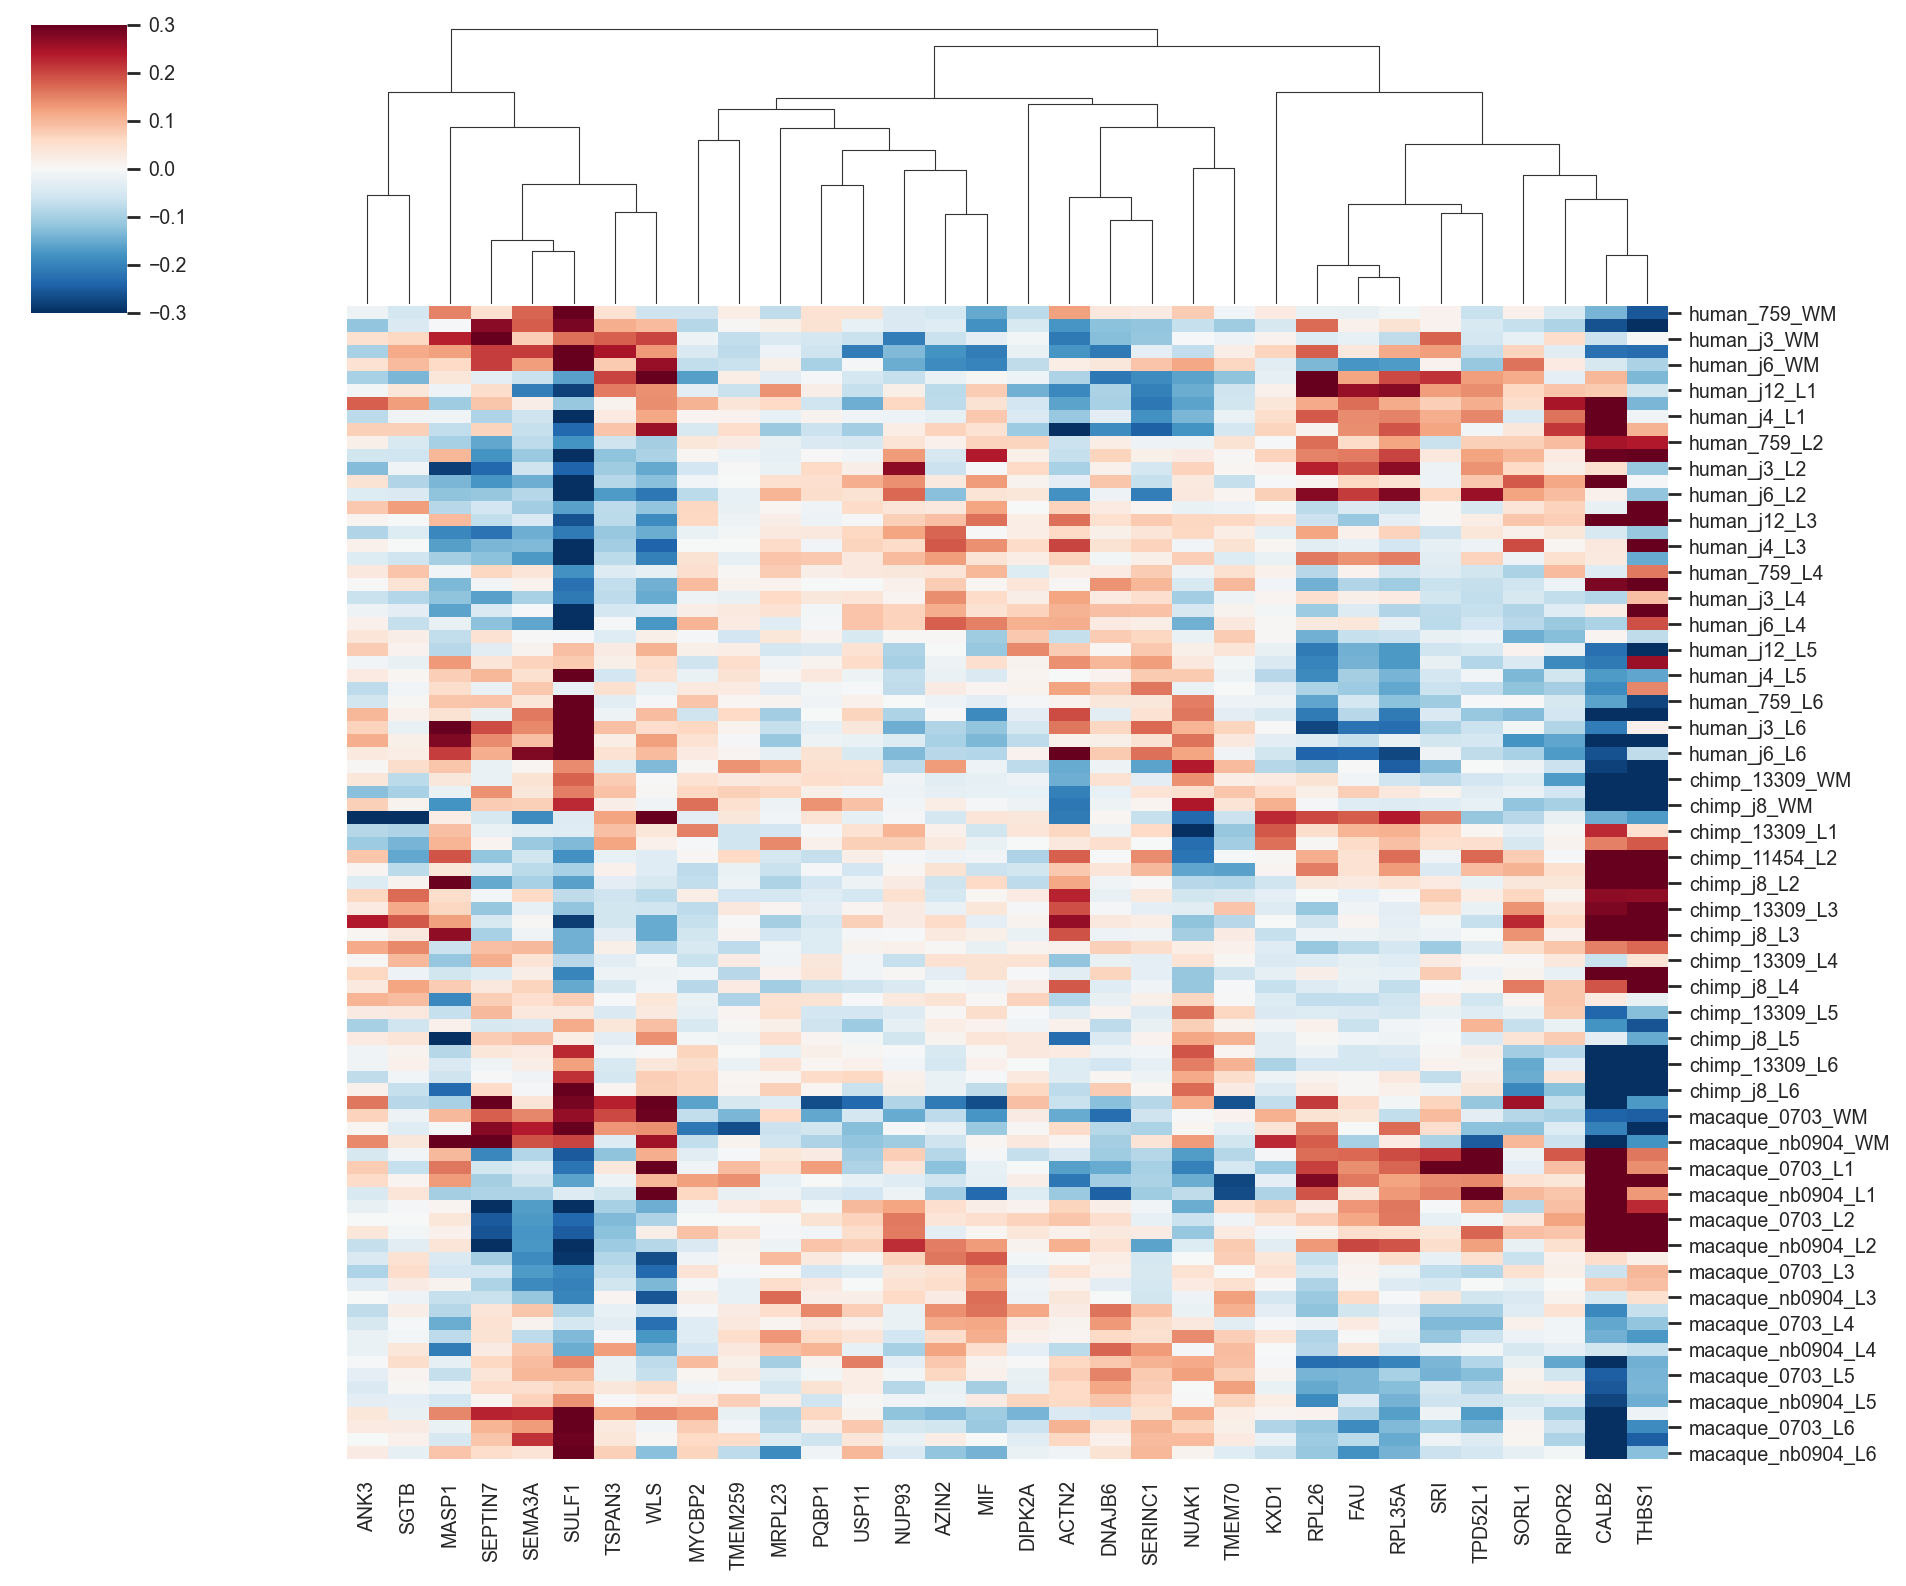

In [21]:
sns.set(font_scale=0.8)
sns.clustermap(df_cs, figsize=(12, 10), cmap="RdBu_r", center=0, vmax=0.3, vmin=-0.3, metric='cosine', annot_kws={"size": 2}, row_cluster=False)

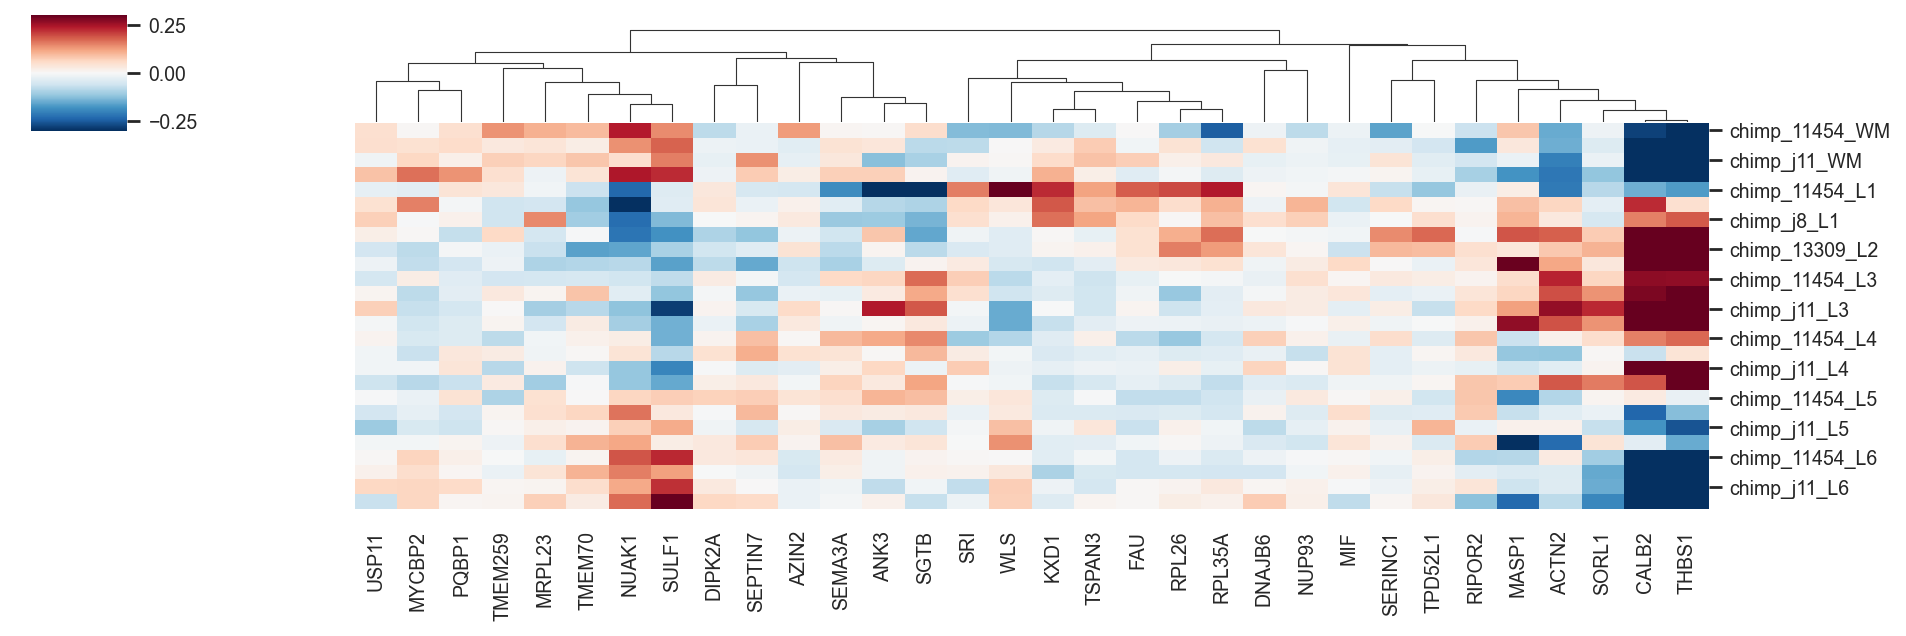

In [22]:
sns.clustermap(df_cs.loc[sample_order['chimp']], figsize=(12, 4), cmap="RdBu_r", center=0, vmax=0.3, vmin=-0.3, metric='cosine', annot_kws={"size": 2}, row_cluster=False)

## Spectral clusterisation

In [23]:
from sklearn.cluster import SpectralClustering
from sklearn.metrics.pairwise import pairwise_kernels
aff_matrix = pairwise_kernels(df_cs.T, metric='cosine') + 1
n_clusters = 4
#clustering = SpectralClustering(n_clusters=n_clusters, affinity='nearest_neighbors', random_state=4)
clustering = SpectralClustering(n_clusters=n_clusters, affinity='precomputed', random_state=4)
clustering.fit(aff_matrix)
#clustering.fit(df_cs.T[sample_order['chimp']])

SpectralClustering(affinity='precomputed', n_clusters=4, random_state=4)

In [24]:
labels = pd.Series(clustering.labels_, index=cs_genes).sort_values()
order = labels.sort_values().index

In [25]:
labels.to_csv('./results/chimp_clusters_ancova.csv')

In [26]:
cluster_color = ['red', 'yellow', 'orange', 'green', 'purple', 'blue', 'olive', 'pink', 'brown']

In [27]:
colors = cluster_color[:n_clusters]
clusters = np.arange(n_clusters)

[Text(0, 18.666666666666664, 'macaque'),
 Text(0, 45.333333333333336, 'chimp'),
 Text(0, 77.33333333333333, 'human')]

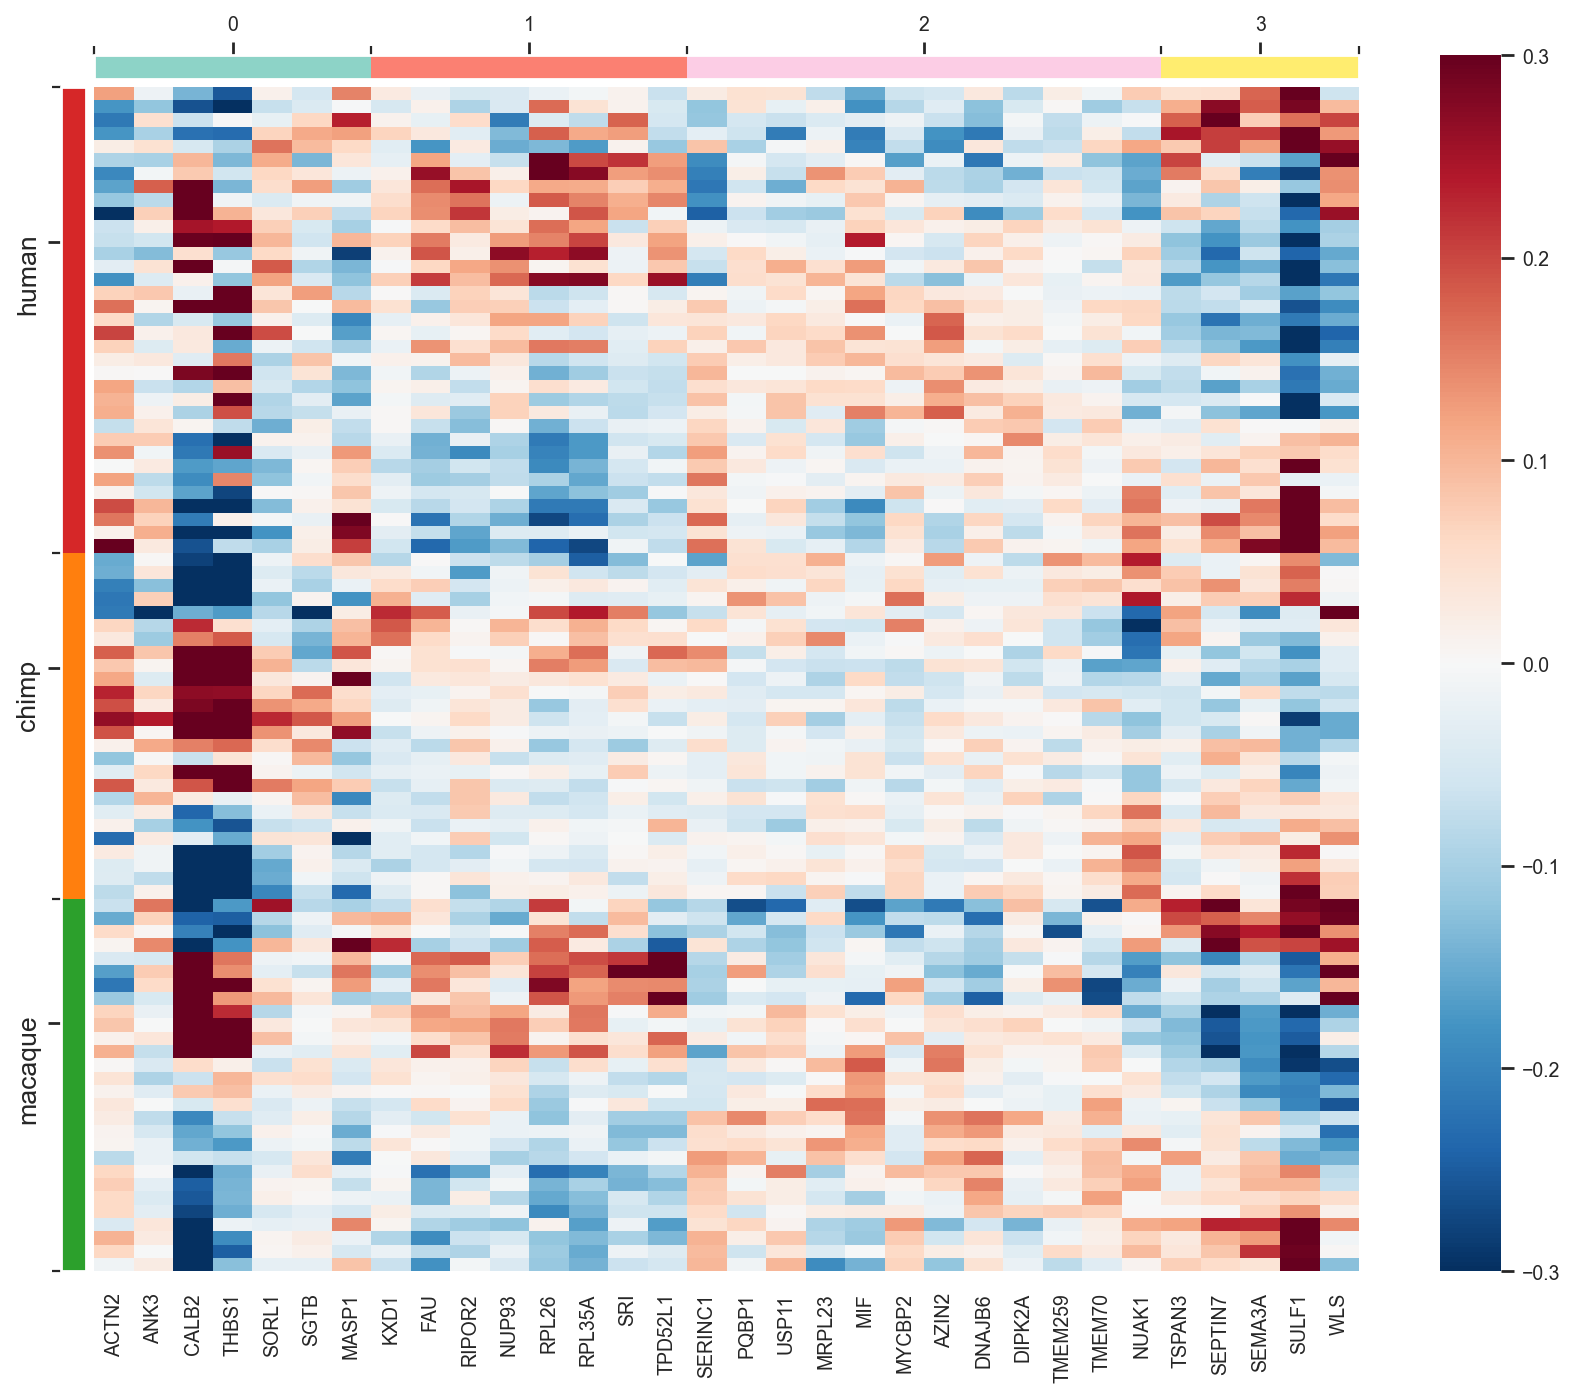

In [28]:
from matplotlib.patches import bbox_artist
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib import ticker

fig, ax = plt.subplots(figsize=(13, 10))
sns.heatmap(df_cs[order], ax=ax, cmap="RdBu_r", vmax=0.3, vmin=-0.3, center=0)
ax.set_yticks([])


divider = make_axes_locatable(ax)
cax = divider.append_axes('top', size='2%', pad=0.05)
cmap = plt.get_cmap('Set3')

cluster_size = labels.value_counts().loc[clusters].values
cluster_pos = cluster_size.cumsum()
bounds = [0] + list(cluster_pos)
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)
fig.colorbar(
    mpl.cm.ScalarMappable(cmap=cmap, norm=norm),
    cax=cax,
    ticks=bounds,
    orientation='horizontal',
    spacing='proportional'
)
cax.xaxis.set_major_locator(ticker.FixedLocator(cluster_pos - cluster_size / 2))
cax.xaxis.set_major_formatter(ticker.FixedFormatter(clusters))
cax.xaxis.tick_top()

# horisontal
cax = divider.append_axes('left', size='2%', pad=0.05)

cmap = mpl.colors.ListedColormap(['tab:red', 'tab:orange', 'tab:green'][::-1])
cond_size = adata_pb_norm.obs.condition.value_counts().loc[['human', 'chimp', 'macaque'][::-1]].values
cond_pos = cond_size.cumsum()
bounds = [0] + list(cond_pos)
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)

fig.colorbar(
    mpl.cm.ScalarMappable(cmap=cmap, norm=norm),
    cax=cax,
    ticks=bounds,
    orientation='vertical',
    spacing='proportional'
)

cax.yaxis.set_major_locator(ticker.FixedLocator(cond_pos - cond_size / 3))
cax.yaxis.set_major_formatter(ticker.FixedFormatter(['human', 'chimp', 'macaque'][::-1]))
cax.yaxis.tick_left()
cax.set_yticklabels(cax.get_yticklabels(), rotation=90, fontsize=12)

## Cluster profiles

In [29]:
df_annotation = df_cs.copy()
df_annotation['layer'] = adata_pb_norm.obs.layer
df_annotation['condition'] = adata_pb_norm.obs.condition

In [30]:
layer_mean = df_annotation.groupby(['condition', 'layer']).mean()
layer_mean.head()

ACTN2      ANK3     AZIN2     CALB2    DIPK2A    DNAJB6  \
condition layer                                                               
chimp     L1    -0.037919 -0.183637 -0.003322  0.076765  0.024166  0.014521   
          L2     0.125905  0.017390 -0.012923  0.410350 -0.076705  0.008536   
          L3     0.220166  0.084025  0.003101  0.422841  0.002319 -0.004079   
          L4     0.011400  0.052149  0.002351  0.213624  0.018757  0.020001   
          L5    -0.084475  0.013754  0.019430 -0.105568  0.021474 -0.033744   

                      FAU      KXD1     MASP1       MIF  ...     SORL1  \
condition layer                                          ...             
chimp     L1     0.113644  0.191612  0.071316 -0.012818  ... -0.054031   
          L2     0.040121 -0.015812  0.174038 -0.004883  ...  0.071812   
          L3    -0.010899 -0.034646  0.126455  0.007438  ...  0.140213   
          L4    -0.038550 -0.044725 -0.040463  0.013222  ...  0.056088   
          L5    -0.049051 -0.032683 -0.143396  0.027083  ... -0.009786   

                      SRI     SULF1     THBS1   TMEM259    TMEM70   TPD52L1  \
condition layer                                                               
chimp     L1     0.086844 -0.069200  0.020860 -0.028195 -0.095264 -0.020151   
          L2    -0.010713 -0.147644  0.423602  0.008271 -0.084628  0.081410   
          L3     0.024531 -0.155280  0.458362 -0.003646 -0.006258 -0.017722   
          L4    -0.003036 -0.144975  0.238344 -0.027354 -0.011689 -0.010822   
          L5    -0.002036  0.059881 -0.139947 -0.023613  0.044705 -0.008715   

                   TSPAN3     USP11       WLS  
condition layer                                
chimp     L1     0.109754  0.030377  0.118497  
          L2    -0.013570 -0.016864 -0.041218  
          L3    -0.051888  0.005203 -0.110761  
          L4    -0.020664 -0.018459 -0.030191  
          L5    -0.009751 -0.044105  0.073160  

[5 rows x 32 columns]

In [31]:
# fig, axes = plt.subplots(2, 2,  figsize=(14, 3.5 * 2), gridspec_kw={'hspace': 0.4})
# for gene, ax in zip(layer_mean.columns, axes.flatten()):
#     (
#             layer_mean[gene]
#             .reorder_levels(['layer', 'condition'])
#             .unstack().loc[layers]
#             .plot
#             .line(color={'human': 'tab:red', 'chimp': 'tab:orange', 'macaque': 'tab:green'}, ax=ax, marker='.')
#     )
#     ax.grid(False)

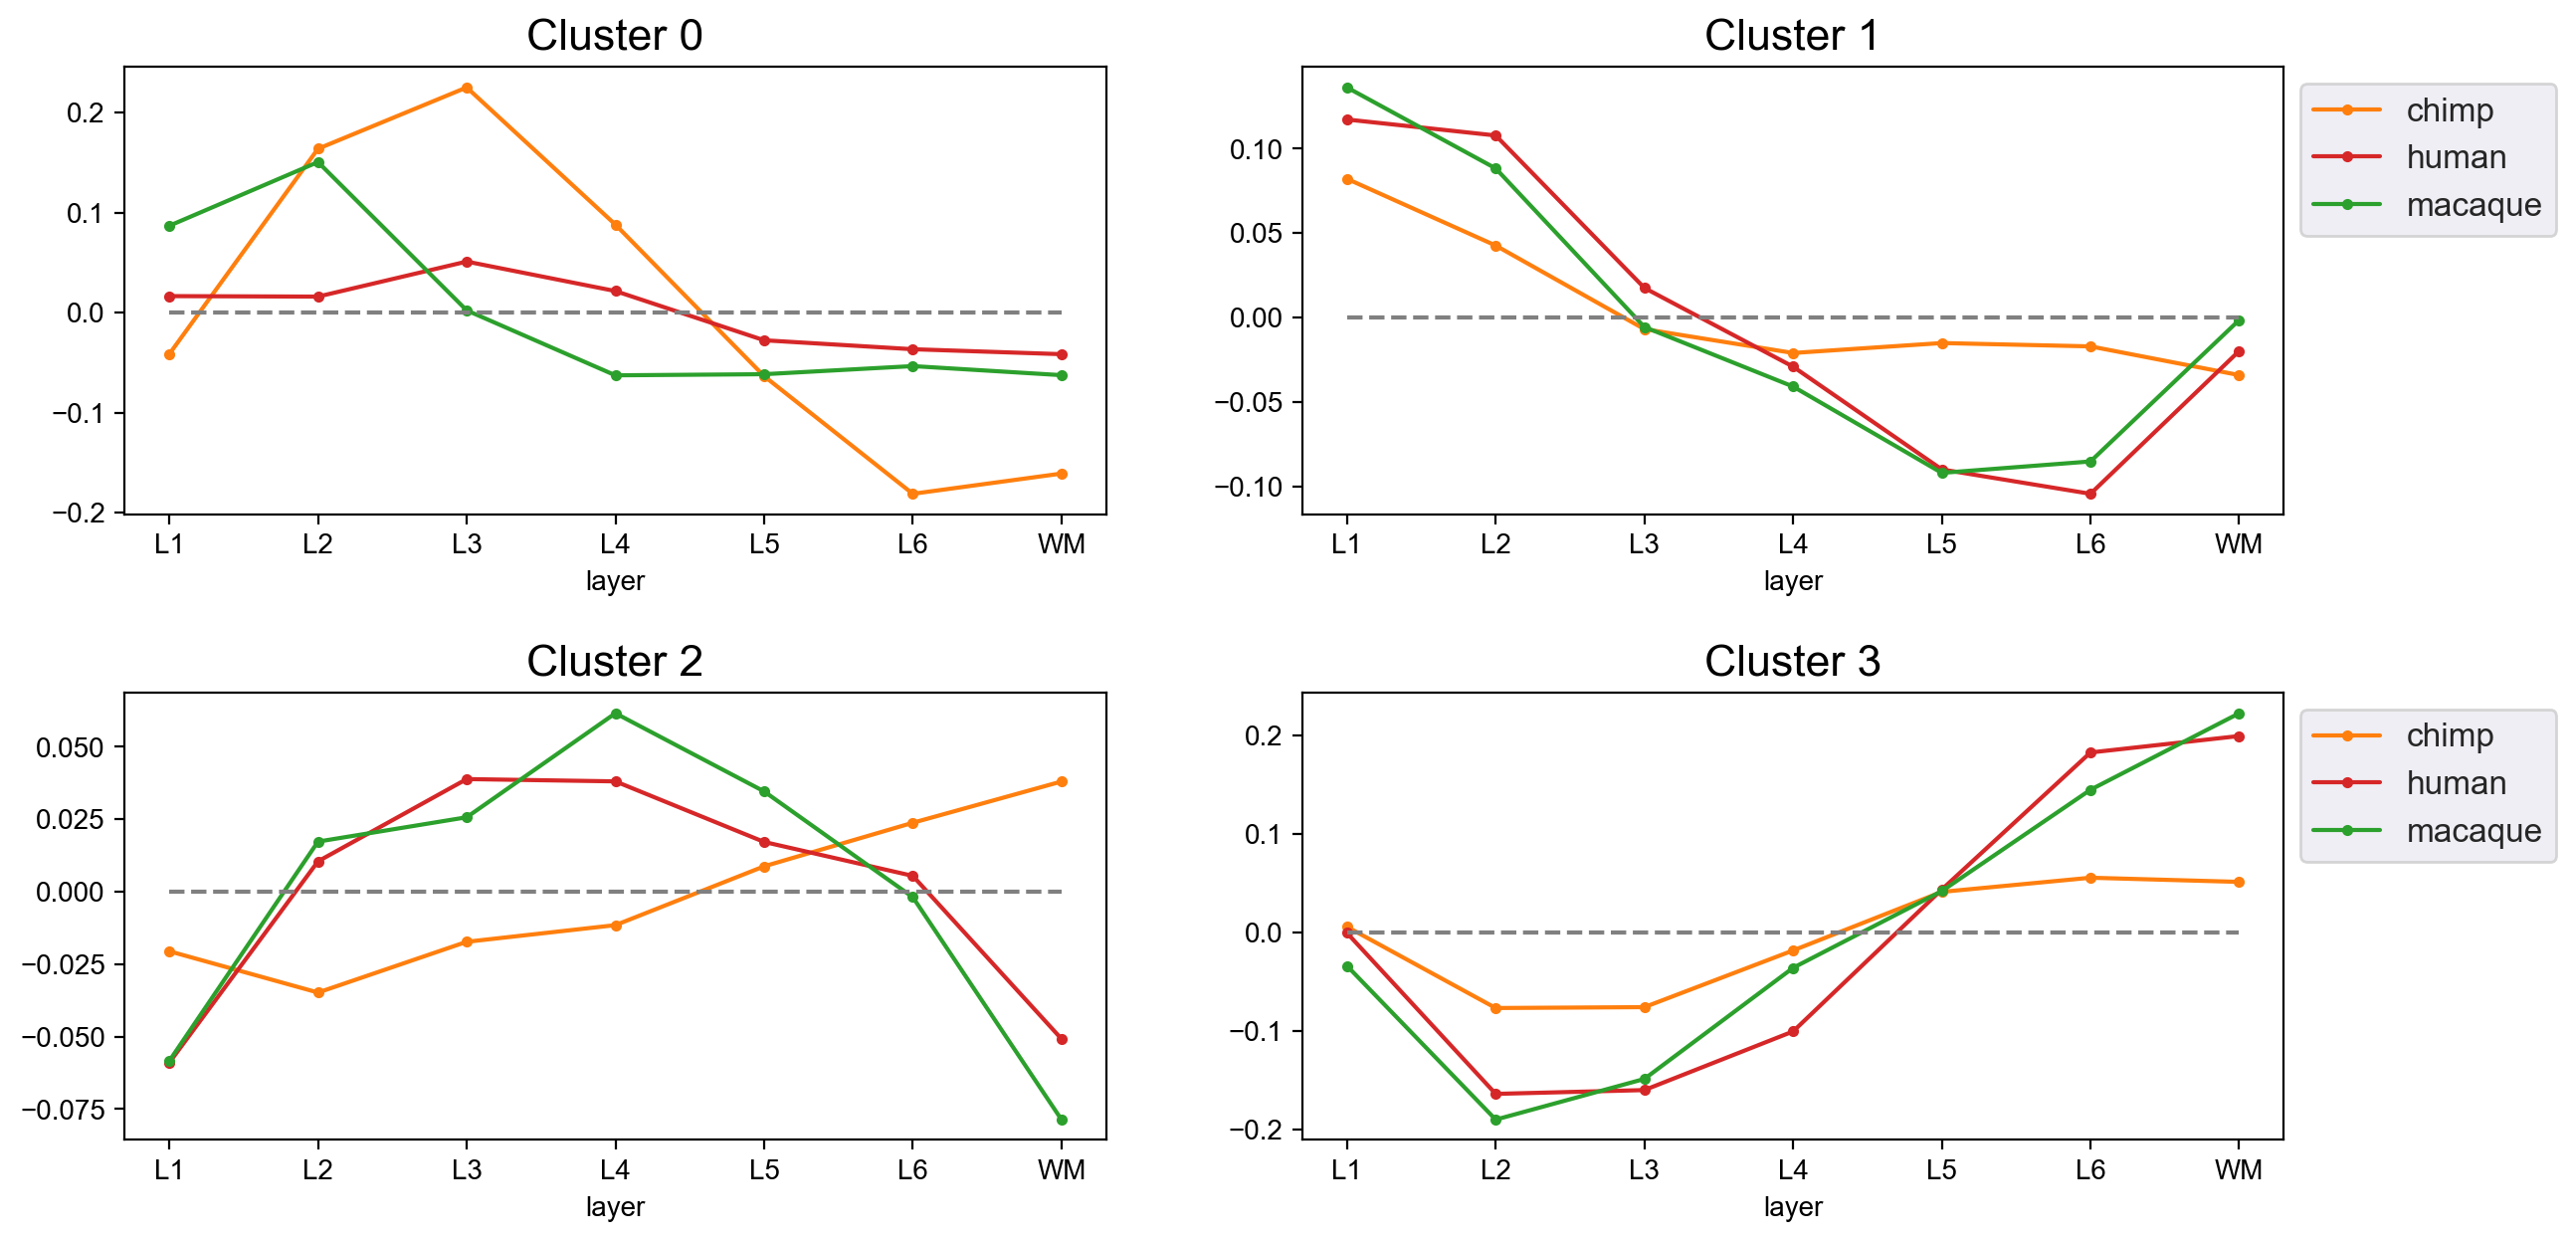

In [32]:
mpl.rcdefaults()
fig, axes = plt.subplots((n_clusters + 1) // 2, 2,  figsize=(14, 3.5 * n_clusters // 2), gridspec_kw={'hspace': 0.4})
sns.set(font_scale=1)
for label, ax in zip(labels.unique(), axes.flatten()):
    genes = labels[labels == label].index.tolist()

    (
        layer_mean[genes]
        .mean(axis=1)
        .reorder_levels(['layer', 'condition'])
        .unstack().loc[layers]
        .plot
        .line(color={'human': 'tab:red', 'chimp': 'tab:orange', 'macaque': 'tab:green'}, ax=ax, marker='.')
    )
    ax.legend(fontsize=10, loc="upper left", bbox_to_anchor=(1, 1), prop={"size":12})
    if label % 2 == 0:
        ax.get_legend().remove()
    ax.set_title(f'Cluster {label}', fontsize=16)
    ax.grid(False)
    ax.hlines(0, xmin=0, xmax=6, colors='gray', linestyles='dashed')

In [33]:
grid = np.linspace(1, 7, 400)
conditions = ['human', 'chimp', 'macaque']
cond_colors = ['tab:red', 'tab:orange', 'tab:green']

In [34]:
df_cont = df_annotation.copy()
df_cont['layer'] = df_cont.layer.map(dict(zip(sorted(df_cont.layer.unique()), range(1, 8)))).astype(int)

In [35]:
from scipy.interpolate import UnivariateSpline

array = np.zeros((grid.size, cs_genes.size))
df_list = []

for specie in conditions:
    for i, gene in enumerate(cs_genes.to_list()):
        #fit spline
        subs_index = df_cont[df_cont.condition == specie].index
        targ_dataset = df_cont.loc[subs_index].copy().sort_values(by='layer')
        x = targ_dataset['layer'].values
        y = targ_dataset[gene].values
        spl = UnivariateSpline(x, y, k=3)
        array[:, i] = spl(grid)
    df_specie = pd.DataFrame(array, columns=cs_genes)
    df_specie['condition'] = specie
    df_list.append(df_specie.copy())
df_spline = pd.concat(df_list)

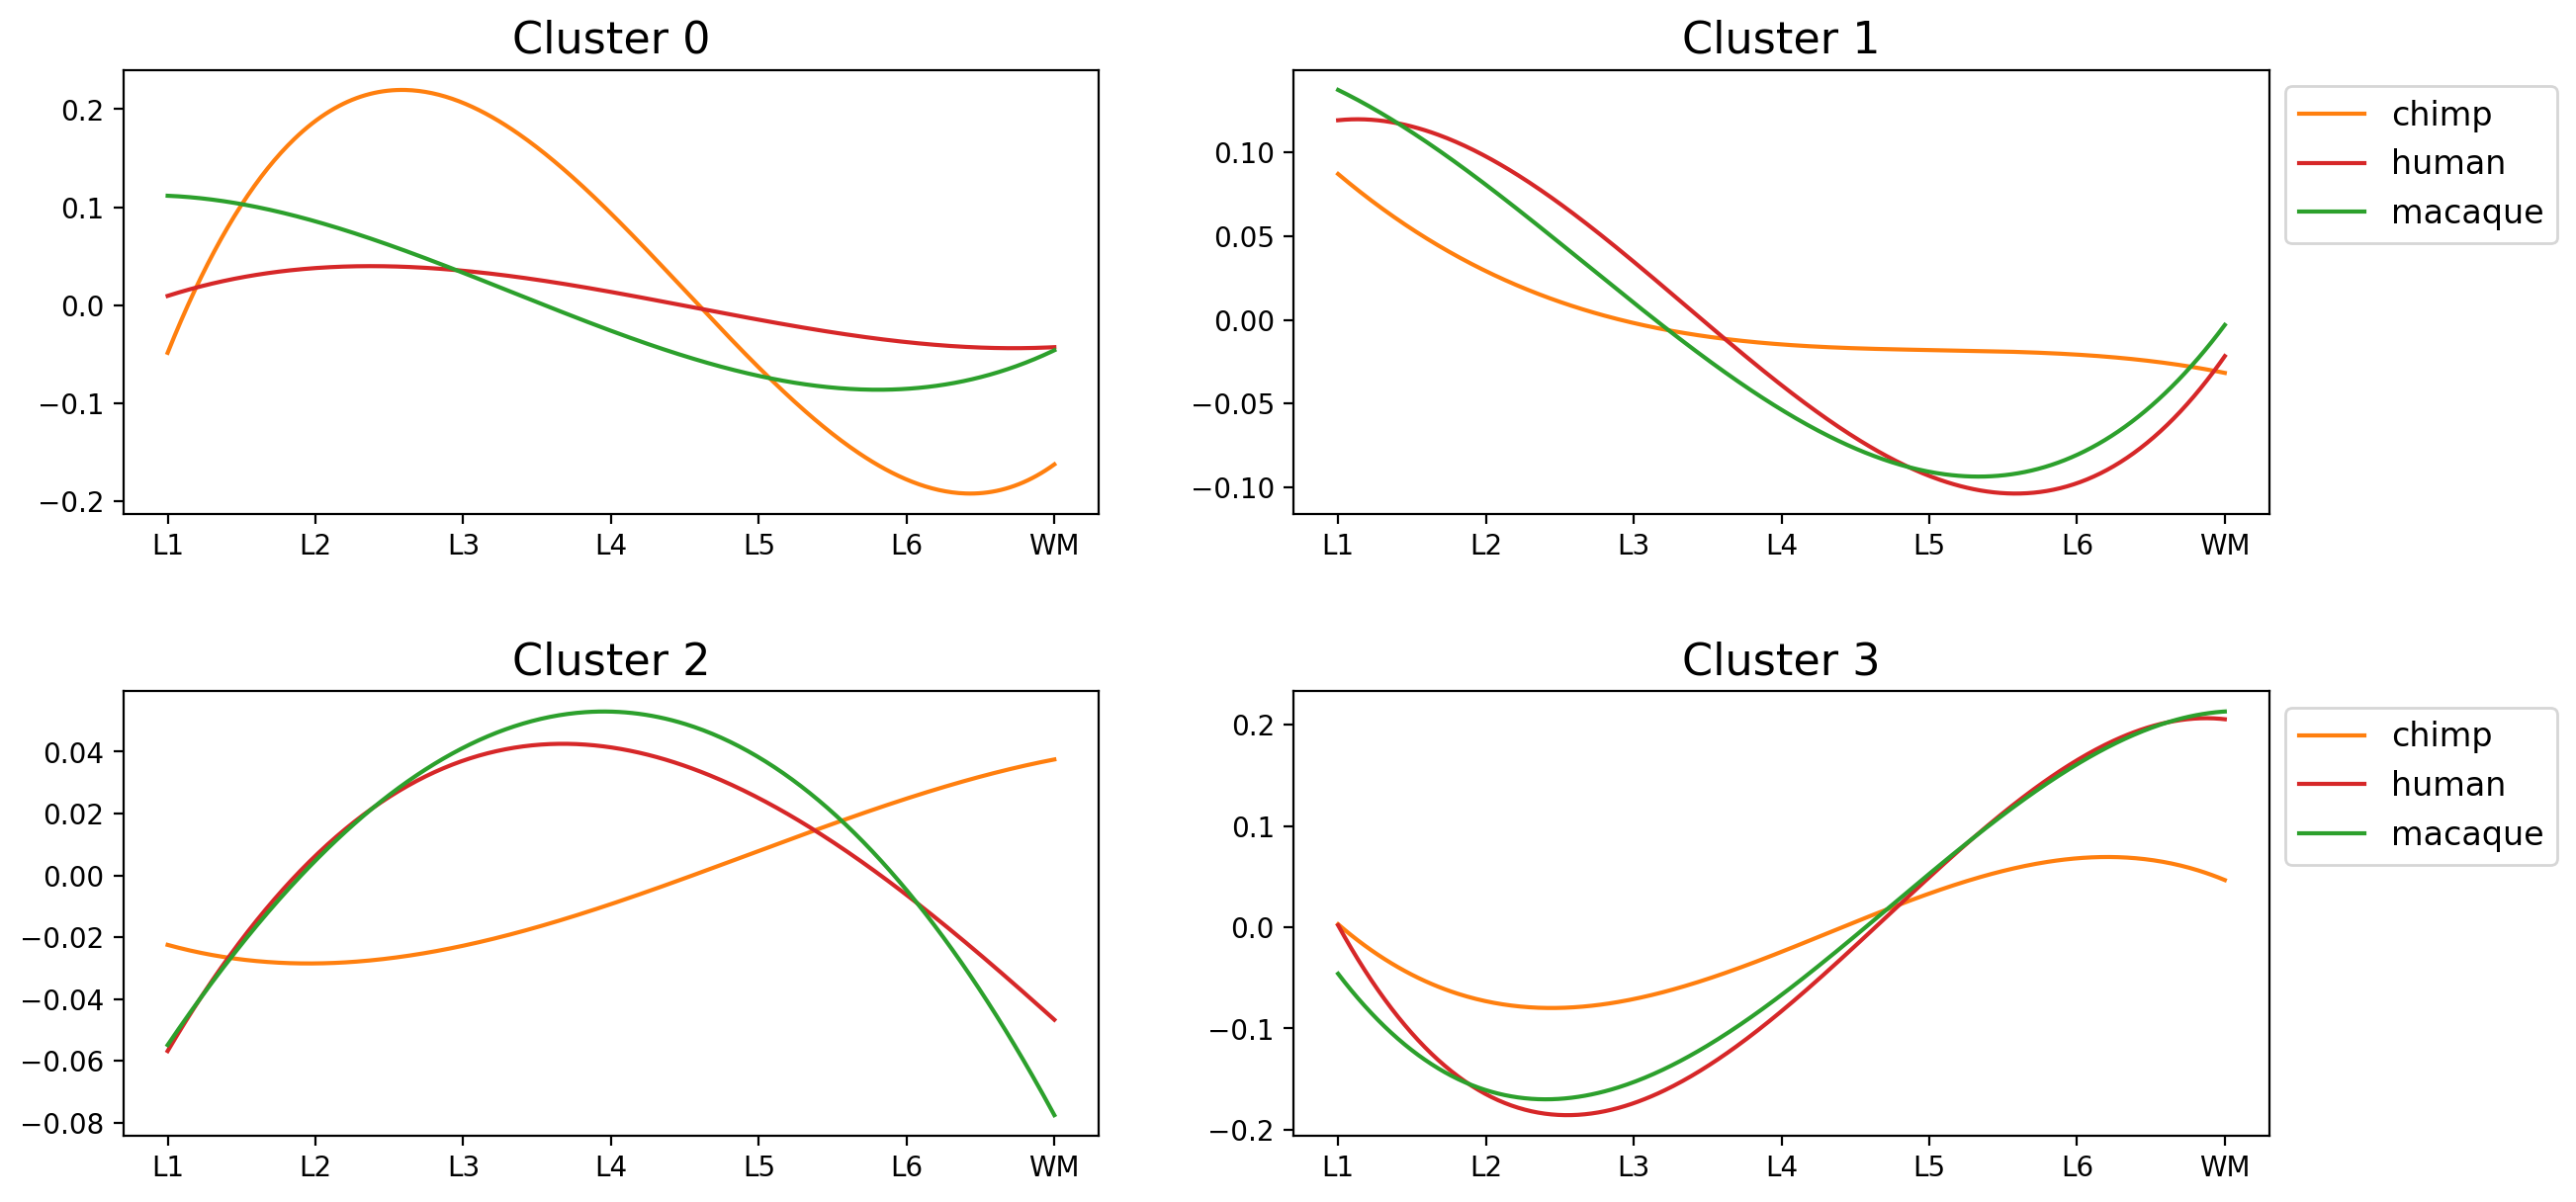

In [36]:
mpl.rcdefaults()
fig, axes = plt.subplots((n_clusters + 1) // 2, 2,  figsize=(14, 3.5 * n_clusters // 2), gridspec_kw={'hspace': 0.4})
for label, ax in zip(labels.unique(), axes.flatten()):
    genes = labels[labels == label].index.tolist()
    # plot the splines
    genes = labels[labels == label].index.tolist()
    df_cluster_spline = df_spline[genes].mean(axis=1).to_frame()
    df_cluster_spline['condition'] = df_spline['condition']
    df_cluster_spline = df_cluster_spline.pivot(columns='condition', values=0)
    df_cluster_spline.index = grid
    df_cluster_spline.plot.line(color={'human': 'tab:red', 'chimp': 'tab:orange', 'macaque': 'tab:green'}, ax=ax)

    # plot the dots
    # df_layers = layer_mean[genes].mean(axis=1).reorder_levels(['layer', 'condition']).unstack().loc[layers][conditions]
    # df_layers.index = np.arange(1, 8)
    # ax.set_prop_cycle(color=['tab:red', 'tab:orange', 'tab:green'])
    # ax.plot(df_layers, 'o', alpha=0.7)
    # ax.legend(conditions)
    
    
    ax.legend(fontsize=10, loc="upper left", bbox_to_anchor=(1, 1), prop={"size":12})
    ax.xaxis.set_major_locator(ticker.FixedLocator(np.arange(1, 8)))
    ax.xaxis.set_major_formatter(ticker.FixedFormatter(layers))
    
    if label % 2 == 0:
        ax.get_legend().remove()
    ax.set_title(f'Cluster {label}', fontsize=16)
    ax.grid(False)
    #ax.hlines(0, xmin=1, xmax=6, colors='gray', linestyles='dashed')

Text(0.5, 0.98, 'Median averaging for profiles')

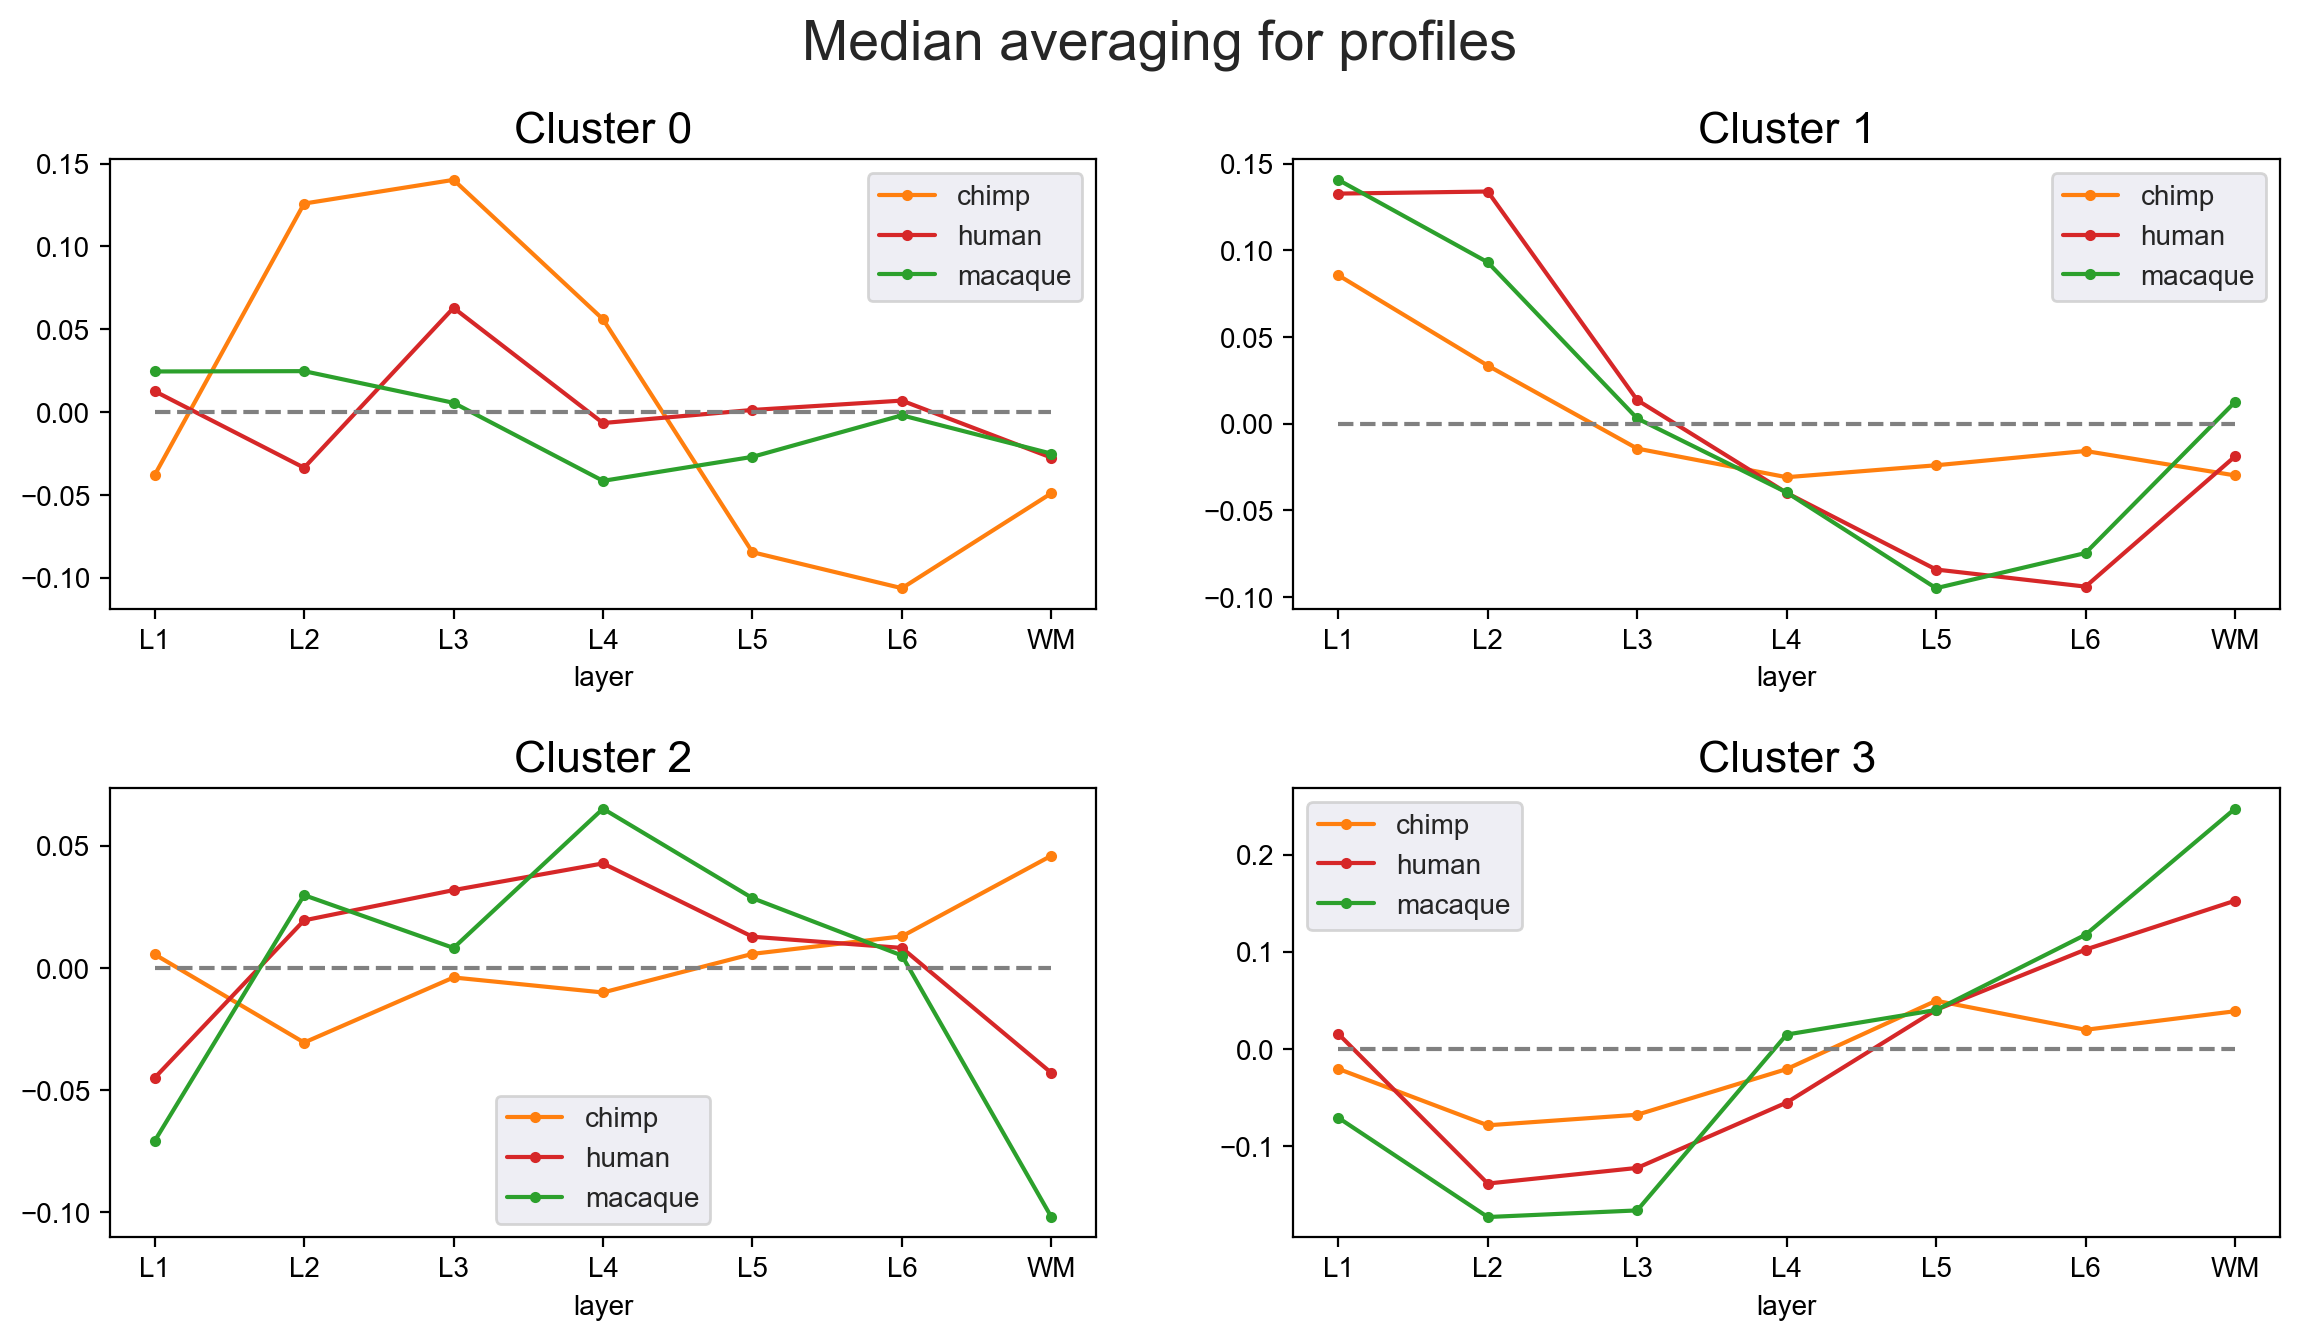

In [37]:
mpl.rcdefaults()
fig, axes = plt.subplots((n_clusters + 1) // 2, 2,  figsize=(14, 3.5 * n_clusters // 2), gridspec_kw={'hspace': 0.4})
sns.set(font_scale=1)
for label, ax in zip(labels.unique(), axes.flatten()):
    genes = labels[labels == label].index.tolist()

    (
        layer_mean[genes]
        .median(axis=1)
        .reorder_levels(['layer', 'condition'])
        .unstack().loc[layers]
        .plot
        .line(color={'human': 'tab:red', 'chimp': 'tab:orange', 'macaque': 'tab:green'}, ax=ax, marker='.')
    )
    ax.legend(fontsize=10)
    ax.set_title(f'Cluster {label}', fontsize=16)
    ax.grid(False)
    ax.hlines(0, xmin=0, xmax=6, colors='gray', linestyles='dashed')

fig.suptitle('Median averaging for profiles', fontsize=20)

# 4 Species

In [38]:
pb_dir_path = '../../data/pseudobulks/'
adata_pb_4spe = sc.read_h5ad(pb_dir_path + '4spe_pb_mean_filt_nor_mean.h5ad')
#adata_pb_norm_mean.var = anova_res
adata_pb_4spe

AnnData object with n_obs × n_vars = 116 × 6523
    obs: 'layer', 'sample_id', 'condition', 'lib_size', 'log_lib_size'
    var: 'gene_name'
    uns: 'log1p'

In [39]:
df_4spe = pd.DataFrame(adata_pb_4spe.X, index=adata_pb_4spe.obs_names, columns=adata_pb_4spe.var_names)

In [40]:
cs_genes_inter = df_4spe.columns.intersection(cs_genes)
cs_genes_inter.size

18

In [41]:
sample_order = dict()
for cond in ['human', 'chimp', 'macaque', 'treeshrew']:
    samples = df_4spe.loc[df_4spe.index.str.contains(cond)].index
    order_s = sorted(samples.tolist(), key=lambda x: x[:2])
    order_laminar = list(filter(lambda x: 'L' in x, order_s))
    order_wm = list(filter(lambda x: 'WM' in x, order_s))
    sample_order[cond] = order_wm + order_laminar
sample_order['all'] = sample_order['human'] + sample_order['chimp'] + sample_order['macaque'] + sample_order['treeshrew']
df_4spe = df_4spe.loc[sample_order['all']]
df_4spe_hs = df_4spe[cs_genes_inter]

In [42]:
order_4spe = order.intersection(cs_genes_inter)

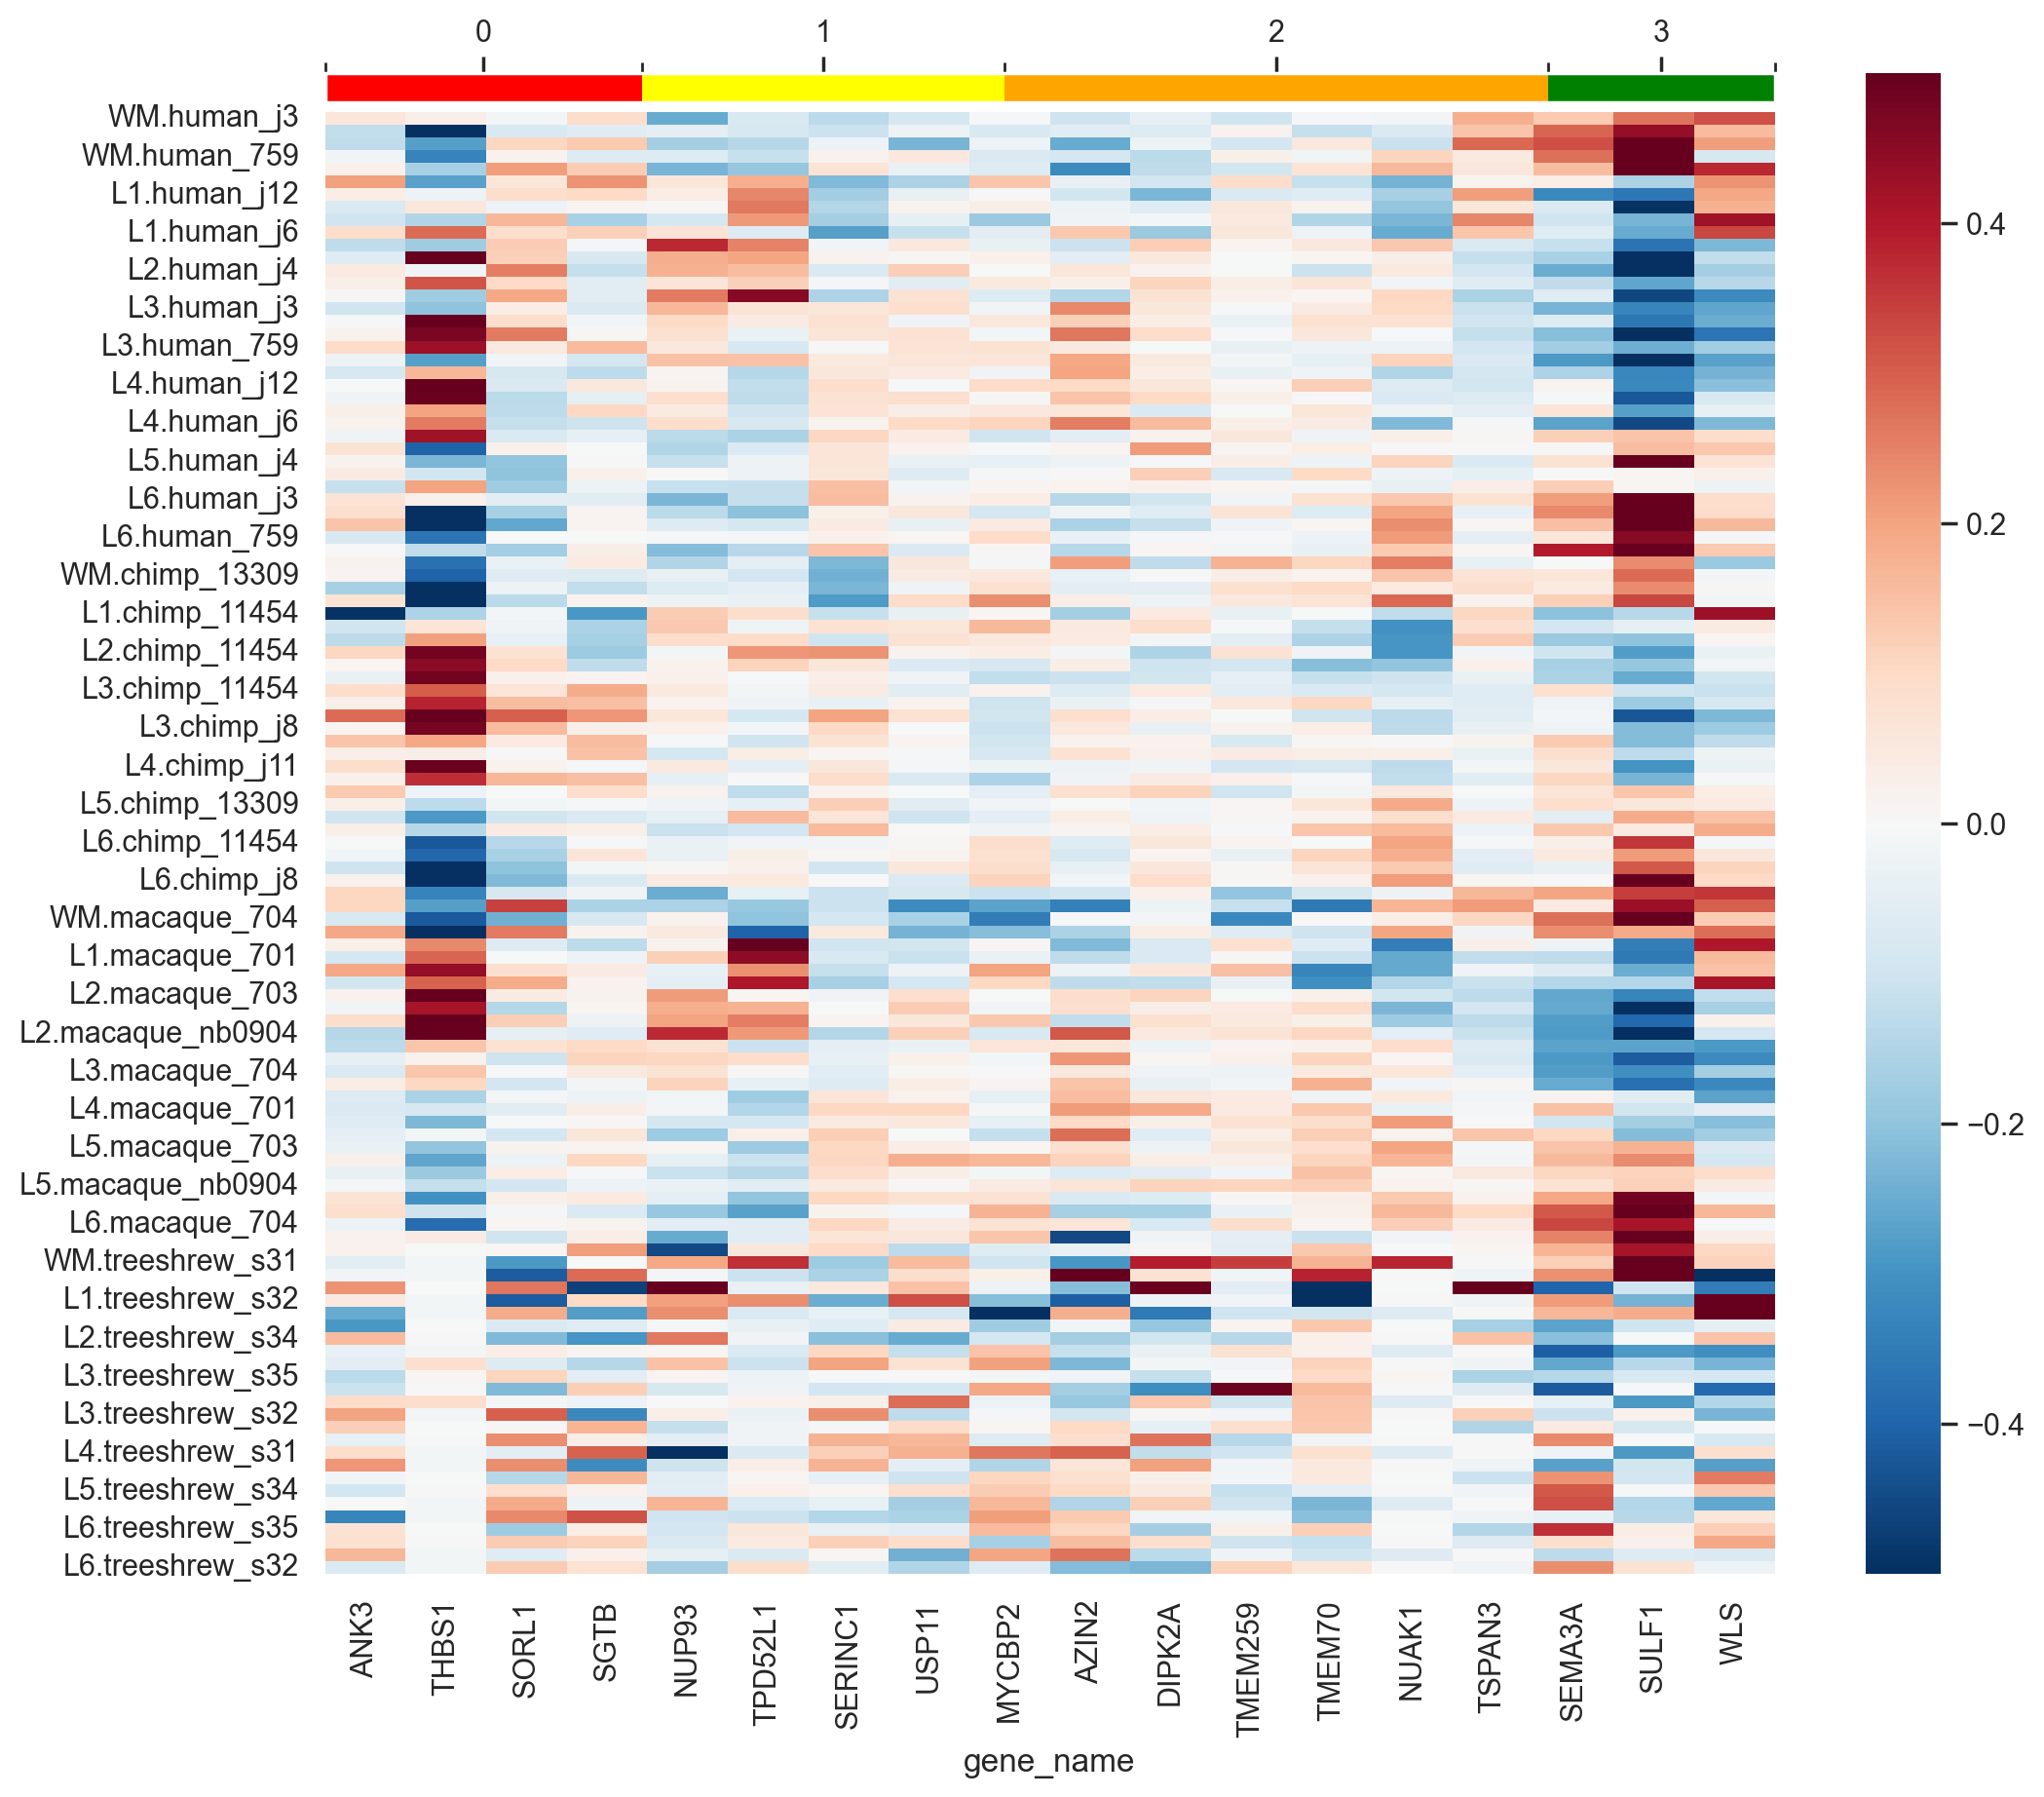

In [43]:
from matplotlib.patches import bbox_artist
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib import ticker

fig, ax = plt.subplots(figsize=(12, 10))
sns.heatmap(df_4spe_hs[order_4spe], ax=ax, cmap="RdBu_r", vmax=0.5, vmin=-0.5, center=0)
divider = make_axes_locatable(ax)
cax = divider.append_axes('top', size='2%', pad=0.05)
cmap = mpl.colors.ListedColormap(colors)

cluster_size = labels.value_counts().loc[clusters].values
cluster_pos = cluster_size.cumsum()
bounds = [0] + list(cluster_pos)
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)
fig.colorbar(
    mpl.cm.ScalarMappable(cmap=cmap, norm=norm),
    cax=cax,
    ticks=bounds,
    orientation='horizontal',
    spacing='proportional'
)
cax.xaxis.set_major_locator(ticker.FixedLocator(cluster_pos - cluster_size / 2))
cax.xaxis.set_major_formatter(ticker.FixedFormatter(clusters))
cax.xaxis.tick_top()

## Cluster profiles (mean)

In [44]:
df_annotation = df_4spe_hs.copy()
df_annotation['layer'] = adata_pb_4spe.obs.layer
df_annotation['condition'] = adata_pb_4spe.obs.condition

In [45]:
layer_mean = df_annotation.groupby(['condition', 'layer']).mean()
layer_mean.head()

gene_name           AZIN2       WLS    DIPK2A      SGTB   SERINC1   TPD52L1  \
condition layer                                                               
chimp     6a          NaN       NaN       NaN       NaN       NaN       NaN   
          L1    -0.024870  0.160677  0.039857 -0.204995 -0.047715  0.052663   
          L2    -0.028452 -0.048604 -0.117550 -0.099180  0.106312  0.110099   
          L3     0.008705 -0.151951  0.009027  0.146068  0.076599 -0.034727   
          L4     0.011918 -0.048296  0.017044  0.110791  0.057703 -0.028150   

gene_name          SEMA3A     USP11     SULF1    TMEM70     SORL1      ANK3  \
condition layer                                                               
chimp     6a          NaN       NaN       NaN       NaN       NaN       NaN   
          L1    -0.161038  0.033495 -0.128867 -0.090638 -0.025362 -0.242198   
          L2    -0.140664 -0.023828 -0.241896 -0.115463  0.068469  0.029233   
          L3     0.005594  0.008553 -0.232210 -0.007174  0.168666  0.104636   
          L4     0.095570 -0.020148 -0.218902 -0.012771  0.058791  0.072445   

gene_name           NUAK1    MYCBP2     THBS1    TSPAN3     NUP93   TMEM259  
condition layer                                                              
chimp     6a          NaN       NaN       NaN       NaN       NaN       NaN  
          L1    -0.240461  0.074888  0.037758  0.106345  0.118650 -0.031654  
          L2    -0.198876 -0.056972  0.471778 -0.007965  0.011037 -0.020200  
          L3    -0.099823 -0.071916  0.514841 -0.054059  0.038760  0.003608  
          L4    -0.055705 -0.089579  0.272352 -0.022184 -0.023170 -0.025835

Text(0.5, 0.98, 'Mean averaging for profiles')

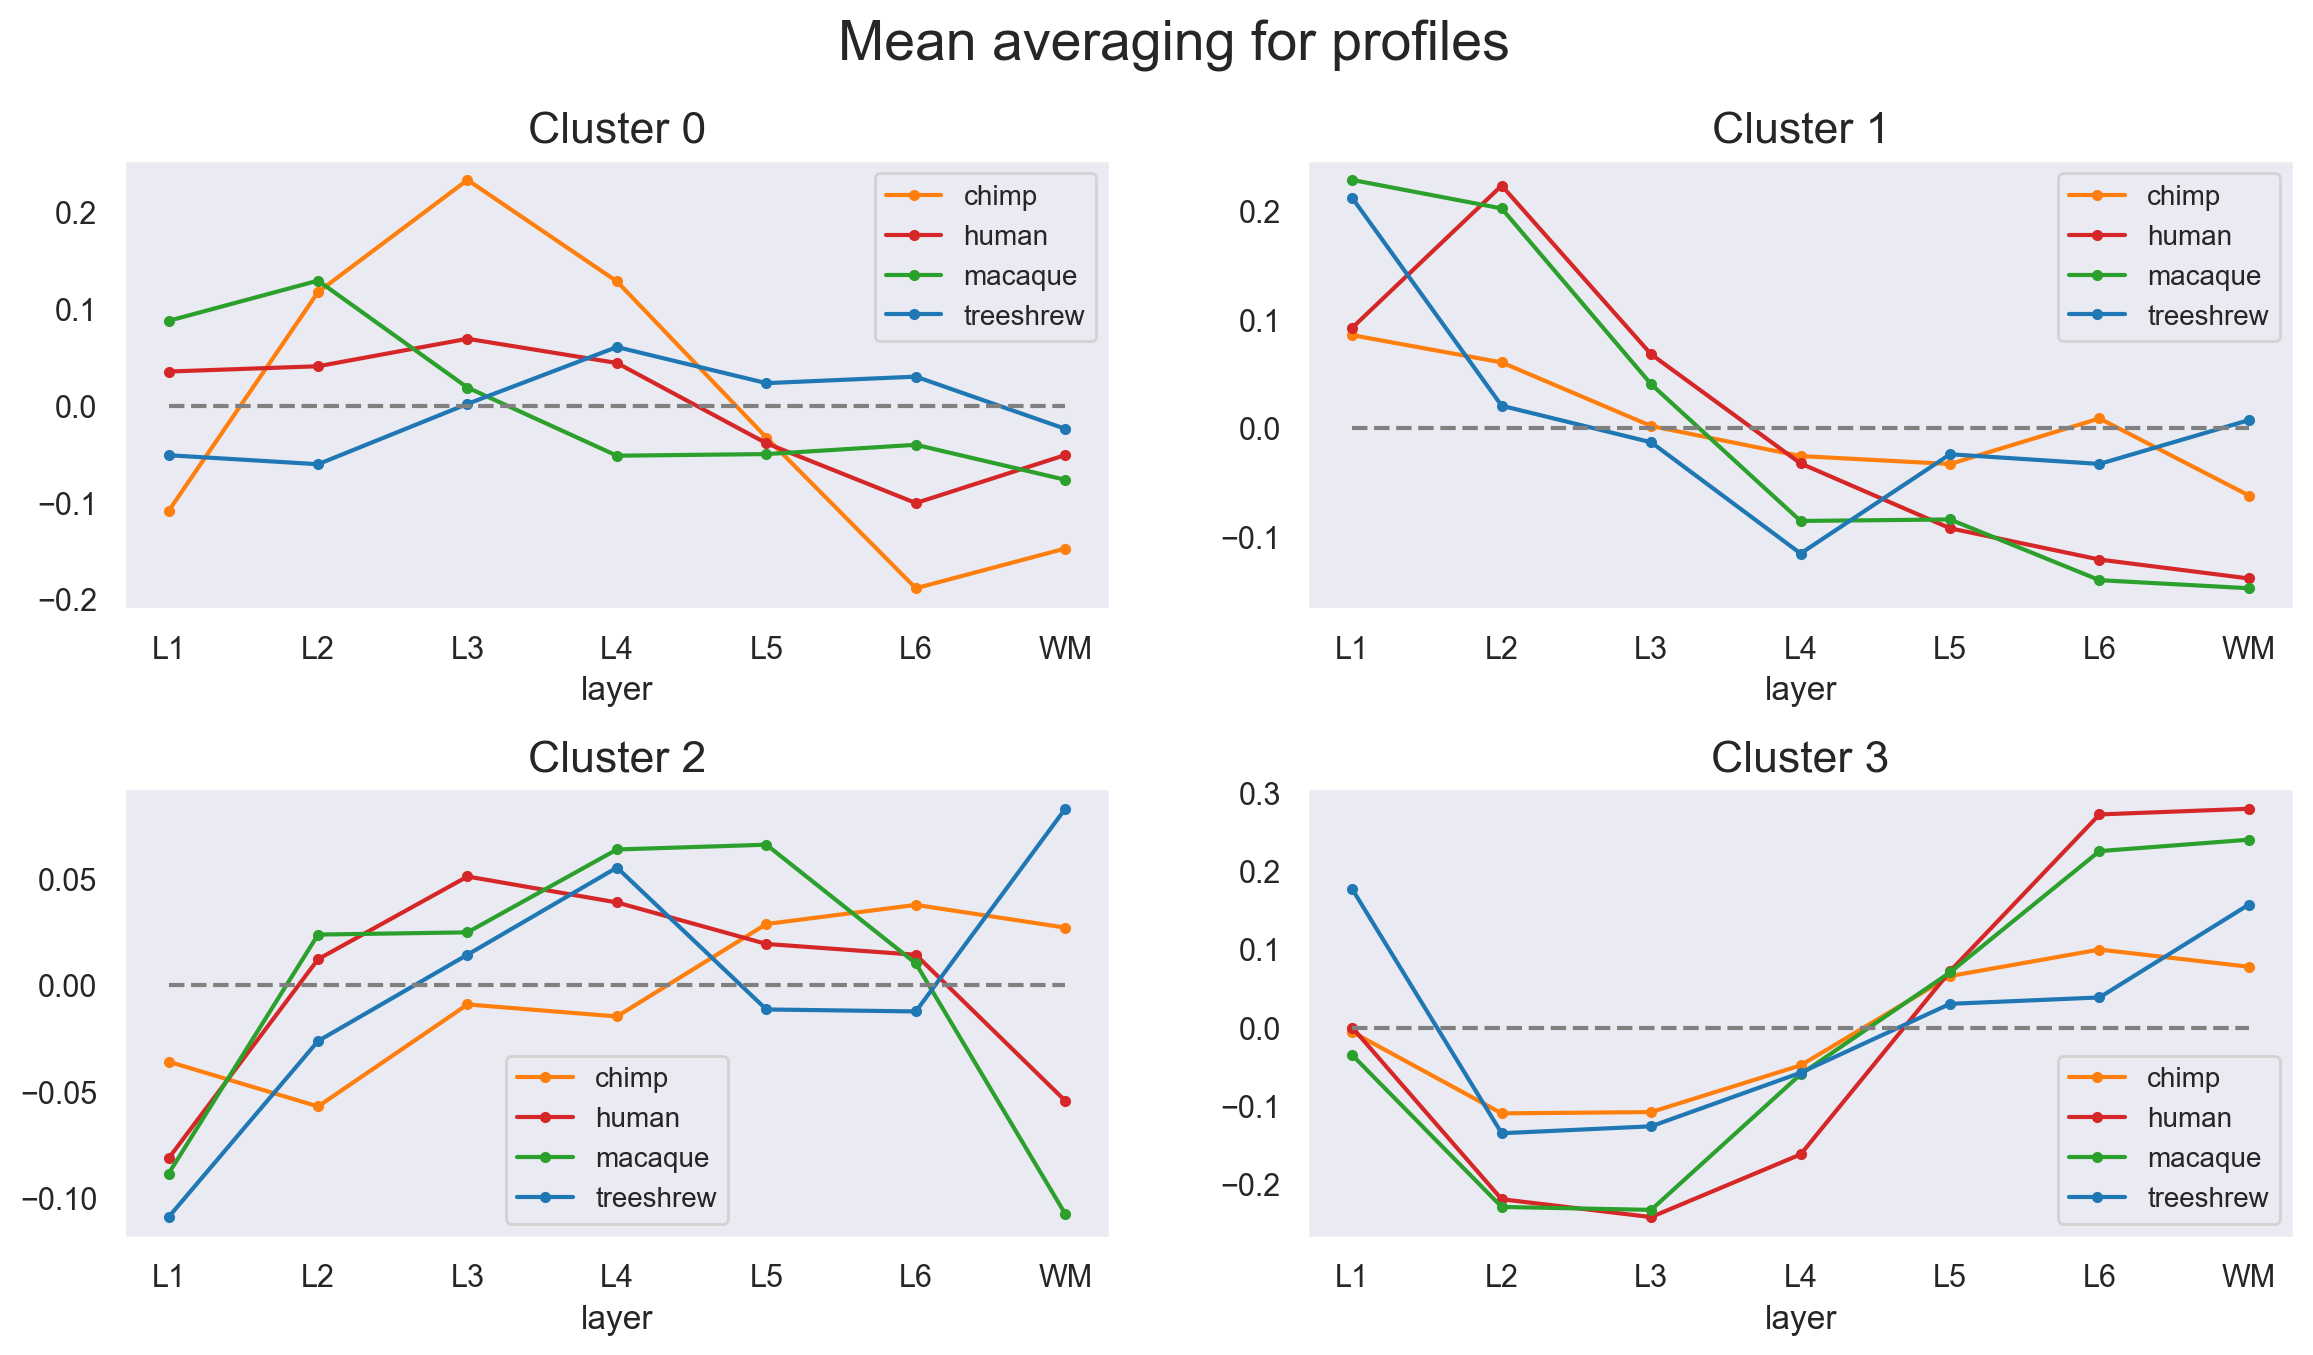

In [46]:
fig, axes = plt.subplots((n_clusters + 1) // 2, 2,  figsize=(14, 3.5 * n_clusters // 2), gridspec_kw={'hspace': 0.4})
sns.set(font_scale=1)
for label, ax in zip(labels.unique(), axes.flatten()):
    genes = labels[labels == label].index.intersection(cs_genes_inter).tolist()

    (
        layer_mean[genes]
        .mean(axis=1)
        .reorder_levels(['layer', 'condition'])
        .unstack().loc[layers]
        .plot
        .line(color={'human': 'tab:red', 'chimp': 'tab:orange', 'macaque': 'tab:green', 'treeshrew': 'tab:blue'}, ax=ax, marker='.')
    )
    ax.legend(fontsize=10)
    ax.set_title(f'Cluster {label}', fontsize=16)
    ax.grid(False)
    ax.hlines(0, xmin=0, xmax=6, colors='gray', linestyles='dashed')

fig.suptitle('Mean averaging for profiles', fontsize=20)

## Cluster profiles (Median)

Text(0.5, 0.98, 'Median averaging for profiles')

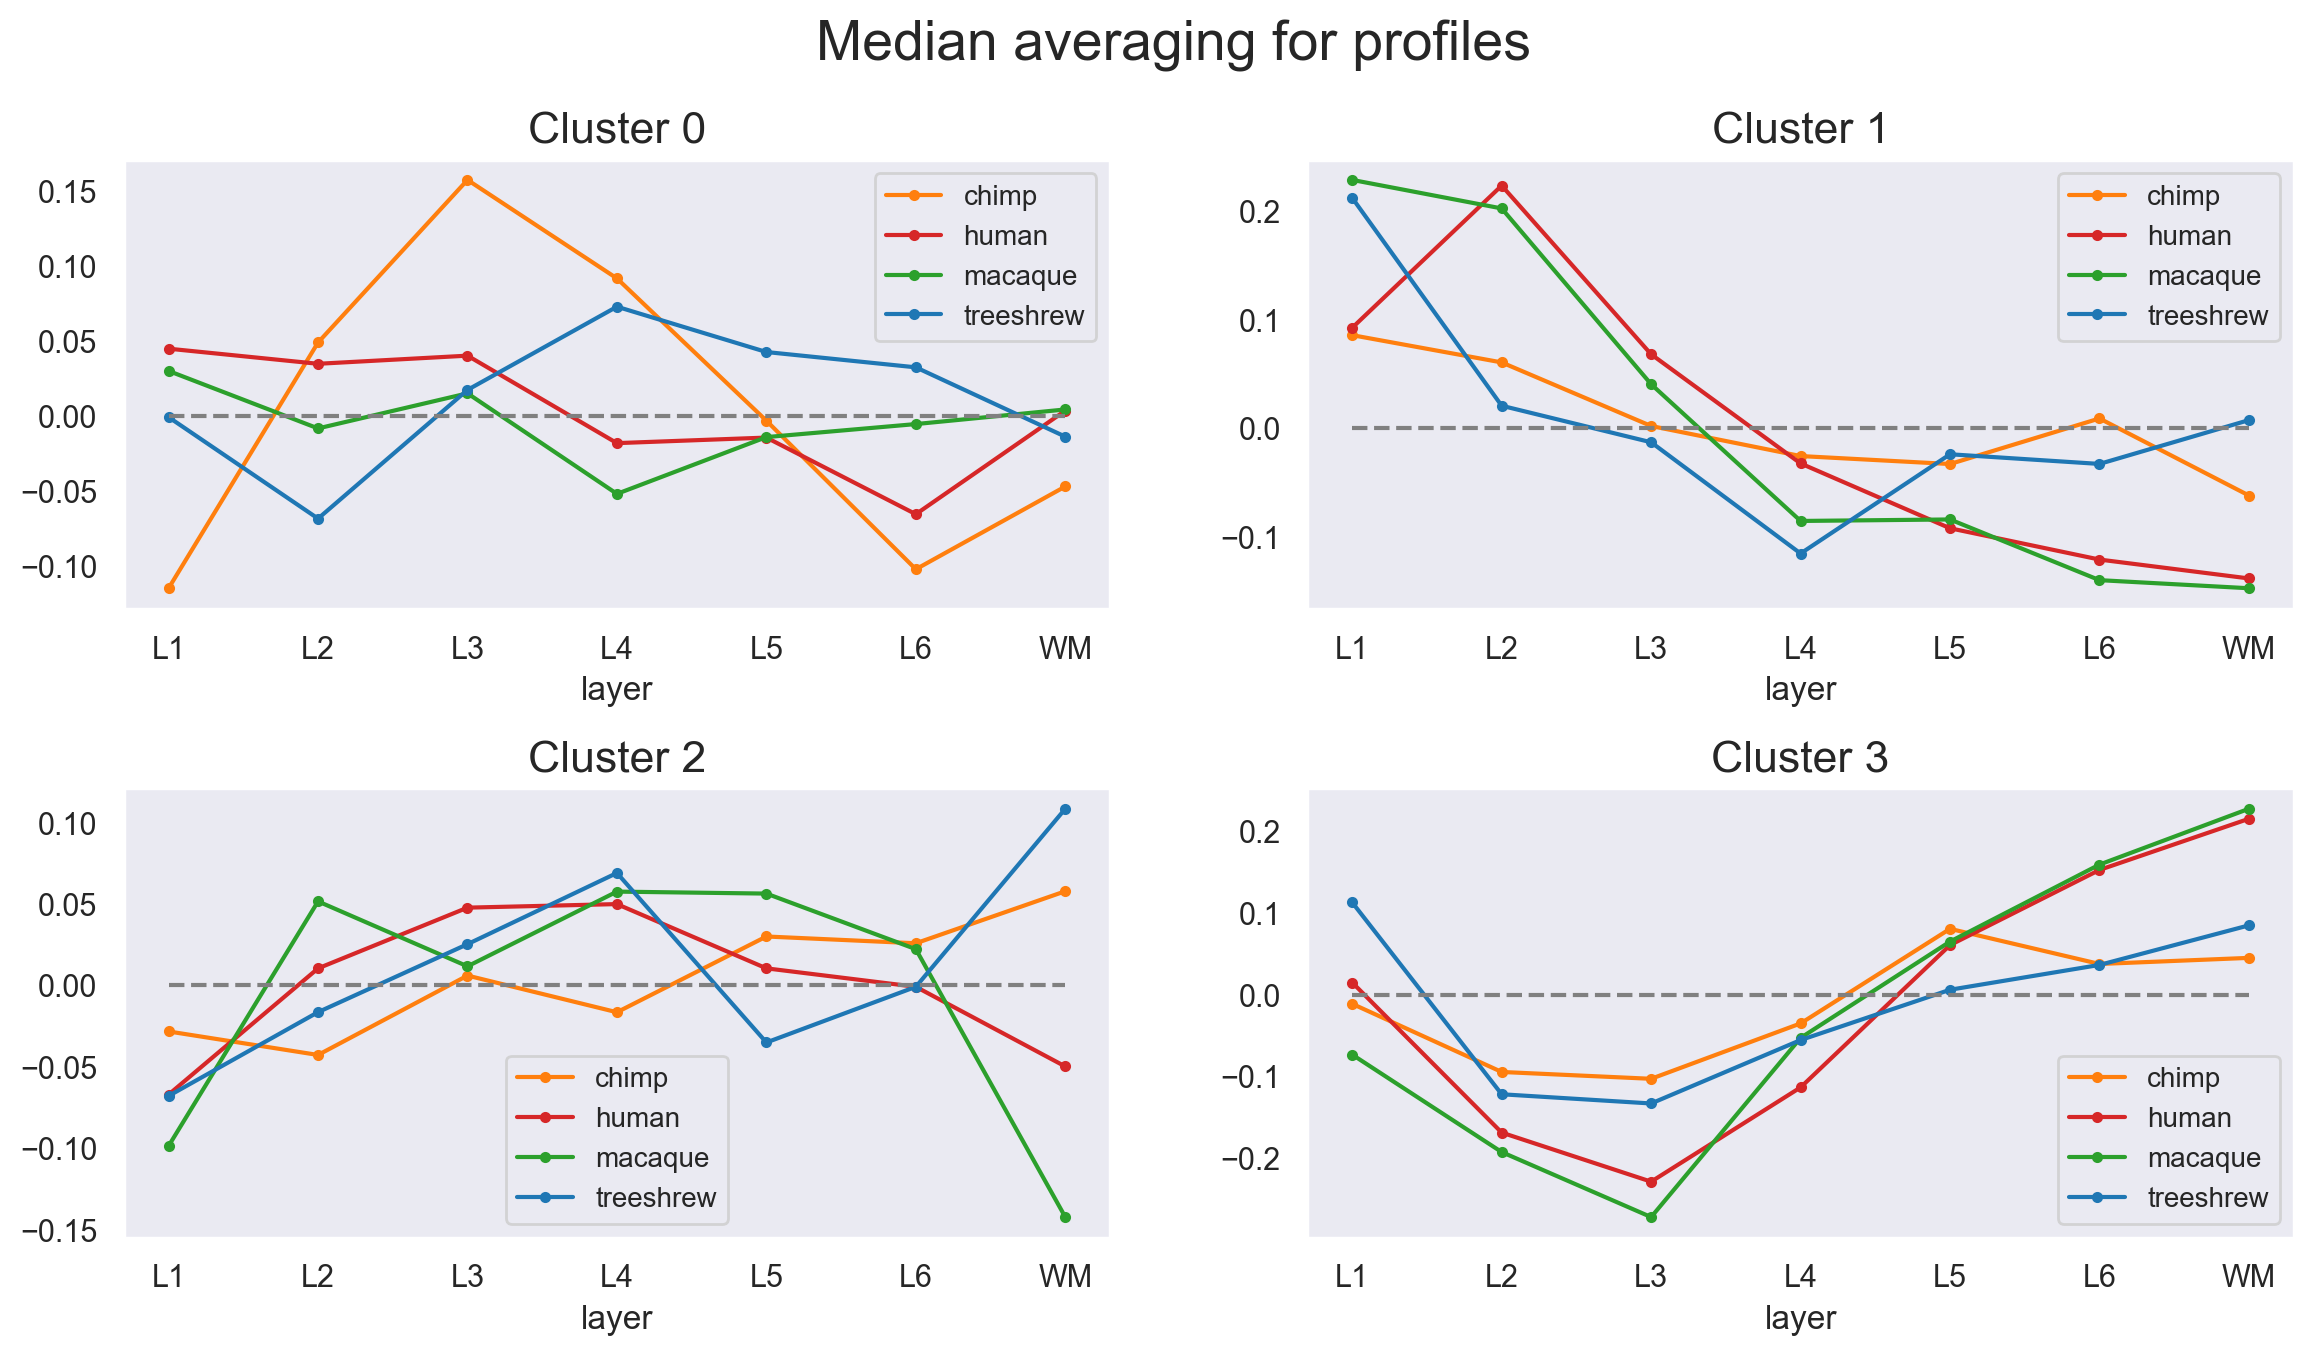

In [47]:
fig, axes = plt.subplots((n_clusters + 1) // 2, 2,  figsize=(14, 3.5 * n_clusters // 2), gridspec_kw={'hspace': 0.4})
sns.set(font_scale=1)
for label, ax in zip(labels.unique(), axes.flatten()):
    genes = labels[labels == label].index.intersection(cs_genes_inter).tolist()

    (
        layer_mean[genes]
        .median(axis=1)
        .reorder_levels(['layer', 'condition'])
        .unstack().loc[layers]
        .plot
        .line(color={'human': 'tab:red', 'chimp': 'tab:orange', 'macaque': 'tab:green', 'treeshrew': 'tab:blue'}, ax=ax, marker='.')
    )
    ax.legend(fontsize=10)
    ax.set_title(f'Cluster {label}', fontsize=16)
    ax.grid(False)
    ax.hlines(0, xmin=0, xmax=6, colors='gray', linestyles='dashed')

fig.suptitle('Median averaging for profiles', fontsize=20)

# Intersection with ANOVA clusters

In [48]:
anova_hs_inter = cs_genes.intersection(anova_labels.index)
anova_hs_inter

Index(['ACTN2', 'ANK3', 'AZIN2', 'CALB2', 'DIPK2A', 'DNAJB6', 'KXD1', 'MASP1',
       'MIF', 'MRPL23', 'MYCBP2', 'NUAK1', 'NUP93', 'PQBP1', 'RIPOR2', 'RPL26',
       'RPL35A', 'SEMA3A', 'SEPTIN7', 'SERINC1', 'SGTB', 'SORL1', 'SRI',
       'SULF1', 'THBS1', 'TMEM259', 'TMEM70', 'TPD52L1', 'TSPAN3', 'USP11',
       'WLS'],
      dtype='object')

In [49]:
table_to_pivot = pd.concat([anova_labels.loc[anova_hs_inter], labels.loc[anova_hs_inter]], axis=1)
table_to_pivot.columns = ['ANOVA_labels', 'hs_labels']
pivot_labels_inter = table_to_pivot.groupby('ANOVA_labels').value_counts().unstack().fillna(0)
pivot_labels_inter

hs_labels       0    1    2    3
ANOVA_labels                    
0             1.0  3.0  1.0  0.0
1             0.0  0.0  7.0  1.0
2             2.0  0.0  1.0  0.0
3             0.0  0.0  0.0  3.0
4             2.0  3.0  0.0  1.0
5             2.0  0.0  3.0  0.0
6             0.0  1.0  0.0  0.0

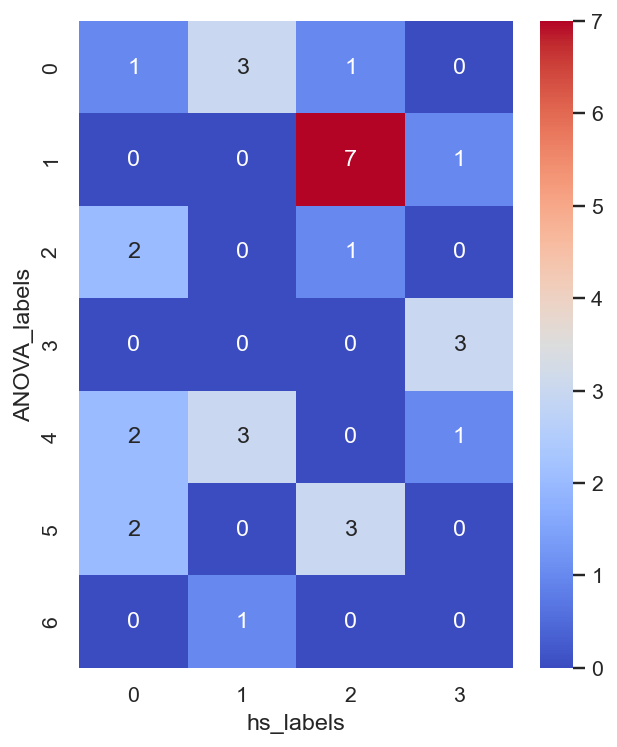

In [50]:
plt.figure(figsize=(5, 6), dpi=70)
sns.set(font_scale=1)
sns.heatmap(pivot_labels_inter, annot=True, cmap = 'coolwarm', fmt=".0f")
plt.grid(False)

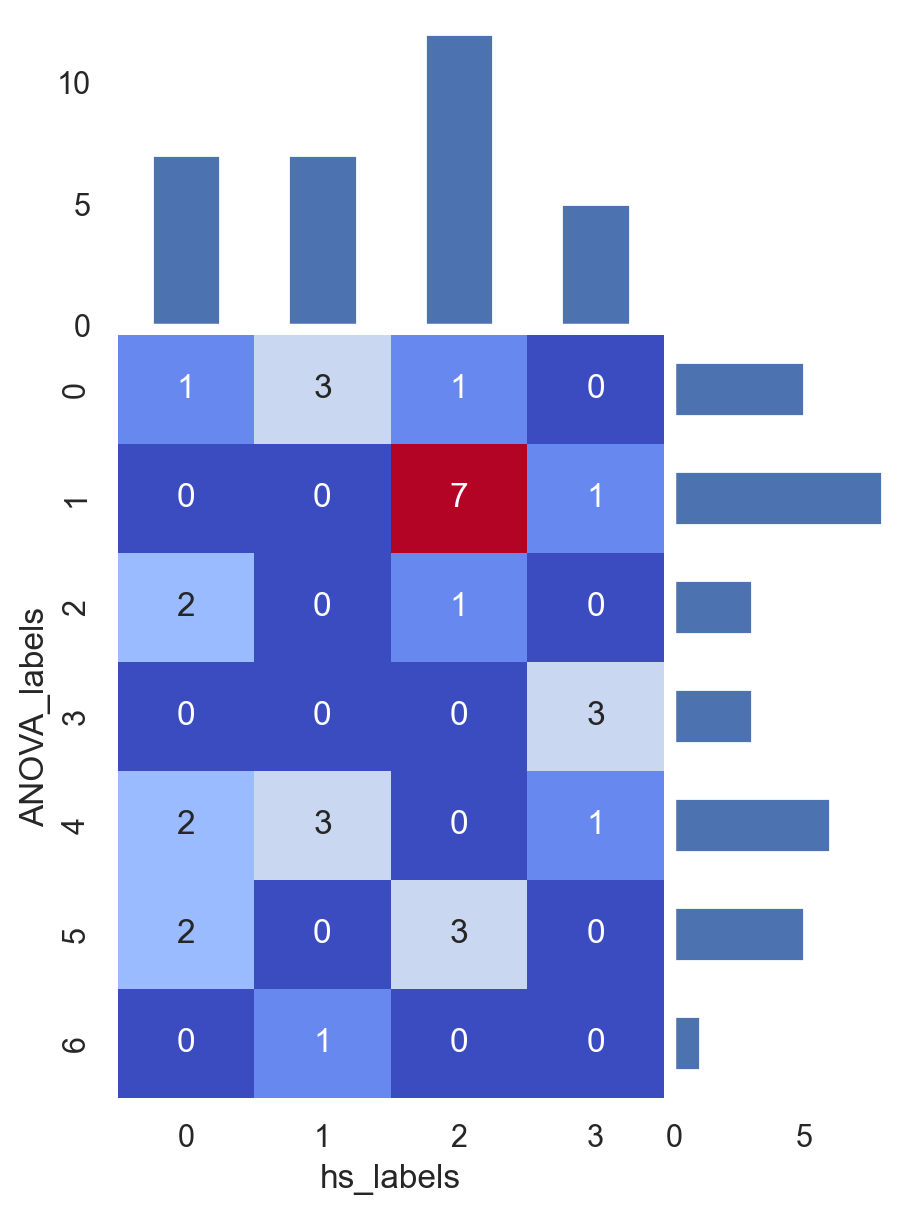

In [51]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
fig, ax = plt.subplots(figsize=(5, 7))
sns.heatmap(pivot_labels_inter, annot=True, cmap = 'coolwarm', fmt=".0f", ax=ax, cbar=False)


divider = make_axes_locatable(ax)
cax = divider.append_axes('top', size='40%', pad=0.05)
pivot_labels_inter.sum(axis=0).plot.bar(ax=cax)
cax.set_facecolor(color='white')
cax.get_xaxis().set_visible(False)

cax = divider.append_axes('right', size='40%', pad=0.05)
index_order = pivot_labels_inter.index[::-1]
pivot_labels_inter.sum(axis=1).loc[index_order].plot.barh(ax=cax)
cax.set_facecolor(color='white')
cax.get_yaxis().set_visible(False)

# Functional analysis

In [52]:
gene_clust = list()
enrich_results = list()

for label in tqdm(sorted(labels.unique())):
    genes = labels[labels == label].index.tolist()
    descr = f'Genes for spectral clustering ({n_clusters} clusters) of human-specific genes. Cluster label: {label}'
    gene_clust.append(GeneCluster(genes, descr, label, background_genes))
    time.sleep(1)

  0%|          | 0/4 [00:00<?, ?it/s]

## GO_Biological_Process_2021

In [53]:
db_name = 'GO_Biological_Process_2021'
GeneCluster.enrich_geneclusters(gene_clust,db_name )

In [54]:
enrich_res = pd.concat([gc.enrichment_res[db_name] for gc in gene_clust])
enrich_res = enrich_res.set_index(['Term'])
enrich_res.head()

Rank     p-val  Z-score  \
Term                                                                          
positive regulation of endocytic recycling (GO:...     1  0.000004   2152.8   
response to magnesium ion (GO:0032026)                 2  0.000004   2152.8   
positive regulation of cation transmembrane tra...     3  0.000022    537.9   
regulation of endocytic recycling (GO:2001135)         4  0.000022    537.9   
positive regulation of cation channel activity ...     5  0.000052    307.2   

                                                    Combined score  \
Term                                                                 
positive regulation of endocytic recycling (GO:...    26584.551498   
response to magnesium ion (GO:0032026)                26584.551498   
positive regulation of cation transmembrane tra...     5777.705859   
regulation of endocytic recycling (GO:2001135)         5777.705859   
positive regulation of cation channel activity ...     3031.328746   

                                                   Overlapping genes  \
Term                                                                   
positive regulation of endocytic recycling (GO:...    [ACTN2, SORL1]   
response to magnesium ion (GO:0032026)                 [ANK3, THBS1]   
positive regulation of cation transmembrane tra...     [ACTN2, ANK3]   
regulation of endocytic recycling (GO:2001135)        [ACTN2, SORL1]   
positive regulation of cation channel activity ...     [ACTN2, ANK3]   

                                                    Adjusted P-value  \
Term                                                                   
positive regulation of endocytic recycling (GO:...          0.000683   
response to magnesium ion (GO:0032026)                      0.000683   
positive regulation of cation transmembrane tra...          0.001704   
regulation of endocytic recycling (GO:2001135)              0.001704   
positive regulation of cation channel activity ...          0.003265   

                                                    Old p-value  \
Term                                                              
positive regulation of endocytic recycling (GO:...            0   
response to magnesium ion (GO:0032026)                        0   
positive regulation of cation transmembrane tra...            0   
regulation of endocytic recycling (GO:2001135)                0   
positive regulation of cation channel activity ...            0   

                                                    Old adjusted p-value  \
Term                                                                       
positive regulation of endocytic recycling (GO:...                     0   
response to magnesium ion (GO:0032026)                                 0   
positive regulation of cation transmembrane tra...                     0   
regulation of endocytic recycling (GO:2001135)                         0   
positive regulation of cation channel activity ...                     0   

                                                    num_overlap_genes  \
Term                                                                    
positive regulation of endocytic recycling (GO:...                  2   
response to magnesium ion (GO:0032026)                              2   
positive regulation of cation transmembrane tra...                  2   
regulation of endocytic recycling (GO:2001135)                      2   
positive regulation of cation channel activity ...                  2   

                                                    neg_log10(p_adj)  \
Term                                                                   
positive regulation of endocytic recycling (GO:...          3.165746   
response to magnesium ion (GO:0032026)                      3.165746   
positive regulation of cation transmembrane tra...          2.768605   
regulation of endocytic recycling (GO:2001135)              2.768605   
positive regulation of cation channel activity ...

In [55]:
terms = enrich_res[(enrich_res['Adjusted P-value'] < 0.05) & (enrich_res.Rank < 10)].index.unique()
terms.size

28

In [56]:
from pandas.api.types import CategoricalDtype
enrich_res_plot = enrich_res.loc[terms].copy()
cat_type = CategoricalDtype(categories=['No significance', 'p < 0.05', 'p < 0.01', 'p < 0.001'], ordered=True)
enrich_res_plot['p-value'] = enrich_res_plot['Adjusted P-value'].apply(p_val_group).astype(cat_type)
enrich_results.append(enrich_res_plot)

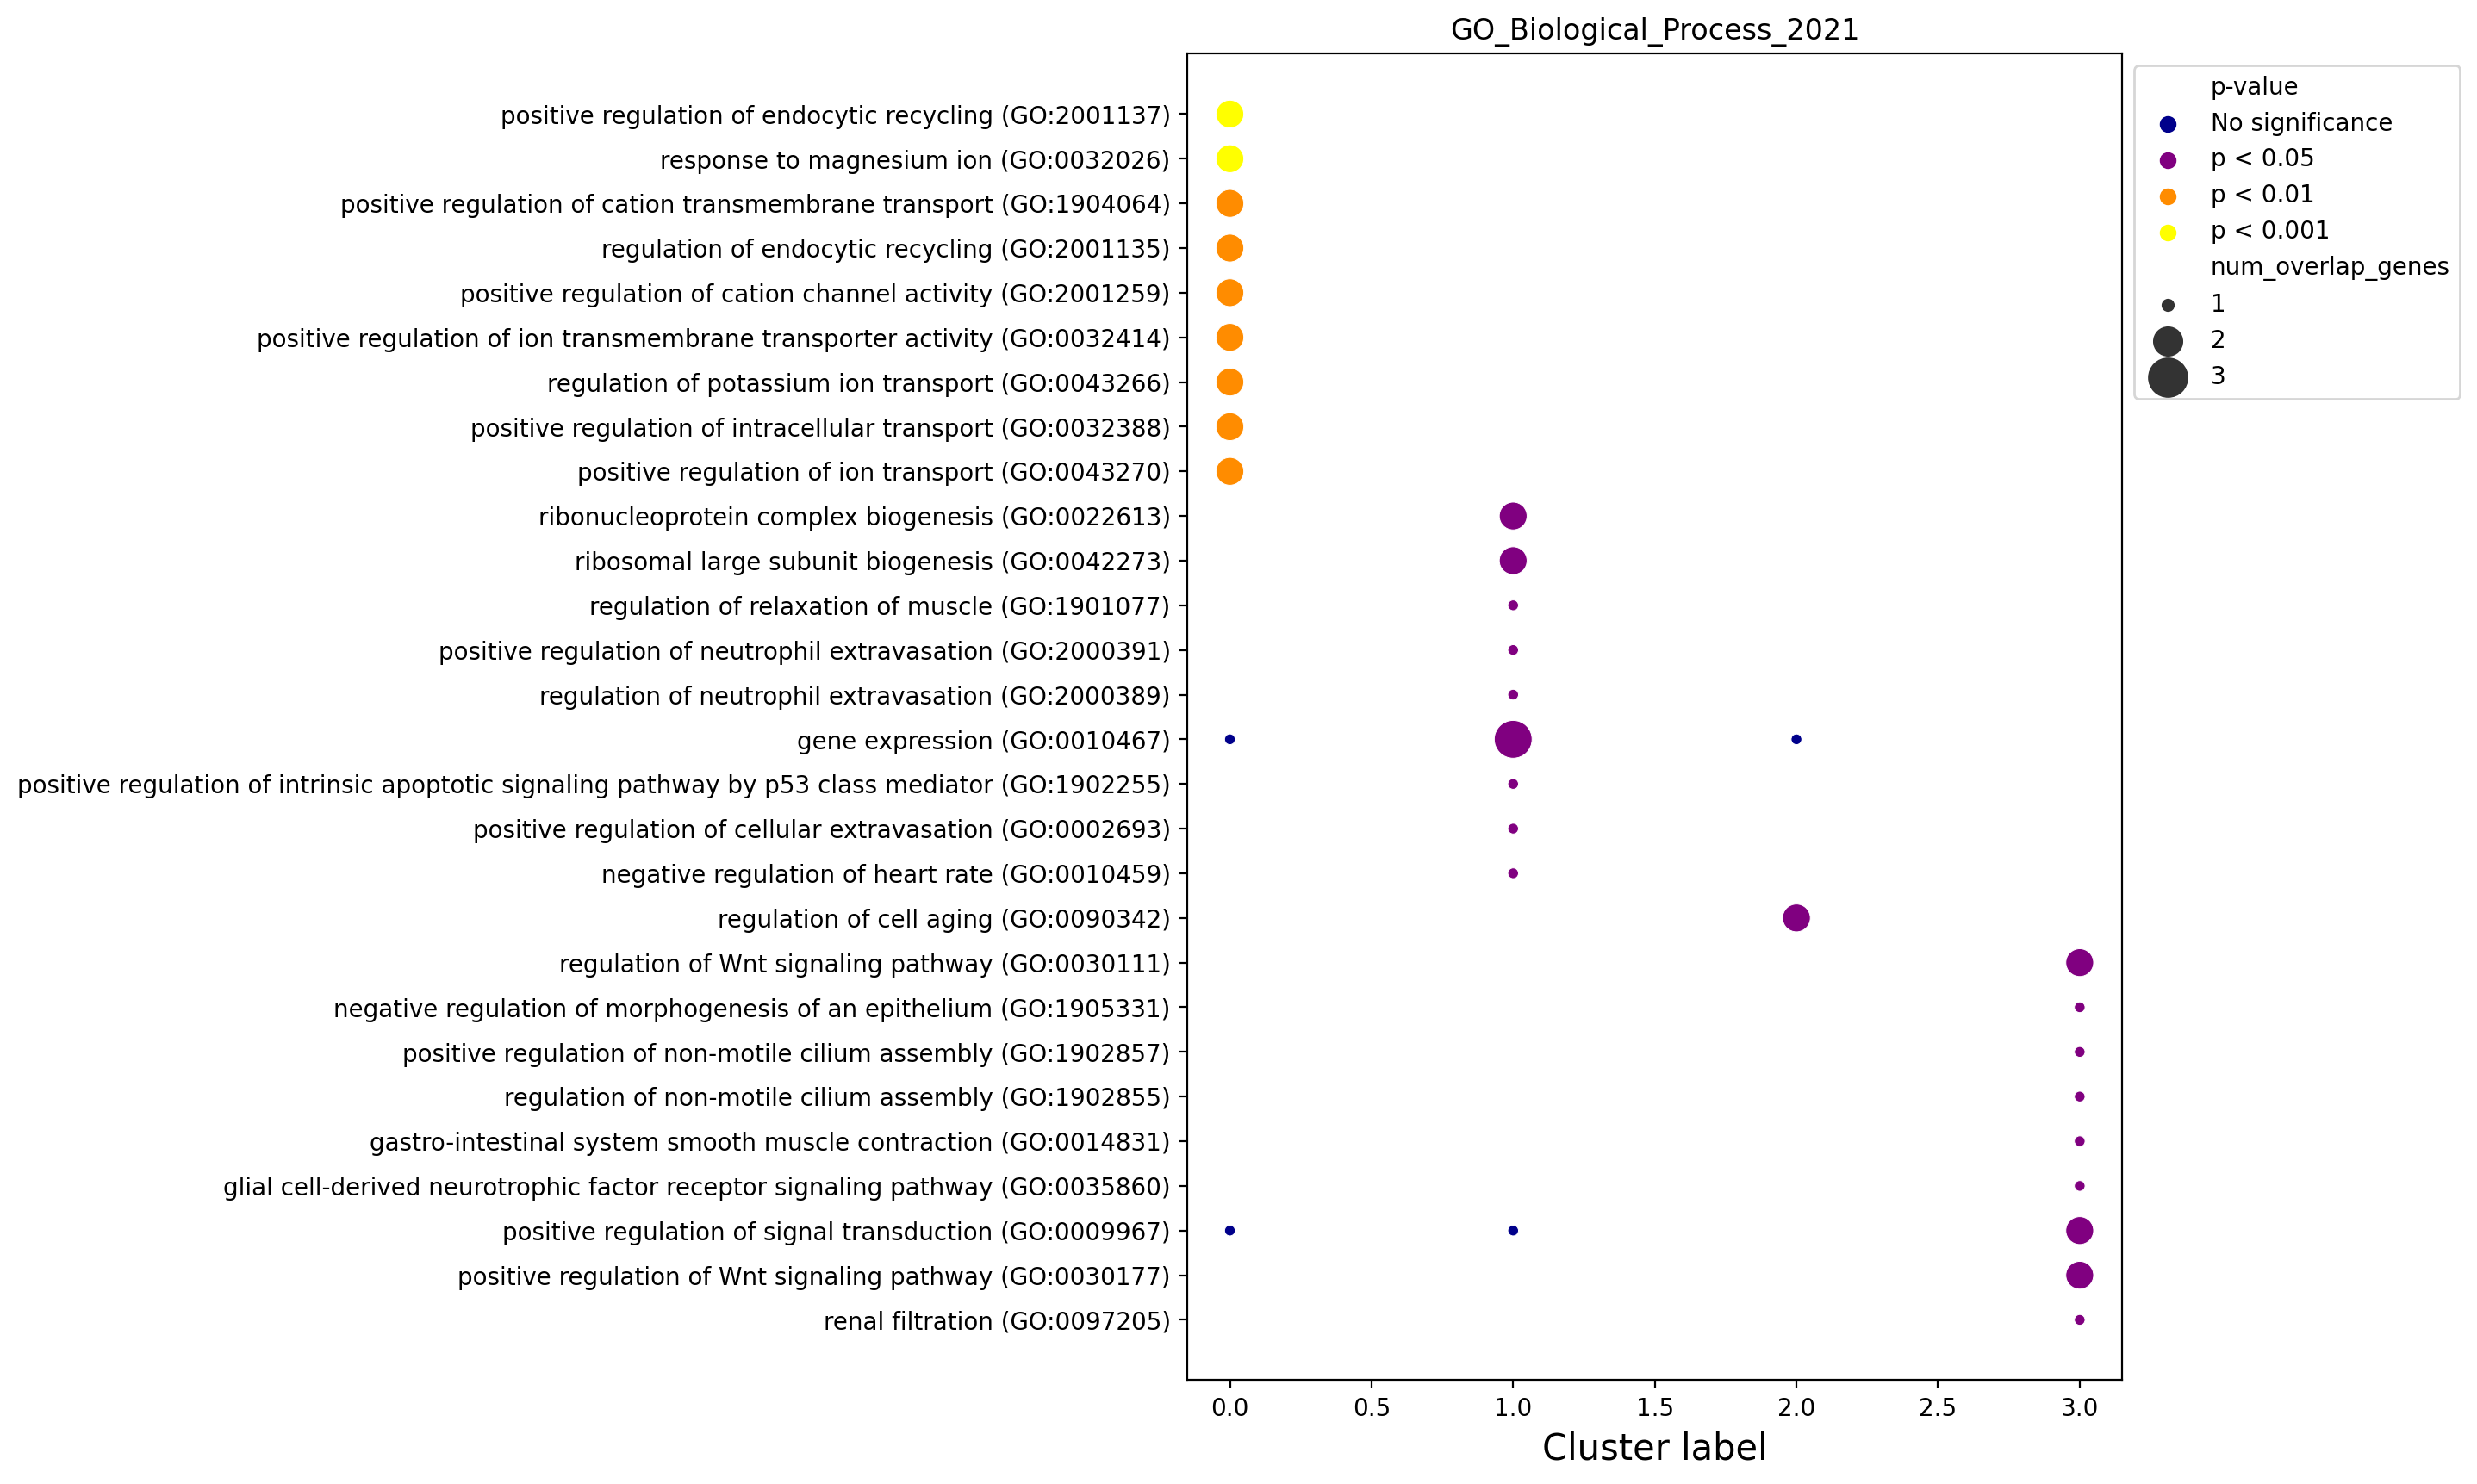

In [57]:
mpl.rcdefaults()
fig = plt.figure(figsize=(7, 10), dpi=100)

ax = sns.scatterplot(
    data=enrich_res_plot.reset_index(),
    x='cluster_label',
    y='Term',
    size='num_overlap_genes',
    sizes=(20, 250),
    hue='p-value',
    palette=color_discrete_map
)

ax.tick_params(labelsize=10)
ax.legend(fontsize=15)
ax.set_xlabel("Cluster label",fontsize=15)
ax.set_ylabel("", fontsize=10)
ax.grid(False)
ax.set_title(db_name)

sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

## Azimuth Cell Types 2021


In [58]:
db_name = 'Azimuth_Cell_Types_2021'
GeneCluster.enrich_geneclusters(gene_clust, db_name)

In [59]:
enrich_res = pd.concat([gc.enrichment_res[db_name] for gc in gene_clust])
enrich_res = enrich_res.set_index(['Term'])
enrich_res.head()

Rank     p-val     Z-score  \
Term                                                                            
OPALIN+ FTH1P3+ Layer 2-6 Oligodendrocyte CL000...    1  0.002596  897.000000   
OPALIN+ LDLRAP1+ Layer 5-6 Oligodendrocyte CL00...    2  0.002596  897.000000   
VIP+ SLC6A16+ Layer 2 GABAergic Neuron CL0000617      3  0.002596  897.000000   
Vip+ GABAergic Neuron 2 CL0000617                     4  0.003892  448.416667   
VIP+ SCML4+ Layer 1-2 GABAergic Neuron CL0000617      5  0.003892  448.416667   

                                                    Combined score  \
Term                                                                 
OPALIN+ FTH1P3+ Layer 2-6 Oligodendrocyte CL000...     5340.573960   
OPALIN+ LDLRAP1+ Layer 5-6 Oligodendrocyte CL00...     5340.573960   
VIP+ SLC6A16+ Layer 2 GABAergic Neuron CL0000617       5340.573960   
Vip+ GABAergic Neuron 2 CL0000617                      2488.222216   
VIP+ SCML4+ Layer 1-2 GABAergic Neuron CL0000617       2488.222216   

                                                   Overlapping genes  \
Term                                                                   
OPALIN+ FTH1P3+ Layer 2-6 Oligodendrocyte CL000...            [ANK3]   
OPALIN+ LDLRAP1+ Layer 5-6 Oligodendrocyte CL00...            [ANK3]   
VIP+ SLC6A16+ Layer 2 GABAergic Neuron CL0000617             [CALB2]   
Vip+ GABAergic Neuron 2 CL0000617                            [CALB2]   
VIP+ SCML4+ Layer 1-2 GABAergic Neuron CL0000617             [CALB2]   

                                                    Adjusted P-value  \
Term                                                                   
OPALIN+ FTH1P3+ Layer 2-6 Oligodendrocyte CL000...          0.005834   
OPALIN+ LDLRAP1+ Layer 5-6 Oligodendrocyte CL00...          0.005834   
VIP+ SLC6A16+ Layer 2 GABAergic Neuron CL0000617            0.005834   
Vip+ GABAergic Neuron 2 CL0000617                           0.005834   
VIP+ SCML4+ Layer 1-2 GABAergic Neuron CL0000617            0.005834   

                                                   Old p-value  \
Term                                                             
OPALIN+ FTH1P3+ Layer 2-6 Oligodendrocyte CL000...           0   
OPALIN+ LDLRAP1+ Layer 5-6 Oligodendrocyte CL00...           0   
VIP+ SLC6A16+ Layer 2 GABAergic Neuron CL0000617             0   
Vip+ GABAergic Neuron 2 CL0000617                            0   
VIP+ SCML4+ Layer 1-2 GABAergic Neuron CL0000617             0   

                                                   Old adjusted p-value  \
Term                                                                      
OPALIN+ FTH1P3+ Layer 2-6 Oligodendrocyte CL000...                    0   
OPALIN+ LDLRAP1+ Layer 5-6 Oligodendrocyte CL00...                    0   
VIP+ SLC6A16+ Layer 2 GABAergic Neuron CL0000617                      0   
Vip+ GABAergic Neuron 2 CL0000617                                     0   
VIP+ SCML4+ Layer 1-2 GABAergic Neuron CL0000617                      0   

                                                   num_overlap_genes  \
Term                                                                   
OPALIN+ FTH1P3+ Layer 2-6 Oligodendrocyte CL000...                 1   
OPALIN+ LDLRAP1+ Layer 5-6 Oligodendrocyte CL00...                 1   
VIP+ SLC6A16+ Layer 2 GABAergic Neuron CL0000617                   1   
Vip+ GABAergic Neuron 2 CL0000617                                  1   
VIP+ SCML4+ Layer 1-2 GABAergic Neuron CL0000617                   1   

                                                    neg_log10(p_adj)  \
Term                                                                   
OPALIN+ FTH1P3+ Layer 2-6 Oligodendrocyte CL000...          2.234009   
OPALIN+ LDLRAP1+ Layer 5-6 Oligodendrocyte CL00...          2.234009   
VIP+ SLC6A16+ Layer 2 GABAergic Neuron CL0000617            2.234009   
Vip+ GABAergic Neuron 2 CL0000617                           2.234009   
VIP+ SCML4+ Layer 1-2 GABAergic Neuron CL0000617        

In [60]:
terms = enrich_res[(enrich_res['Adjusted P-value'] < 0.05) & (enrich_res.Rank < 10)].index.unique()
terms.size

14

In [61]:
from pandas.api.types import CategoricalDtype
enrich_res_plot = enrich_res.loc[terms].copy()
cat_type = CategoricalDtype(categories=['No significance', 'p < 0.05', 'p < 0.01', 'p < 0.001'], ordered=True)
enrich_res_plot['p-value'] = enrich_res_plot['Adjusted P-value'].apply(p_val_group).astype(cat_type)
enrich_results.append(enrich_res_plot)

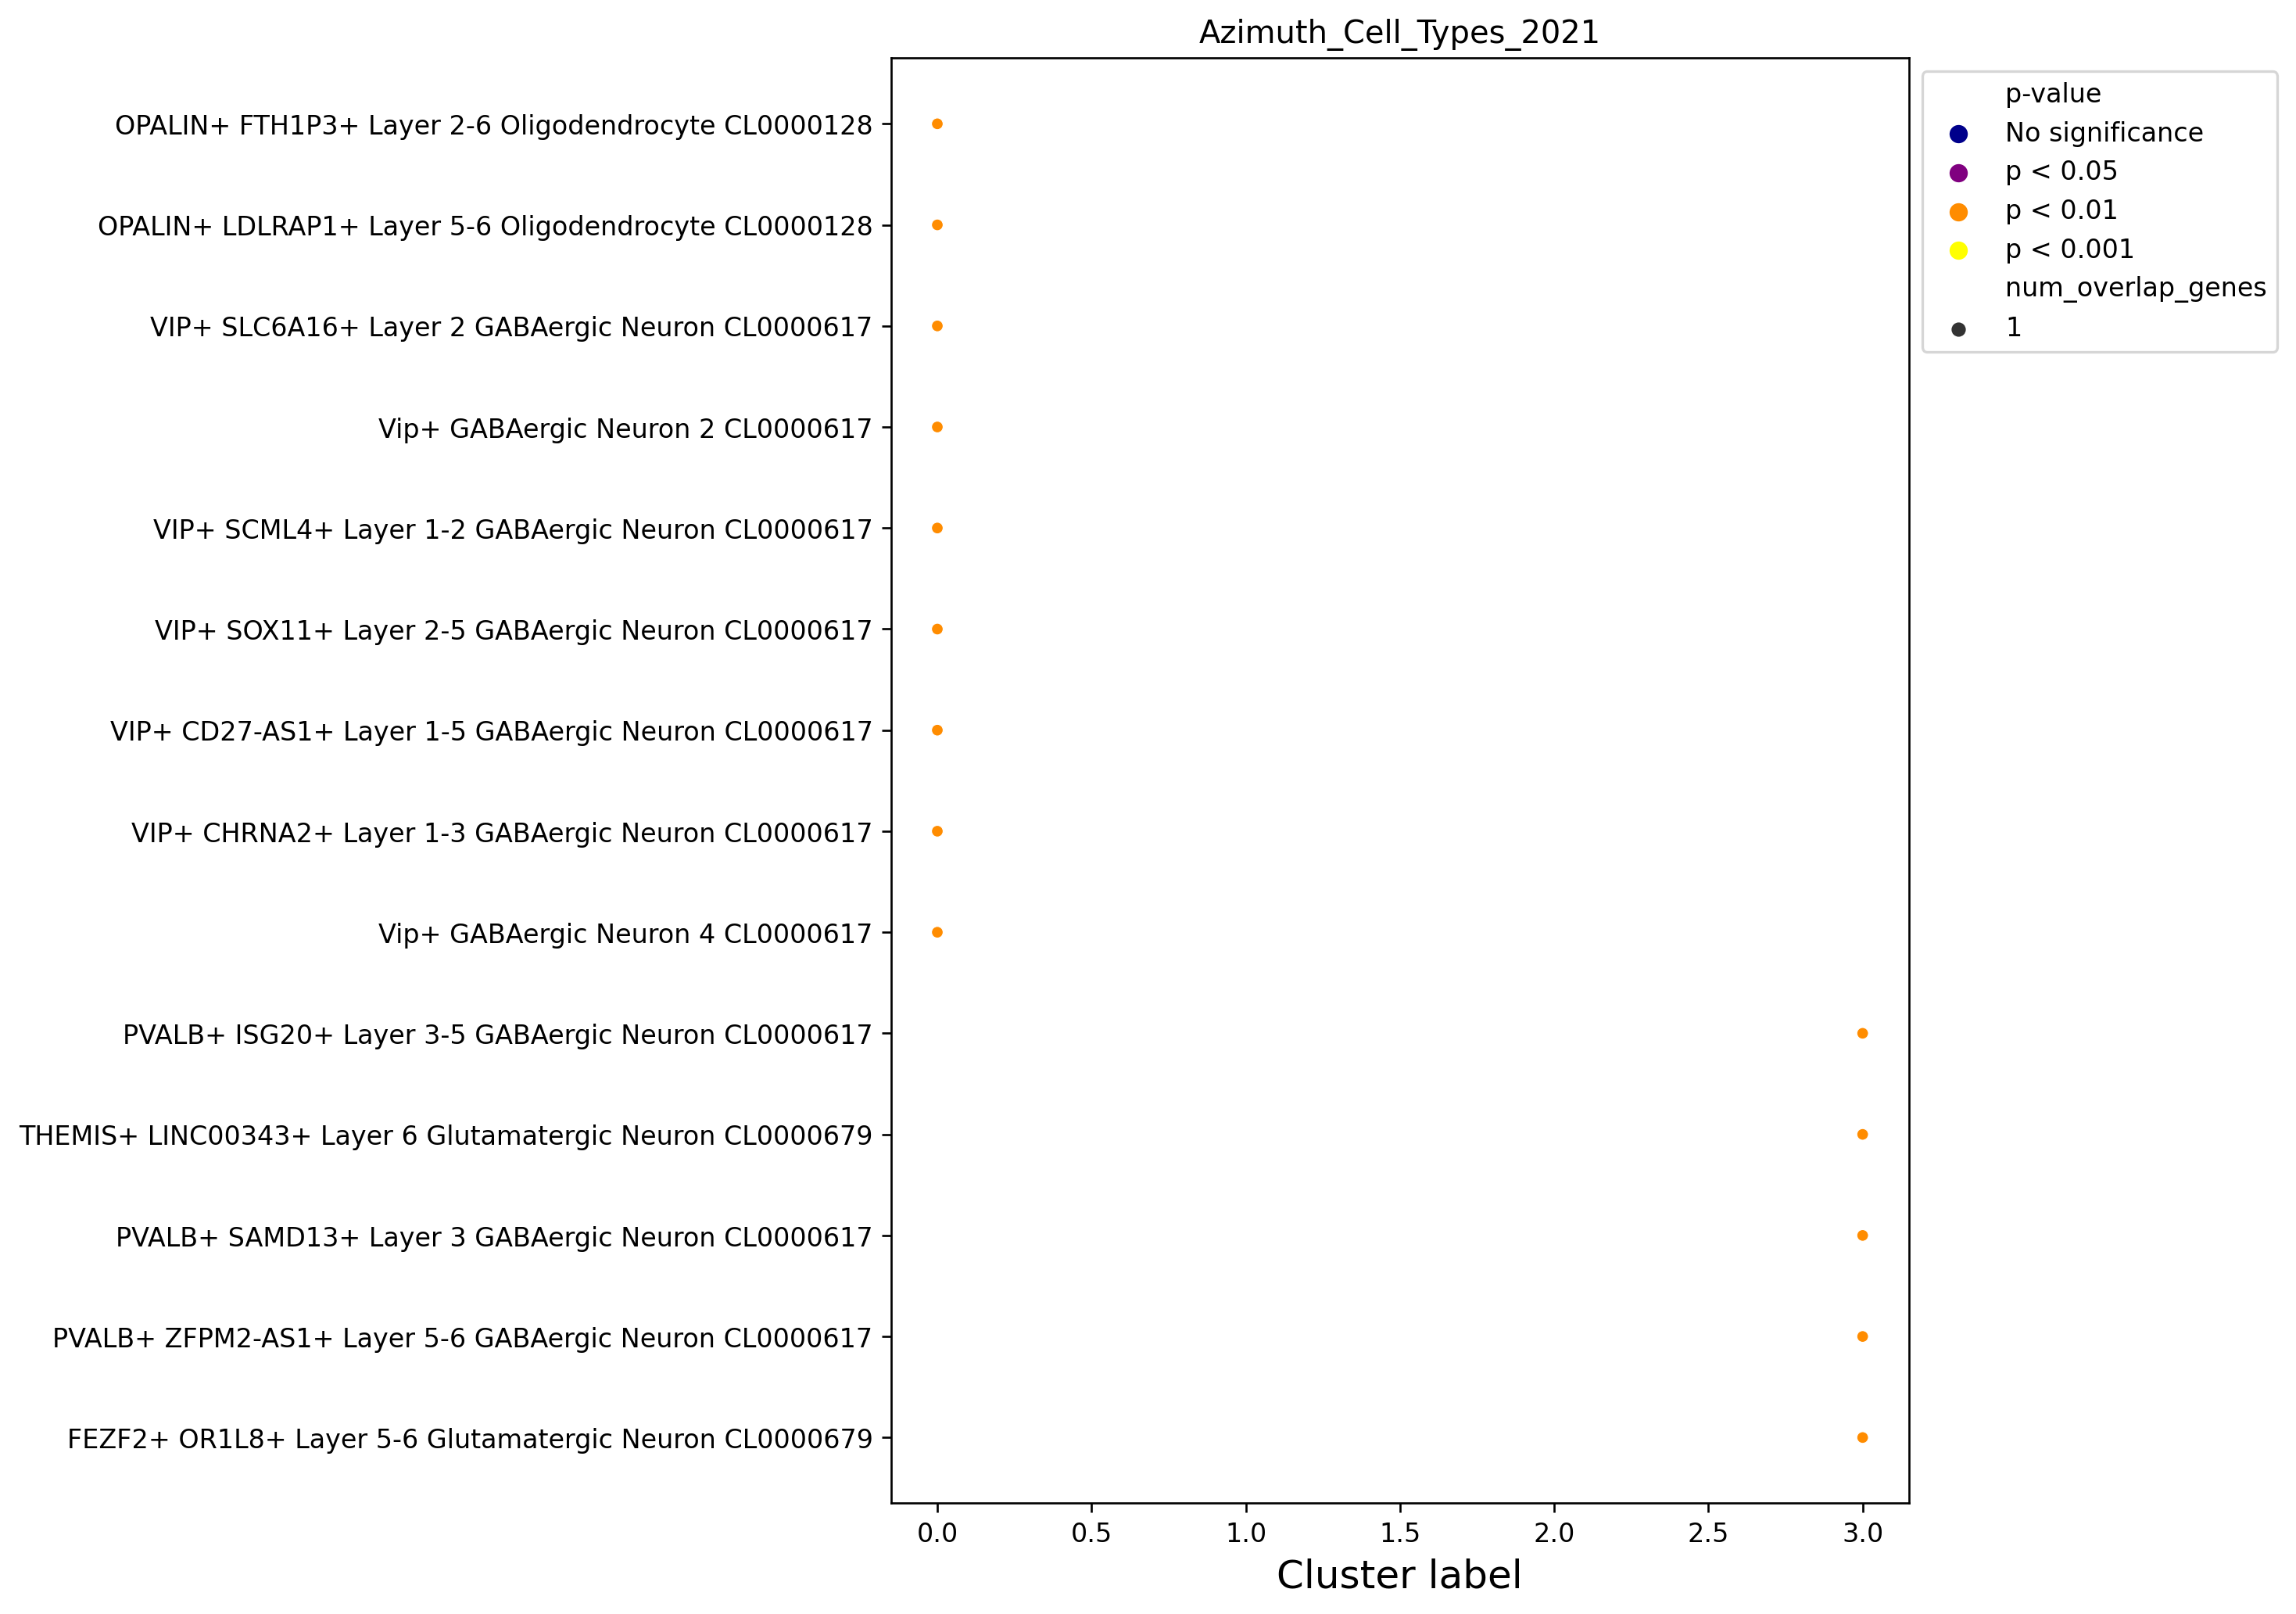

In [62]:
mpl.rcdefaults()
fig = plt.figure(figsize=(7, 10), dpi=120)

ax = sns.scatterplot(
    data=enrich_res_plot.reset_index(),
    x='cluster_label',
    y='Term',
    size='num_overlap_genes',
    sizes=(20, 250),
    hue='p-value',
    palette=color_discrete_map
)

ax.tick_params(labelsize=10)
ax.legend(fontsize=15)
ax.set_xlabel("Cluster label",fontsize=15)
ax.set_ylabel("", fontsize=10)
ax.grid(False)
ax.set_title(db_name)

sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

## Cell types from MTG

In [63]:
# load celltypes from DOI: 10.1126/science.ade9516
cell_types_df = pd.read_csv('results/constypes.csv')
# Replace incorrect cell-type name
cell_types_df.cluster.replace({'L56ITCar31': 'L6ITCar31', 'L56ITCar32': 'L6ITCar32'}, inplace=True)

In [64]:
# load celltype information from DOI: 10.1126/science.ade9516
cell_type_colors = pd.read_csv('results/colors.csv', index_col=2)
cell_type_colors = cell_type_colors['subclass_color']
# replace all non-matching symbols
cell_type_colors.index = cell_type_colors.index.str.replace(' ', '').str.replace('_', '').str.replace('/', '').str.replace('-', '')

<Axes: xlabel='count', ylabel='cluster'>

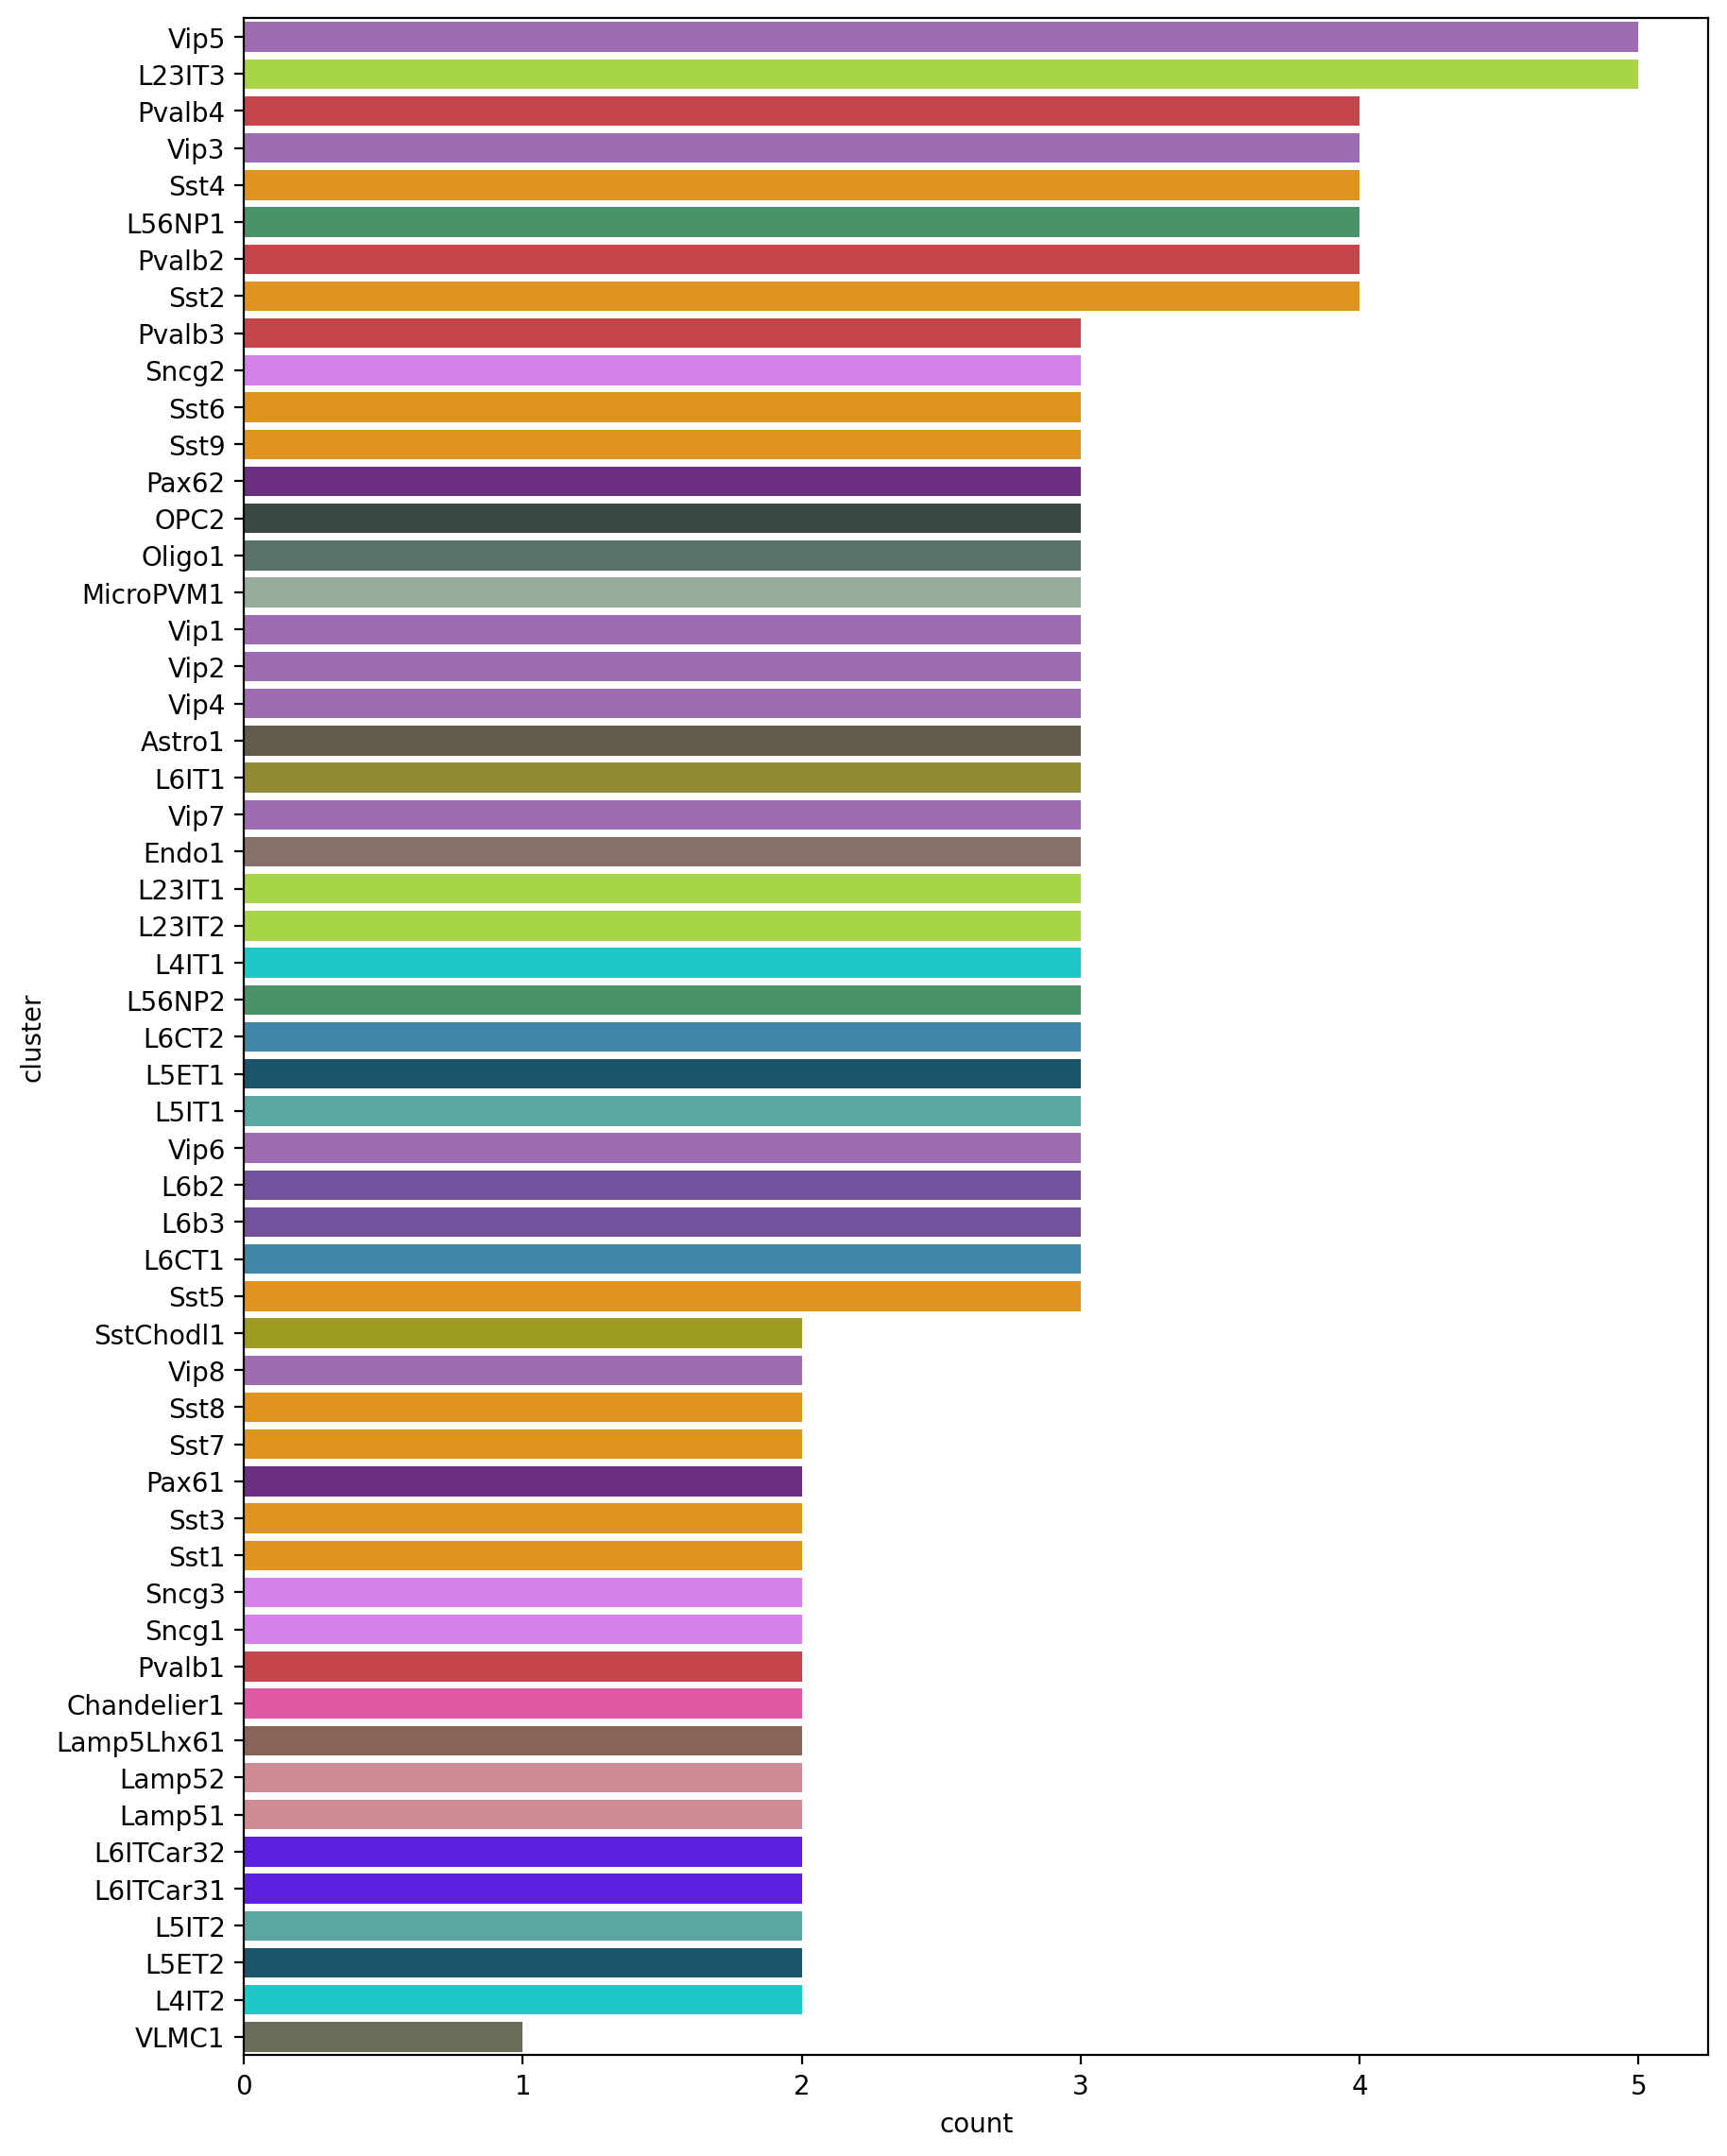

In [65]:
fig, axes = plt.subplots(figsize=(10, 14))
cell_types_df_hum = cell_types_df[(cell_types_df.species == 'chimp') & (cell_types_df.log2FoldChange.abs() > 3)]
count_df = cell_types_df_hum[(cell_types_df_hum.gene.isin(cs_genes))].cluster.value_counts()
cell_type_colors_pal = cell_type_colors.to_dict()
sns.barplot(count_df.to_frame().reset_index(), y='cluster', x='count', ax=axes, palette=cell_type_colors_pal)

In [66]:
index = cell_types_df_hum.cluster.unique()
cluster_celltype = pd.DataFrame(index=index)

for label in sorted(labels.unique()):
    genes = labels[labels == label].index.tolist()
    counts = cell_types_df_hum[cell_types_df_hum.gene.isin(genes)].cluster.value_counts(sort=False)
    cluster_celltype[f'cluster {label}'] = 0
    cluster_celltype.loc[counts.index, f'cluster {label}'] = counts
cluster_celltype.head()

cluster 0  cluster 1  cluster 2  cluster 3
Astro1               0          2          1          0
Chandelier1          0          1          1          0
Endo1                0          2          1          0
L23IT1               0          2          1          0
L23IT2               1          1          1          0

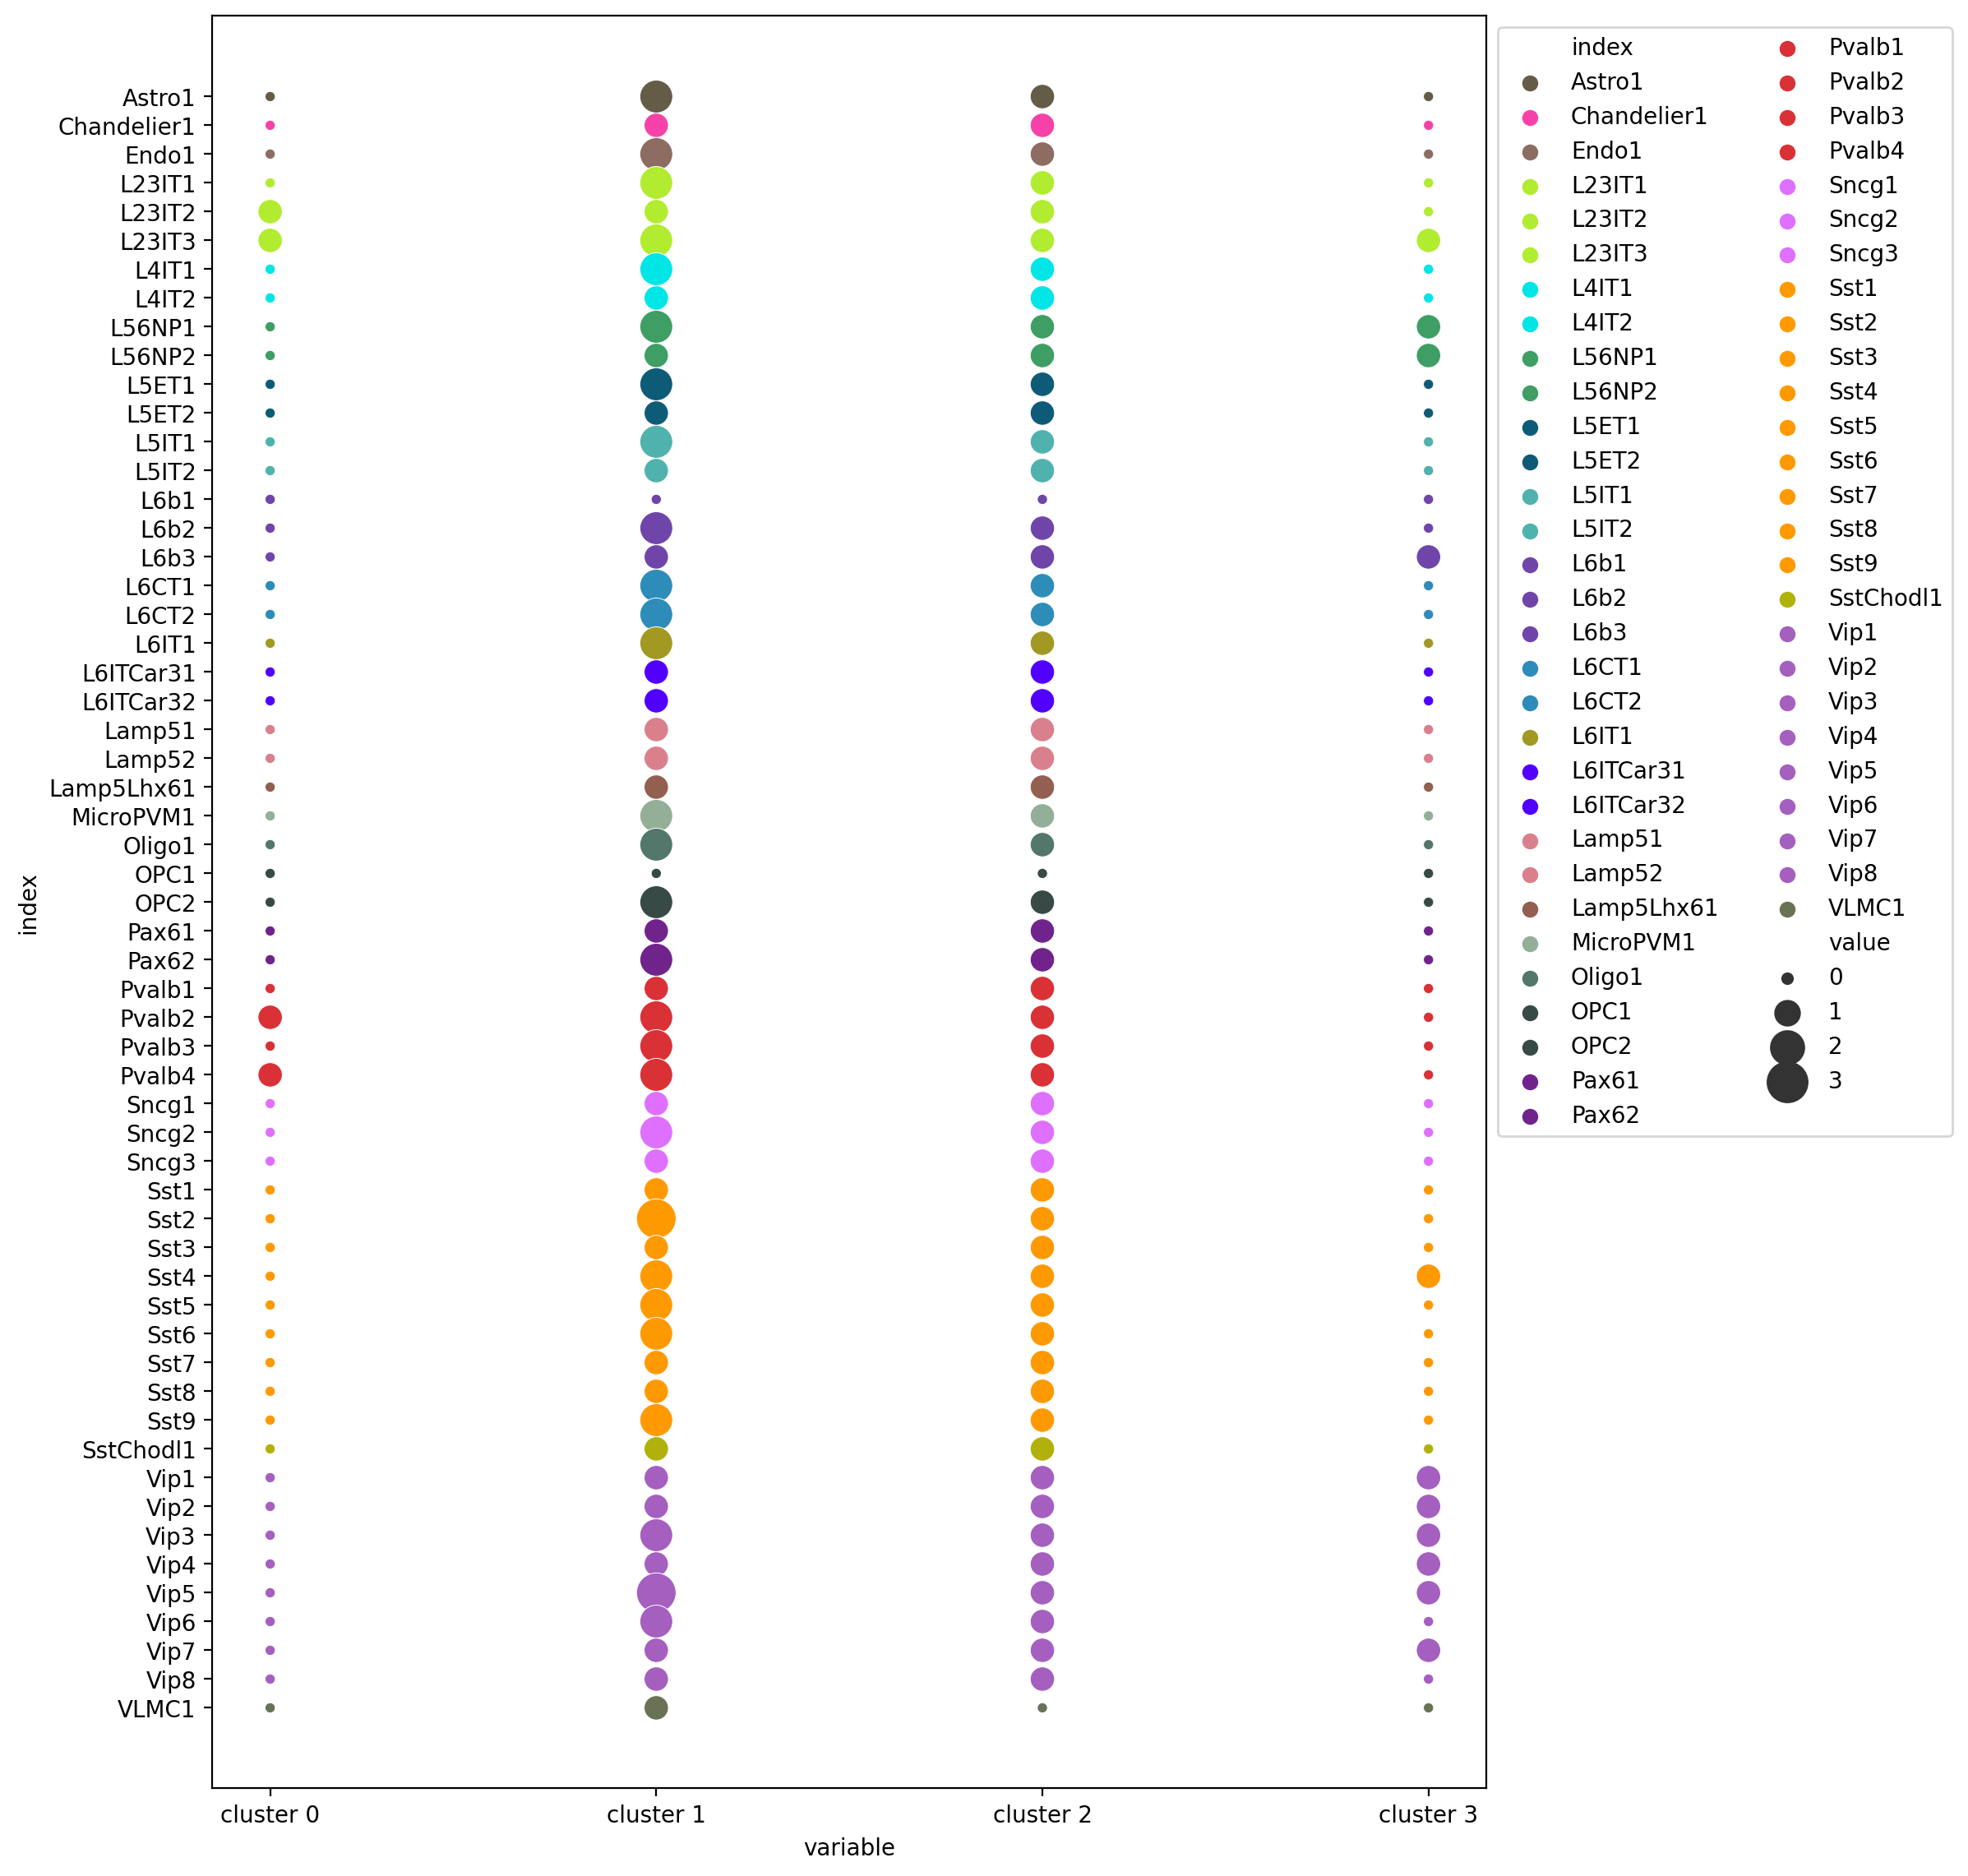

In [67]:
fig, axes = plt.subplots(figsize=(10, 14))
cell_type_count = cluster_celltype.reset_index().melt(id_vars=['index'], value_vars=cluster_celltype.columns)
sns.scatterplot(cell_type_count,
                y='index',
                x='variable',
                size='value',
                palette=cell_type_colors_pal,
                hue='index',
                sizes=(20, 300))
axes.legend(ncols=2, loc="upper left", bbox_to_anchor=(1, 1))
#sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

In [68]:
import gseapy
#gseapy.get_library_name()

In [69]:
def enrich_genes(gene_list, gene_sets, label):
    results = gseapy.enrich(gene_list=gene_list, # or gene_list=glist
                           gene_sets=gene_sets, # kegg is a dict object
                           background=background_genes, # or "hsapiens_gene_ensembl", or int, or text file, or a list of genes
                           outdir=None,
                           verbose=True).results
    results[f'cluster_label'] = label
    results['num_overlap_genes'] = results.Overlap.apply(lambda x: x.split('/')[0]).astype(int)
    return results

In [70]:
cell_types_genes = cell_types_df_hum.groupby('cluster').gene.apply(lambda x: list(x)).to_dict()

# check if calculated correctly
assert(cell_types_genes['Astro1'] == cell_types_df_hum[cell_types_df_hum.cluster == 'Astro1'].gene.to_list())

In [71]:
results = gseapy.enrich(gene_list=labels.index.to_list(), # or gene_list=glist
                           gene_sets=cell_types_genes, # kegg is a dict object
                           background=background_genes, # or "hsapiens_gene_ensembl", or int, or text file, or a list of genes
                           outdir=None,
                           verbose=True).results

2023-12-07 22:35:49,288 [INFO] Input dict object named with gs_ind_0
2023-12-07 22:35:49,290 [INFO] Run: gs_ind_0 
2023-12-07 22:35:49,310 [INFO] Done.


In [72]:
#gseapy.dotplot(results, title='Cell types',cmap='viridis_r', size=20, figsize=(5, 7))

In [73]:
enrich_res = pd.concat([enrich_genes(labels[labels == label].index.tolist(), cell_types_genes, label) for label in range(n_clusters)])
enrich_res = enrich_res.set_index(['Term'])
enrich_res.head()

2023-12-07 22:35:49,336 [INFO] Input dict object named with gs_ind_0
2023-12-07 22:35:49,337 [INFO] Run: gs_ind_0 
2023-12-07 22:35:49,347 [INFO] Done.
2023-12-07 22:35:49,349 [INFO] Input dict object named with gs_ind_0
2023-12-07 22:35:49,350 [INFO] Run: gs_ind_0 
2023-12-07 22:35:49,373 [INFO] Done.
2023-12-07 22:35:49,375 [INFO] Input dict object named with gs_ind_0
2023-12-07 22:35:49,376 [INFO] Run: gs_ind_0 
2023-12-07 22:35:49,391 [INFO] Done.
2023-12-07 22:35:49,394 [INFO] Input dict object named with gs_ind_0
2023-12-07 22:35:49,395 [INFO] Run: gs_ind_0 
2023-12-07 22:35:49,405 [INFO] Done.


Gene_set Overlap   P-value  Adjusted P-value  Odds Ratio  \
Term                                                               
L23IT2  gs_ind_0   1/154  0.183744          0.202126    7.821509   
L23IT3  gs_ind_0   1/171  0.202126          0.202126    7.023324   
Pvalb2  gs_ind_0   1/129  0.156053          0.202126    9.376002   
Pvalb4  gs_ind_0   1/149  0.178269          0.202126    8.090816   
Astro1  gs_ind_0   2/125  0.013634          0.046114   16.136990   

        Combined Score      Genes  cluster_label  num_overlap_genes  
Term                                                                 
L23IT2       13.251285      CALB2              0                  1  
L23IT3       11.229334      THBS1              0                  1  
Pvalb2       17.416490      CALB2              0                  1  
Pvalb4       13.952296      THBS1              0                  1  
Astro1       69.311828  RPL26;FAU              1                  2

In [74]:
terms = enrich_res[(enrich_res['Adjusted P-value'] < 0.05)].index.unique()
terms.size

28

In [75]:
from pandas.api.types import CategoricalDtype
enrich_res_plot = enrich_res.loc[terms].copy()
cat_type = CategoricalDtype(categories=['No significance', 'p < 0.05', 'p < 0.01', 'p < 0.001'], ordered=True)
enrich_res_plot['p-value'] = enrich_res_plot['Adjusted P-value'].apply(p_val_group).astype(cat_type)
enrich_results.append(enrich_res_plot)

In [76]:
enrich_res[enrich_res.cluster_label == 1]

Gene_set Overlap   P-value  Adjusted P-value  Odds Ratio  \
Term                                                                    
Astro1       gs_ind_0   2/125  0.013634          0.046114   16.136990   
Chandelier1  gs_ind_0   1/147  0.198570          0.218678    7.109831   
Endo1        gs_ind_0    2/88  0.006923          0.046114   23.044329   
L23IT1       gs_ind_0   2/158  0.021288          0.046114   12.697161   
L23IT2       gs_ind_0   1/154  0.207096          0.218678    6.778641   
L23IT3       gs_ind_0   2/171  0.024706          0.048529   11.705539   
L4IT1        gs_ind_0   2/154  0.020281          0.046114   13.035848   
L4IT2        gs_ind_0   1/157  0.210726          0.218678    6.645714   
L56NP1       gs_ind_0   2/142  0.017389          0.046114   14.165992   
L56NP2       gs_ind_0   1/154  0.207096          0.218678    6.778641   
L5ET1        gs_ind_0   2/126  0.013843          0.046114   16.006385   
L5ET2        gs_ind_0   1/112  0.154727          0.218678    9.384000   
L5IT1        gs_ind_0   2/157  0.021034          0.046114   12.780220   
L5IT2        gs_ind_0   1/151  0.203452          0.218678    6.916832   
L6CT1        gs_ind_0   2/158  0.021288          0.046114   12.697161   
L6CT2        gs_ind_0   2/149  0.019052          0.046114   13.484693   
L6IT1        gs_ind_0   2/160  0.021799          0.046114   12.534148   
L6ITCar31    gs_ind_0   1/167  0.222719          0.222719    6.237015   
L6ITCar32    gs_ind_0   1/154  0.207096          0.218678    6.778641   
L6b2         gs_ind_0   2/156  0.020782          0.046114   12.864340   
L6b3         gs_ind_0   1/104  0.144416          0.218678   10.117703   
Lamp51       gs_ind_0   1/146  0.197346          0.218678    7.159727   
Lamp52       gs_ind_0   1/138  0.187491          0.218678    7.584838   
Lamp5Lhx61   gs_ind_0   1/149  0.201014          0.218678    7.012040   
MicroPVM1    gs_ind_0    2/63  0.003598          0.046114   32.268322   
OPC2         gs_ind_0   2/137  0.016242          0.046114   14.695105   
Oligo1       gs_ind_0   2/122  0.013014          0.046114   16.541601   
Pax61        gs_ind_0   1/146  0.197346          0.218678    7.159727   
Pax62        gs_ind_0   2/112  0.011042          0.046114   18.046154   
Pvalb1       gs_ind_0   1/100  0.139219          0.218678   10.528358   
Pvalb2       gs_ind_0   2/129  0.014480          0.046114   15.626671   
Pvalb3       gs_ind_0   2/164  0.022838          0.046522   12.220014   
Pvalb4       gs_ind_0   2/149  0.019052          0.046114   13.484693   
Sncg1        gs_ind_0   1/107  0.148295          0.218678    9.829767   
Sncg2        gs_ind_0   2/139  0.016697          0.046114   14.478908   
Sncg3        gs_ind_0   1/137  0.186252          0.218678    7.641455   
Sst1         gs_ind_0   1/120  0.164929          0.218678    8.747718   
Sst2         gs_ind_0   3/123  0.000597          0.032852   27.142068   
Sst3         gs_ind_0   1/126  0.172510          0.218678    8.323320   
Sst4         gs_ind_0   2/146  0.018331          0.046114   13.768706   
Sst5         gs_ind_0   2/135  0.015793          0.046114   14.917684   
Sst6         gs_ind_0   2/103  0.009394          0.046114   19.648829   
Sst7         gs_ind_0   1/130  0.177530          0.218678    8.062069   
Sst8         gs_ind_0   1/143  0.193663          0.218678    7.313589   
Sst9         gs_ind_0   2/138  0.016469          0.046114   14.586226   
SstChodl1    gs_ind_0    1/66  0.093921          0.172188   16.013534   
VLMC1        gs_ind_0    1/34  0.049395          0.093680   31.052174   
Vip1         gs_ind_0   1/150  0.202234          0.218678    6.964120   
Vip2         gs_ind_0   1/142  0.192431          0.218678    7.366316   
Vip3         gs_ind_0   2/135  0.015793          0.046114   14.917684   
Vip4         gs_ind_0   1/120  0.164929          0.218678    8.747718   
Vip5         gs_ind_0   3/157  0.001219          0.033528   21.145455   
Vip6         gs_ind_0   2/125  0.013634          0.046114   16.136990  

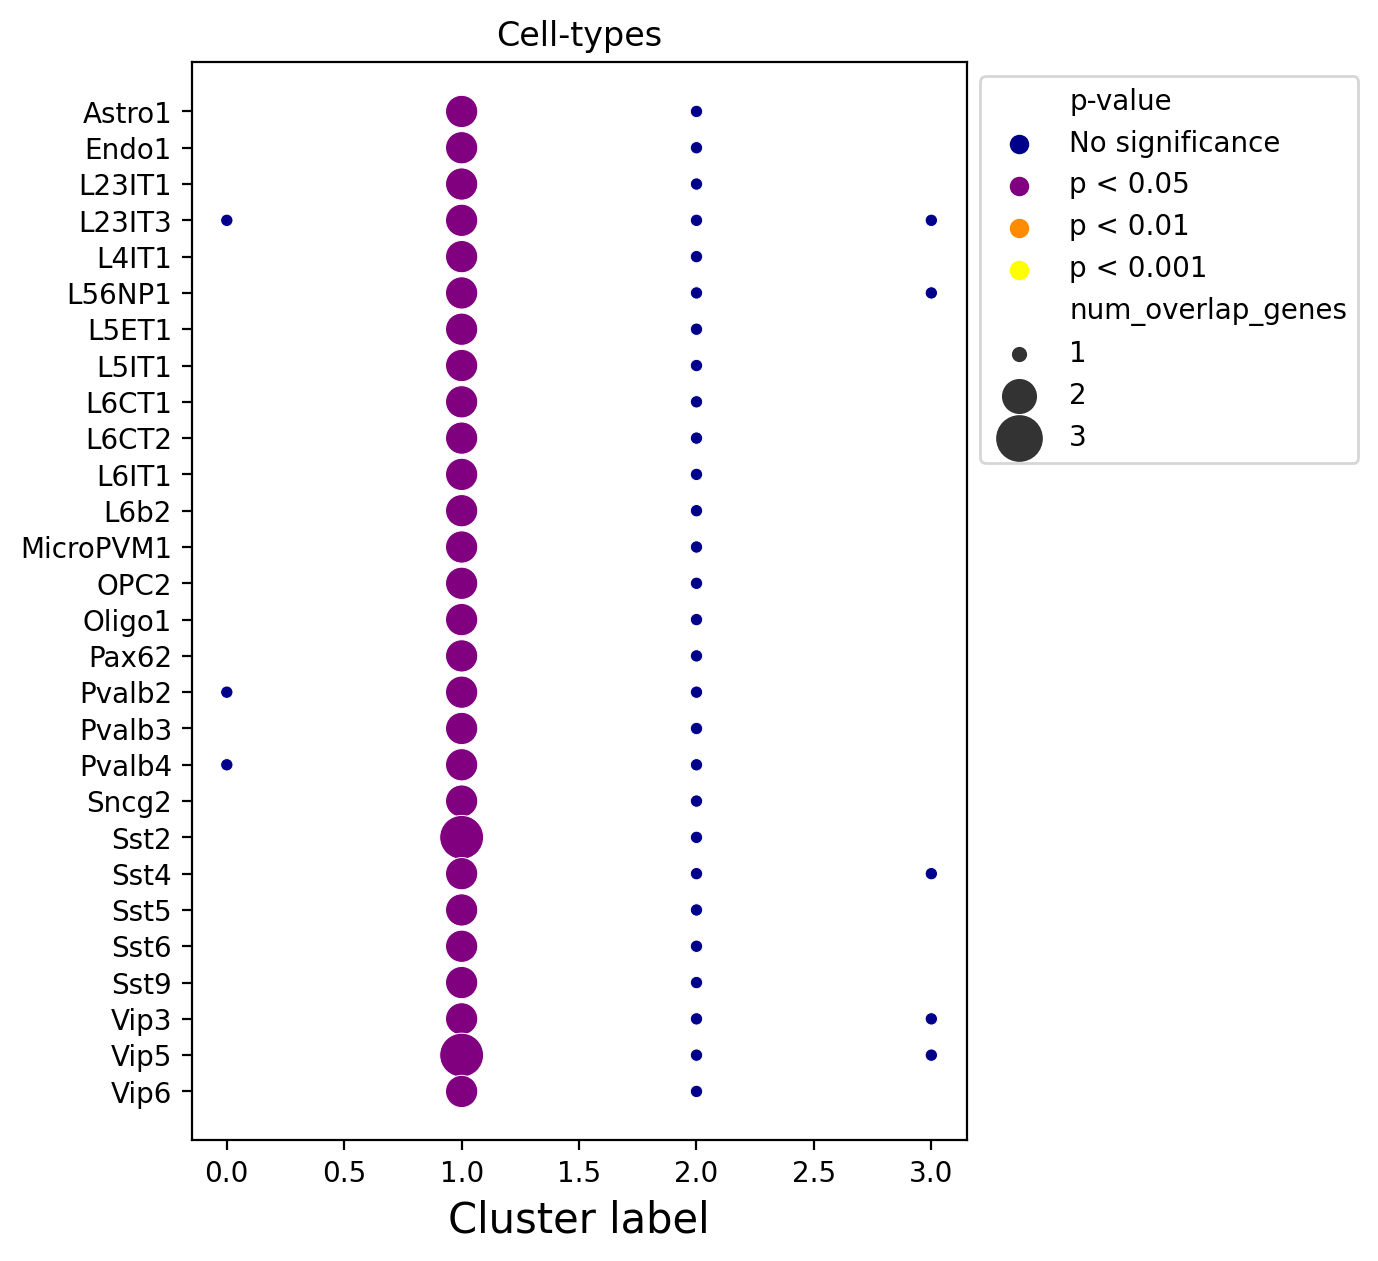

In [77]:
fig = plt.figure(figsize=(5, 7), dpi=100)

ax = sns.scatterplot(
    data=enrich_res_plot.reset_index(),
    x='cluster_label',
    y='Term',
    size='num_overlap_genes',
    sizes=(20, 250),
    hue='p-value',
    palette=color_discrete_map
)

ax.tick_params(labelsize=10)
ax.legend(fontsize=15)
ax.set_xlabel("Cluster label",fontsize=15)
ax.set_ylabel("", fontsize=10)
ax.grid(False)
ax.set_title('Cell-types')

sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

## SynGO_2022

In [78]:
db_name = 'SynGO_2022'
GeneCluster.enrich_geneclusters(gene_clust, db_name)

In [79]:
enrich_res = pd.concat([gc.enrichment_res[db_name] for gc in gene_clust])
enrich_res = enrich_res.set_index(['Term'])
enrich_res.head()

Rank     p-val     Z-score  \
Term                                                                            
Postsynaptic Density Membrane (GO:0098839) CC         1  0.002596  897.000000   
Postsynaptic Actin Cytoskeleton (GO:0098871) CC       2  0.015489   81.393939   
Postsynaptic Density, Intracellular Component (...    3  0.026971   44.691667   
Synapse (GO:0045202) CC                               4  0.168334    6.287770   
Presynaptic Ribosome CC                               1  0.001119   54.030303   

                                                    Combined score  \
Term                                                                 
Postsynaptic Density Membrane (GO:0098839) CC          5340.573960   
Postsynaptic Actin Cytoskeleton (GO:0098871) CC         339.218664   
Postsynaptic Density, Intracellular Component (...      161.471211   
Synapse (GO:0045202) CC                                  11.203571   
Presynaptic Ribosome CC                                 367.138679   

                                                   Overlapping genes  \
Term                                                                   
Postsynaptic Density Membrane (GO:0098839) CC                [ACTN2]   
Postsynaptic Actin Cytoskeleton (GO:0098871) CC              [ACTN2]   
Postsynaptic Density, Intracellular Component (...           [ACTN2]   
Synapse (GO:0045202) CC                                      [CALB2]   
Presynaptic Ribosome CC                              [RPL35A, RPL26]   

                                                    Adjusted P-value  \
Term                                                                   
Postsynaptic Density Membrane (GO:0098839) CC               0.010384   
Postsynaptic Actin Cytoskeleton (GO:0098871) CC             0.030978   
Postsynaptic Density, Intracellular Component (...          0.035961   
Synapse (GO:0045202) CC                                     0.168334   
Presynaptic Ribosome CC                                     0.001974   

                                                   Old p-value  \
Term                                                             
Postsynaptic Density Membrane (GO:0098839) CC                0   
Postsynaptic Actin Cytoskeleton (GO:0098871) CC              0   
Postsynaptic Density, Intracellular Component (...           0   
Synapse (GO:0045202) CC                                      0   
Presynaptic Ribosome CC                                      0   

                                                   Old adjusted p-value  \
Term                                                                      
Postsynaptic Density Membrane (GO:0098839) CC                         0   
Postsynaptic Actin Cytoskeleton (GO:0098871) CC                       0   
Postsynaptic Density, Intracellular Component (...                    0   
Synapse (GO:0045202) CC                                               0   
Presynaptic Ribosome CC                                               0   

                                                   num_overlap_genes  \
Term                                                                   
Postsynaptic Density Membrane (GO:0098839) CC                      1   
Postsynaptic Actin Cytoskeleton (GO:0098871) CC                    1   
Postsynaptic Density, Intracellular Component (...                 1   
Synapse (GO:0045202) CC                                            1   
Presynaptic Ribosome CC                                            2   

                                                    neg_log10(p_adj)  \
Term                                                                   
Postsynaptic Density Membrane (GO:0098839) CC               1.983650   
Postsynaptic Actin Cytoskeleton (GO:0098871) CC             1.508943   
Postsynaptic Density, Intracellular Component (...          1.444169   
Synapse (GO:0045202) CC                                     0.773827   
Presynaptic Ribosome CC                                 

In [80]:
enrich_res[enrich_res.cluster_label == 3]

Rank     p-val  \
Term                                                                
Structural Constituent Of Postsynapse (GO:00991...    1  0.000928   
Trans-Synaptic Signaling (GO:0099537) BP              2  0.001855   
Maintenance Of Synapse Structure (GO:0099558) BP      3  0.002781   
Presynaptic Membrane (GO:0042734) CC                  4  0.006479   
Postsynapse Organization (GO:0099173) BP              5  0.008324   
Regulation Of Synapse Organization (GO:0050807) BP    6  0.015676   
Integral Component Of Presynaptic Membrane (GO:...    7  0.032964   
Postsynapse (GO:0098794) CC                           8  0.078169   

                                                        Z-score  \
Term                                                              
Structural Constituent Of Postsynapse (GO:00991...          inf   
Trans-Synaptic Signaling (GO:0099537) BP            1346.000000   
Maintenance Of Synapse Structure (GO:0099558) BP     672.875000   
Presynaptic Membrane (GO:0042734) CC                 224.125000   
Postsynapse Organization (GO:0099173) BP             168.031250   
Regulation Of Synapse Organization (GO:0050807) BP    83.890625   
Integral Component Of Presynaptic Membrane (GO:...    38.214286   
Postsynapse (GO:0098794) CC                           15.404070   

                                                    Combined score  \
Term                                                                 
Structural Constituent Of Postsynapse (GO:00991...             inf   
Trans-Synaptic Signaling (GO:0099537) BP               8466.482223   
Maintenance Of Synapse Structure (GO:0099558) BP       3959.875714   
Presynaptic Membrane (GO:0042734) CC                   1129.408907   
Postsynapse Organization (GO:0099173) BP                804.637604   
Regulation Of Synapse Organization (GO:0050807) BP      348.615628   
Integral Component Of Presynaptic Membrane (GO:...      130.400191   
Postsynapse (GO:0098794) CC                              39.263120   

                                                   Overlapping genes  \
Term                                                                   
Structural Constituent Of Postsynapse (GO:00991...         [SEPTIN7]   
Trans-Synaptic Signaling (GO:0099537) BP                       [WLS]   
Maintenance Of Synapse Structure (GO:0099558) BP            [SEMA3A]   
Presynaptic Membrane (GO:0042734) CC                       [SEPTIN7]   
Postsynapse Organization (GO:0099173) BP                   [SEPTIN7]   
Regulation Of Synapse Organization (GO:0050807) BP          [SEMA3A]   
Integral Component Of Presynaptic Membrane (GO:...             [WLS]   
Postsynapse (GO:0098794) CC                                    [WLS]   

                                                    Adjusted P-value  \
Term                                                                   
Structural Constituent Of Postsynapse (GO:00991...          0.007416   
Trans-Synaptic Signaling (GO:0099537) BP                    0.007416   
Maintenance Of Synapse Structure (GO:0099558) BP            0.007416   
Presynaptic Membrane (GO:0042734) CC                        0.012958   
Postsynapse Organization (GO:0099173) BP                    0.013318   
Regulation Of Synapse Organization (GO:0050807) BP          0.020902   
Integral Component Of Presynaptic Membrane (GO:...          0.037673   
Postsynapse (GO:0098794) CC                                 0.078169   

                                                   Old p-value  \
Term                                                             
Structural Constituent Of Postsynapse (GO:00991...           0   
Trans-Synaptic Signaling (GO:0099537) BP                     0   
Maintenance Of Synapse Structure (GO:0099558) BP             0   
Presynaptic Membrane (GO:0042734) CC                         0   
Postsynapse Organization (GO:0099173) BP                     0   
Regulation Of Synapse Organization (GO:0050807) BP           0   
Integral Component

In [81]:
terms = enrich_res[(enrich_res['Adjusted P-value'] < 0.05) & (enrich_res.Rank < 10)].index.unique()
terms.size

15

In [82]:
from pandas.api.types import CategoricalDtype
enrich_res_plot = enrich_res.loc[terms].copy()
cat_type = CategoricalDtype(categories=['No significance', 'p < 0.05', 'p < 0.01', 'p < 0.001'], ordered=True)
enrich_res_plot['p-value'] = enrich_res_plot['Adjusted P-value'].apply(p_val_group).astype(cat_type)
enrich_results.append(enrich_res_plot)

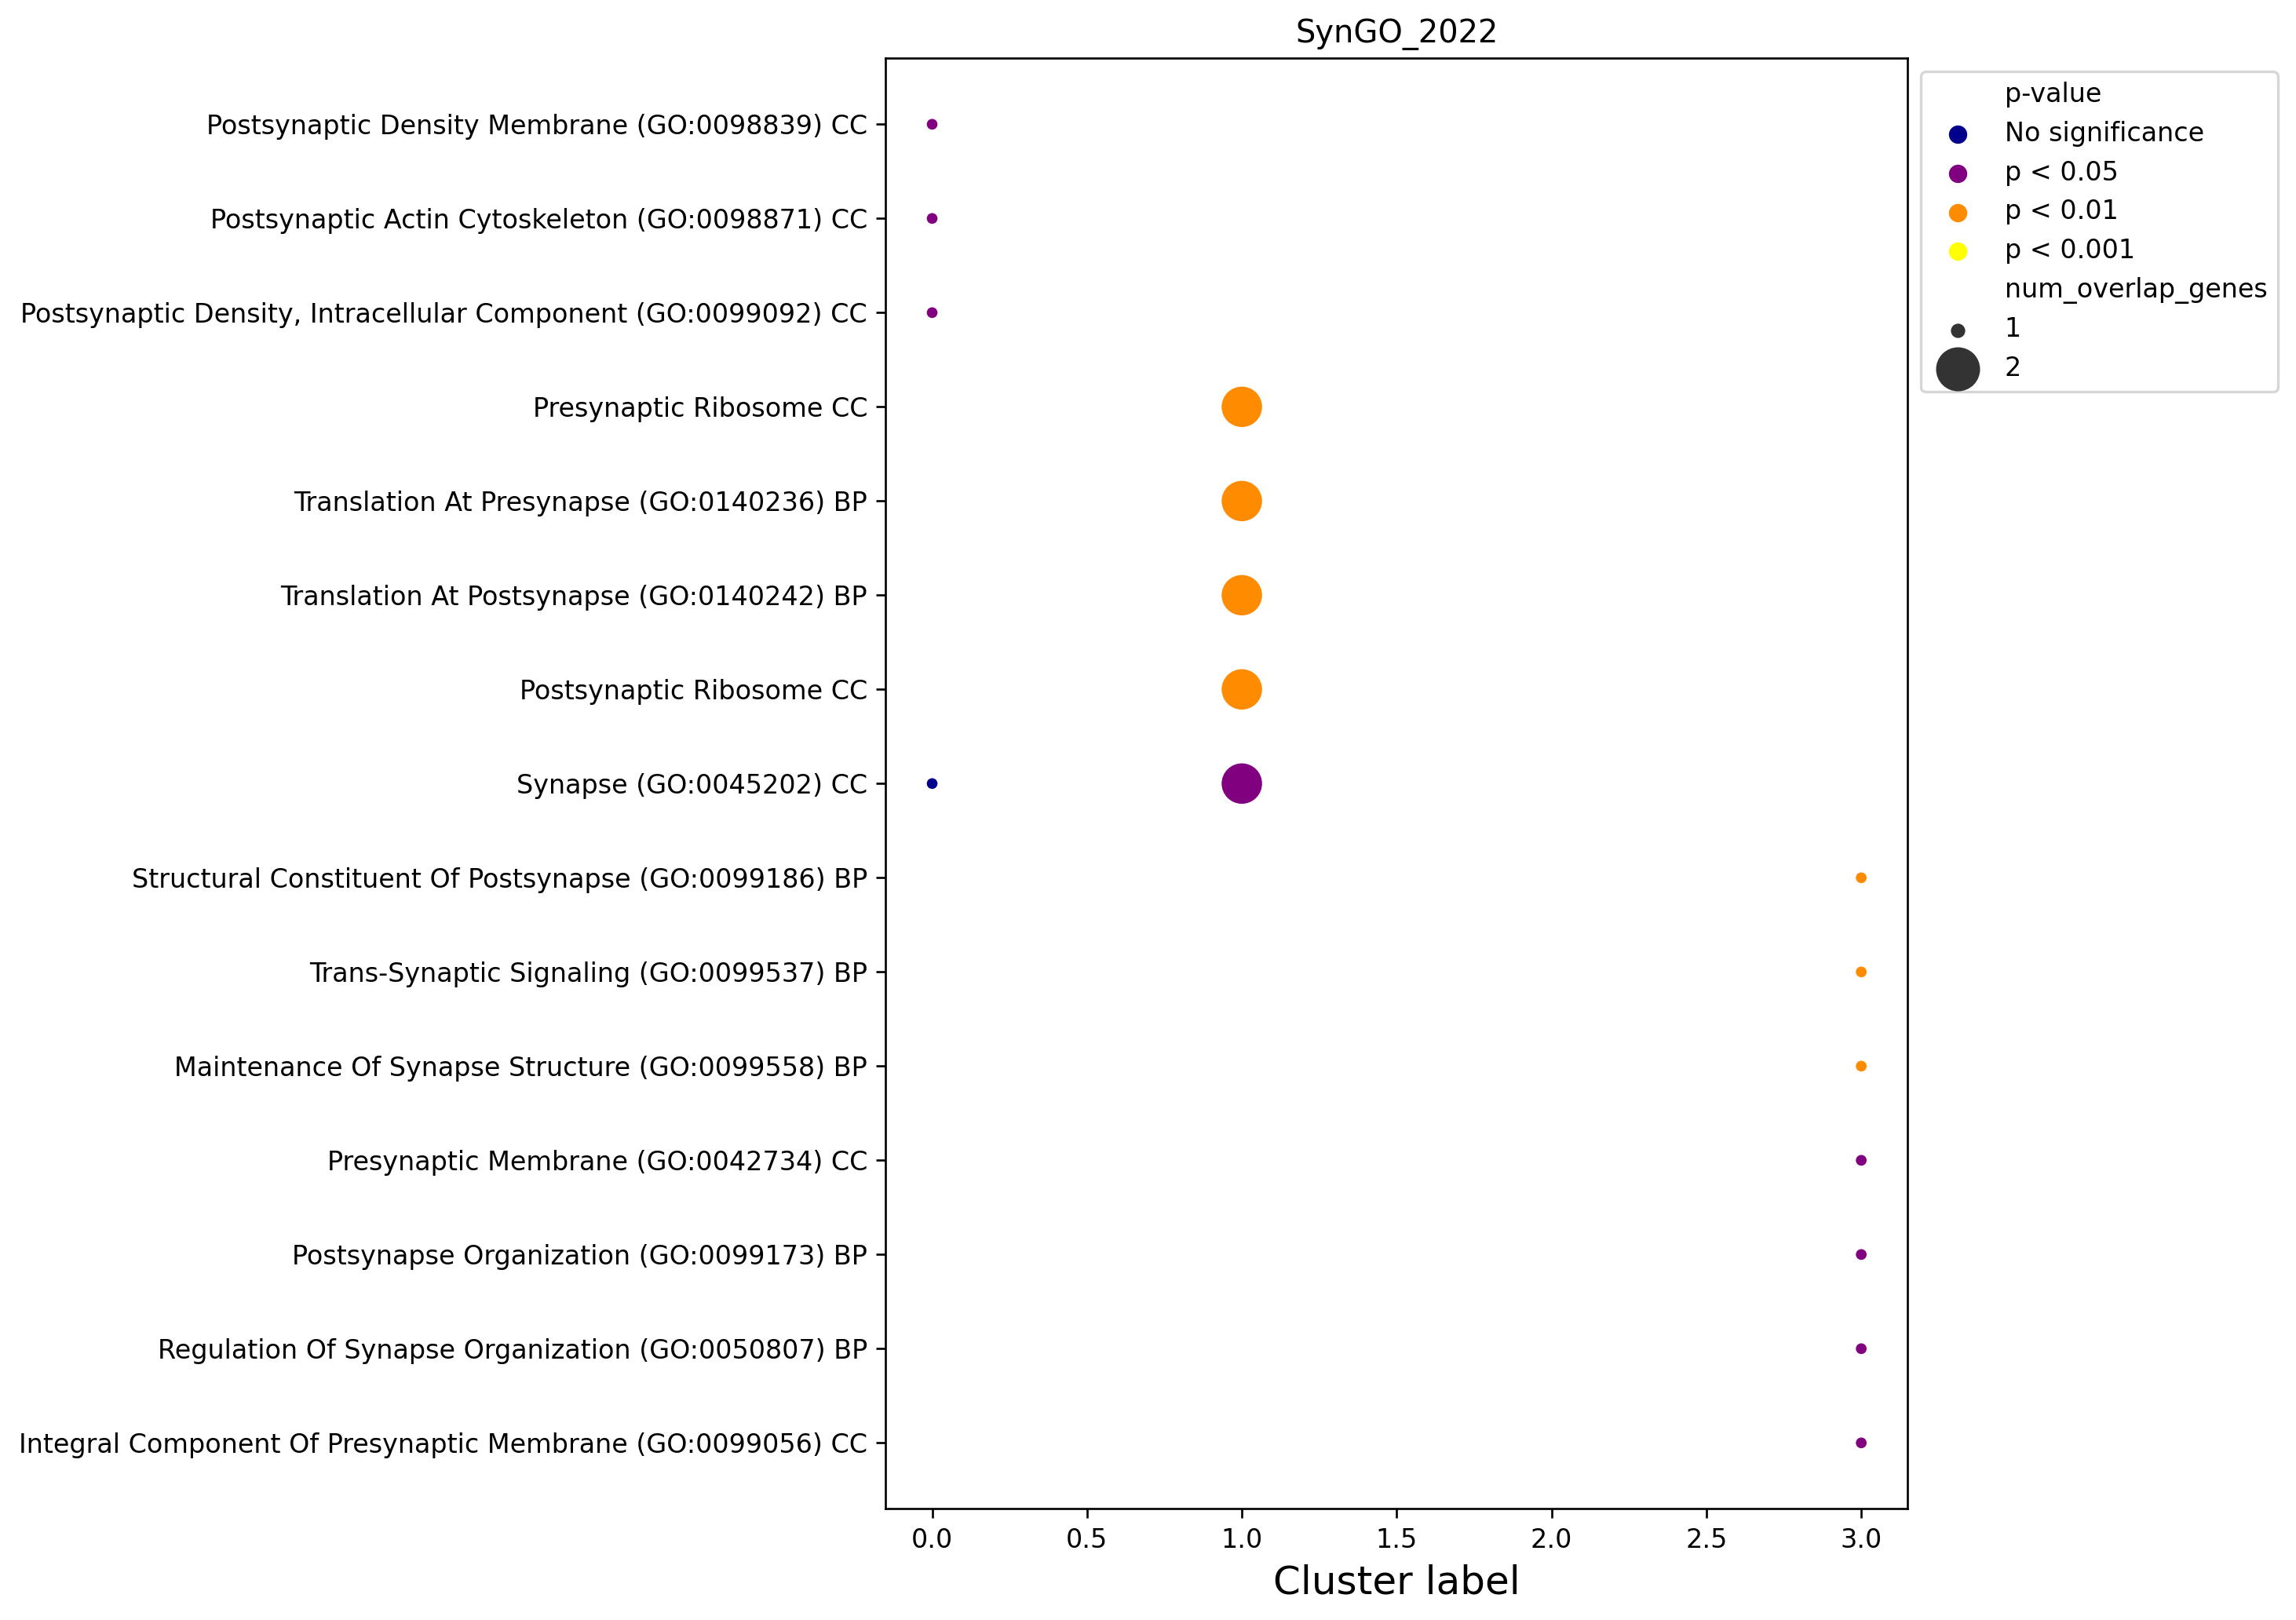

In [83]:
mpl.rcdefaults()
fig = plt.figure(figsize=(7, 10), dpi=120)

ax = sns.scatterplot(
    data=enrich_res_plot.reset_index(),
    x='cluster_label',
    y='Term',
    size='num_overlap_genes',
    sizes=(20, 250),
    hue='p-value',
    palette=color_discrete_map
)

ax.tick_params(labelsize=10)
ax.legend(fontsize=15)
ax.set_xlabel("Cluster label",fontsize=15)
ax.set_ylabel("", fontsize=10)
ax.grid(False)
ax.set_title(db_name)

sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

In [84]:
labels[labels == 3]

SEPTIN7    3
SEMA3A     3
SULF1      3
TSPAN3     3
WLS        3
dtype: int32

## MGI_Mammalian_Phenotype_Level_4_2021

In [85]:
db_name = 'MGI_Mammalian_Phenotype_Level_4_2021'
GeneCluster.enrich_geneclusters(gene_clust, db_name)

In [86]:
enrich_res = pd.concat([gc.enrichment_res[db_name] for gc in gene_clust])
enrich_res = enrich_res.set_index(['Term'])
enrich_res.head()

Rank     p-val  Z-score  \
Term                                                                          
abnormal cholinergic neuron morphology MP:0001038      1  0.001299      inf   
abnormal kidney collecting duct epithelium morp...     2  0.001299      inf   
abnormal lacrimal gland physiology MP:0001348          3  0.001299      inf   
stomach epithelial hyperplasia MP:0005493              4  0.001299      inf   
abnormal kidney corticomedullary boundary morph...     5  0.002596    897.0   

                                                    Combined score  \
Term                                                                 
abnormal cholinergic neuron morphology MP:0001038              inf   
abnormal kidney collecting duct epithelium morp...             inf   
abnormal lacrimal gland physiology MP:0001348                  inf   
stomach epithelial hyperplasia MP:0005493                      inf   
abnormal kidney corticomedullary boundary morph...      5340.57396   

                                                   Overlapping genes  \
Term                                                                   
abnormal cholinergic neuron morphology MP:0001038            [SORL1]   
abnormal kidney collecting duct epithelium morp...            [ANK3]   
abnormal lacrimal gland physiology MP:0001348                [THBS1]   
stomach epithelial hyperplasia MP:0005493                    [THBS1]   
abnormal kidney corticomedullary boundary morph...           [THBS1]   

                                                    Adjusted P-value  \
Term                                                                   
abnormal cholinergic neuron morphology MP:0001038           0.028895   
abnormal kidney collecting duct epithelium morp...          0.028895   
abnormal lacrimal gland physiology MP:0001348               0.028895   
stomach epithelial hyperplasia MP:0005493                   0.028895   
abnormal kidney corticomedullary boundary morph...          0.033919   

                                                    Old p-value  \
Term                                                              
abnormal cholinergic neuron morphology MP:0001038             0   
abnormal kidney collecting duct epithelium morp...            0   
abnormal lacrimal gland physiology MP:0001348                 0   
stomach epithelial hyperplasia MP:0005493                     0   
abnormal kidney corticomedullary boundary morph...            0   

                                                    Old adjusted p-value  \
Term                                                                       
abnormal cholinergic neuron morphology MP:0001038                      0   
abnormal kidney collecting duct epithelium morp...                     0   
abnormal lacrimal gland physiology MP:0001348                          0   
stomach epithelial hyperplasia MP:0005493                              0   
abnormal kidney corticomedullary boundary morph...                     0   

                                                    num_overlap_genes  \
Term                                                                    
abnormal cholinergic neuron morphology MP:0001038                   1   
abnormal kidney collecting duct epithelium morp...                  1   
abnormal lacrimal gland physiology MP:0001348                       1   
stomach epithelial hyperplasia MP:0005493                           1   
abnormal kidney corticomedullary boundary morph...                  1   

                                                    neg_log10(p_adj)  \
Term                                                                   
abnormal cholinergic neuron morphology MP:0001038           1.539170   
abnormal kidney collecting duct epithelium morp...          1.539170   
abnormal lacrimal gland physiology MP:0001348               1.539170   
stomach epithelial hyperplasia MP:0005493                   1.539170   
abnormal kidney corticomedullary boundary morph...

In [87]:
terms = enrich_res[(enrich_res['Adjusted P-value'] < 0.05) & (enrich_res.Rank < 10)].index.unique()
terms.size

20

In [88]:
from pandas.api.types import CategoricalDtype
enrich_res_plot = enrich_res.loc[terms].copy()
cat_type = CategoricalDtype(categories=['No significance', 'p < 0.05', 'p < 0.01', 'p < 0.001'], ordered=True)
enrich_res_plot['p-value'] = enrich_res_plot['Adjusted P-value'].apply(p_val_group).astype(cat_type)
enrich_results.append(enrich_res_plot)

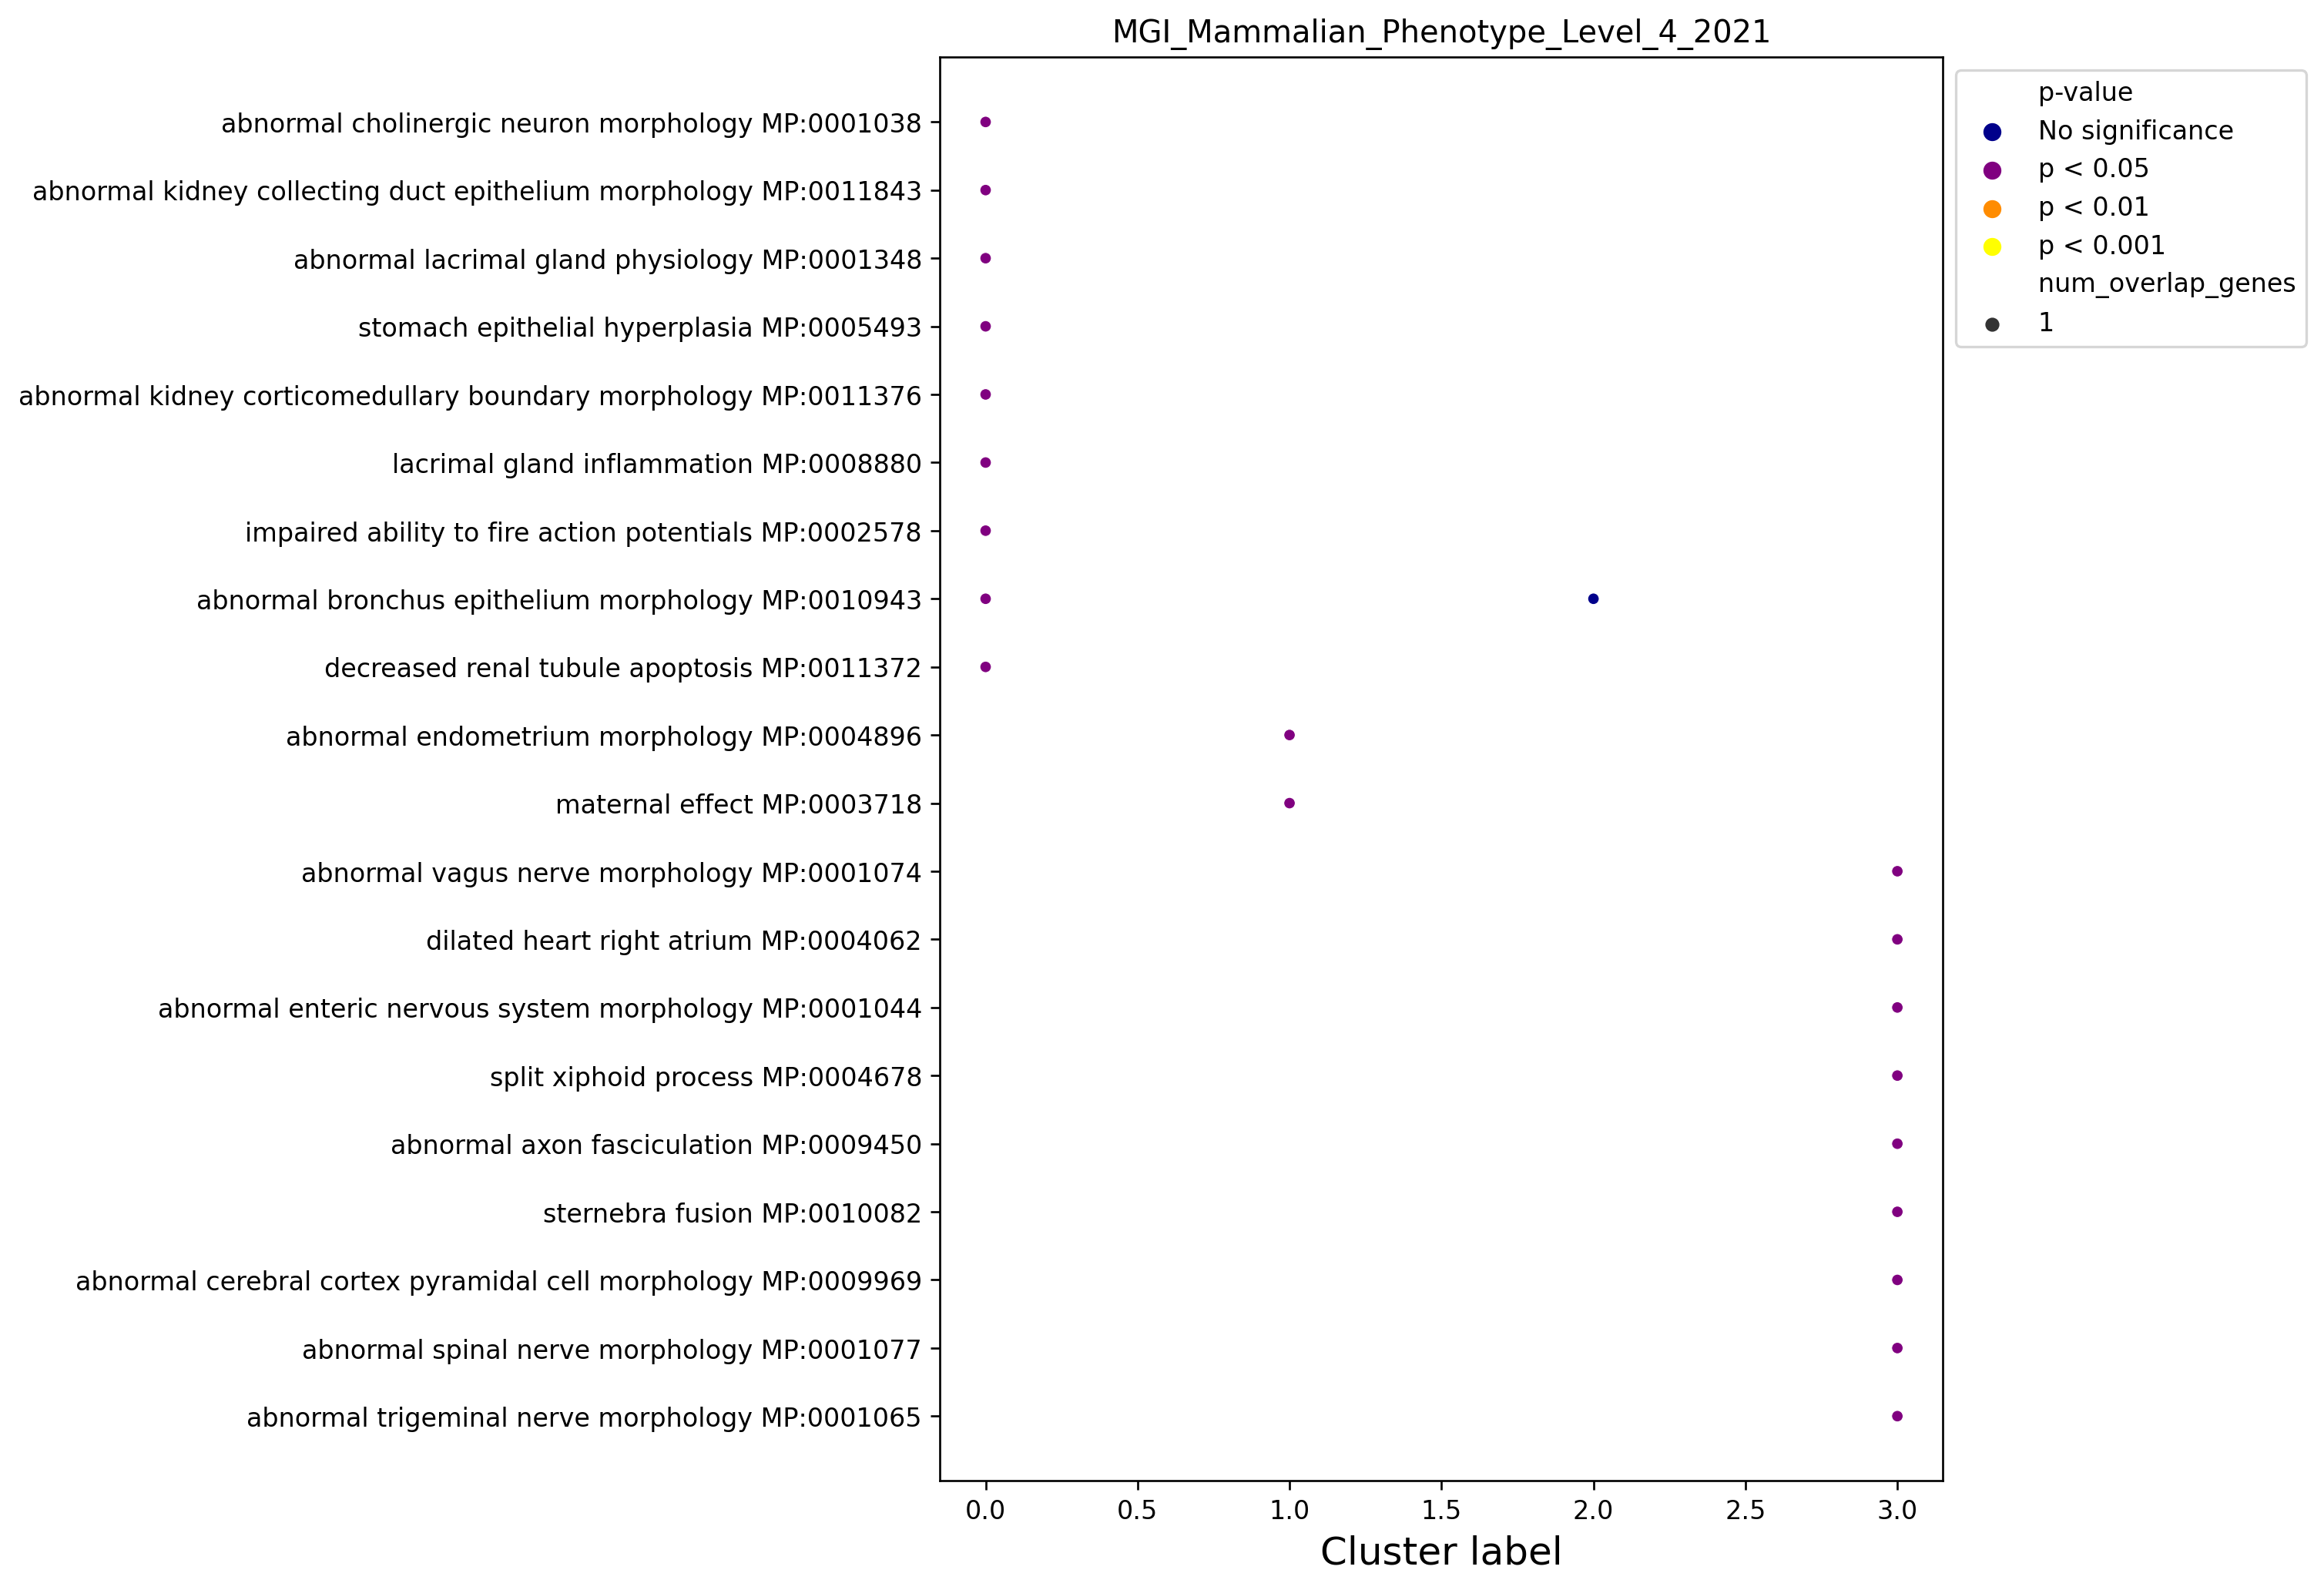

In [89]:
fig = plt.figure(figsize=(7, 10), dpi=120)

ax = sns.scatterplot(
    data=enrich_res_plot.reset_index(),
    x='cluster_label',
    y='Term',
    size='num_overlap_genes',
    sizes=(20, 250),
    hue='p-value',
    palette=color_discrete_map
)

ax.tick_params(labelsize=10)
ax.legend(fontsize=15)
ax.set_xlabel("Cluster label",fontsize=15)
ax.set_ylabel("", fontsize=10)
ax.grid(False)
ax.set_title(db_name)

sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

## Reactome_2022

In [90]:
db_name = 'Reactome_2022'
GeneCluster.enrich_geneclusters(gene_clust, db_name)

In [91]:
enrich_res = pd.concat([gc.enrichment_res[db_name] for gc in gene_clust])
enrich_res = enrich_res.set_index(['Term'])
enrich_res.head()

Rank     p-val  \
Term                                                                 
Ficolins Bind To Repetitive Carbohydrate Struct...     1  0.001299   
Lectin Pathway Of Complement Activation R-HSA-1...     2  0.001299   
Platelet Degranulation R-HSA-114608                    3  0.001585   
Response To Elevated Platelet Cytosolic Ca2+ R-...     4  0.001719   
O-glycosylation Of TSR Domain-Containing Protei...     5  0.002596   

                                                       Z-score  \
Term                                                             
Ficolins Bind To Repetitive Carbohydrate Struct...         inf   
Lectin Pathway Of Complement Activation R-HSA-1...         inf   
Platelet Degranulation R-HSA-114608                  46.408696   
Response To Elevated Platelet Cytosolic Ca2+ R-...   44.458333   
O-glycosylation Of TSR Domain-Containing Protei...  897.000000   

                                                    Combined score  \
Term                                                                 
Ficolins Bind To Repetitive Carbohydrate Struct...             inf   
Lectin Pathway Of Complement Activation R-HSA-1...             inf   
Platelet Degranulation R-HSA-114608                     299.200186   
Response To Elevated Platelet Cytosolic Ca2+ R-...      283.013646   
O-glycosylation Of TSR Domain-Containing Protei...     5340.573960   

                                                   Overlapping genes  \
Term                                                                   
Ficolins Bind To Repetitive Carbohydrate Struct...           [MASP1]   
Lectin Pathway Of Complement Activation R-HSA-1...           [MASP1]   
Platelet Degranulation R-HSA-114608                   [ACTN2, THBS1]   
Response To Elevated Platelet Cytosolic Ca2+ R-...    [ACTN2, THBS1]   
O-glycosylation Of TSR Domain-Containing Protei...           [THBS1]   

                                                    Adjusted P-value  \
Term                                                                   
Ficolins Bind To Repetitive Carbohydrate Struct...          0.029659   
Lectin Pathway Of Complement Activation R-HSA-1...          0.029659   
Platelet Degranulation R-HSA-114608                         0.029659   
Response To Elevated Platelet Cytosolic Ca2+ R-...          0.029659   
O-glycosylation Of TSR Domain-Containing Protei...          0.029853   

                                                    Old p-value  \
Term                                                              
Ficolins Bind To Repetitive Carbohydrate Struct...            0   
Lectin Pathway Of Complement Activation R-HSA-1...            0   
Platelet Degranulation R-HSA-114608                           0   
Response To Elevated Platelet Cytosolic Ca2+ R-...            0   
O-glycosylation Of TSR Domain-Containing Protei...            0   

                                                    Old adjusted p-value  \
Term                                                                       
Ficolins Bind To Repetitive Carbohydrate Struct...                     0   
Lectin Pathway Of Complement Activation R-HSA-1...                     0   
Platelet Degranulation R-HSA-114608                                    0   
Response To Elevated Platelet Cytosolic Ca2+ R-...                     0   
O-glycosylation Of TSR Domain-Containing Protei...                     0   

                                                    num_overlap_genes  \
Term                                                                    
Ficolins Bind To Repetitive Carbohydrate Struct...                  1   
Lectin Pathway Of Complement Activation R-HSA-1...                  1   
Platelet Degranulation R-HSA-114608                                 2   
Response To Elevated Platelet Cytosolic Ca2+ R-...                  2   
O-glycosylation Of TSR Domain-Containing Protei...                  1   

                                                    neg_log10(p_adj)  \
Term      

In [92]:
terms = enrich_res[(enrich_res['Adjusted P-value'] < 0.05) & (enrich_res.Rank < 10)].index.unique()
terms.size

22

In [93]:
from pandas.api.types import CategoricalDtype
enrich_res_plot = enrich_res.loc[terms].copy()
cat_type = CategoricalDtype(categories=['No significance', 'p < 0.05', 'p < 0.01', 'p < 0.001'], ordered=True)
enrich_res_plot['p-value'] = enrich_res_plot['Adjusted P-value'].apply(p_val_group).astype(cat_type)
enrich_results.append(enrich_res_plot)

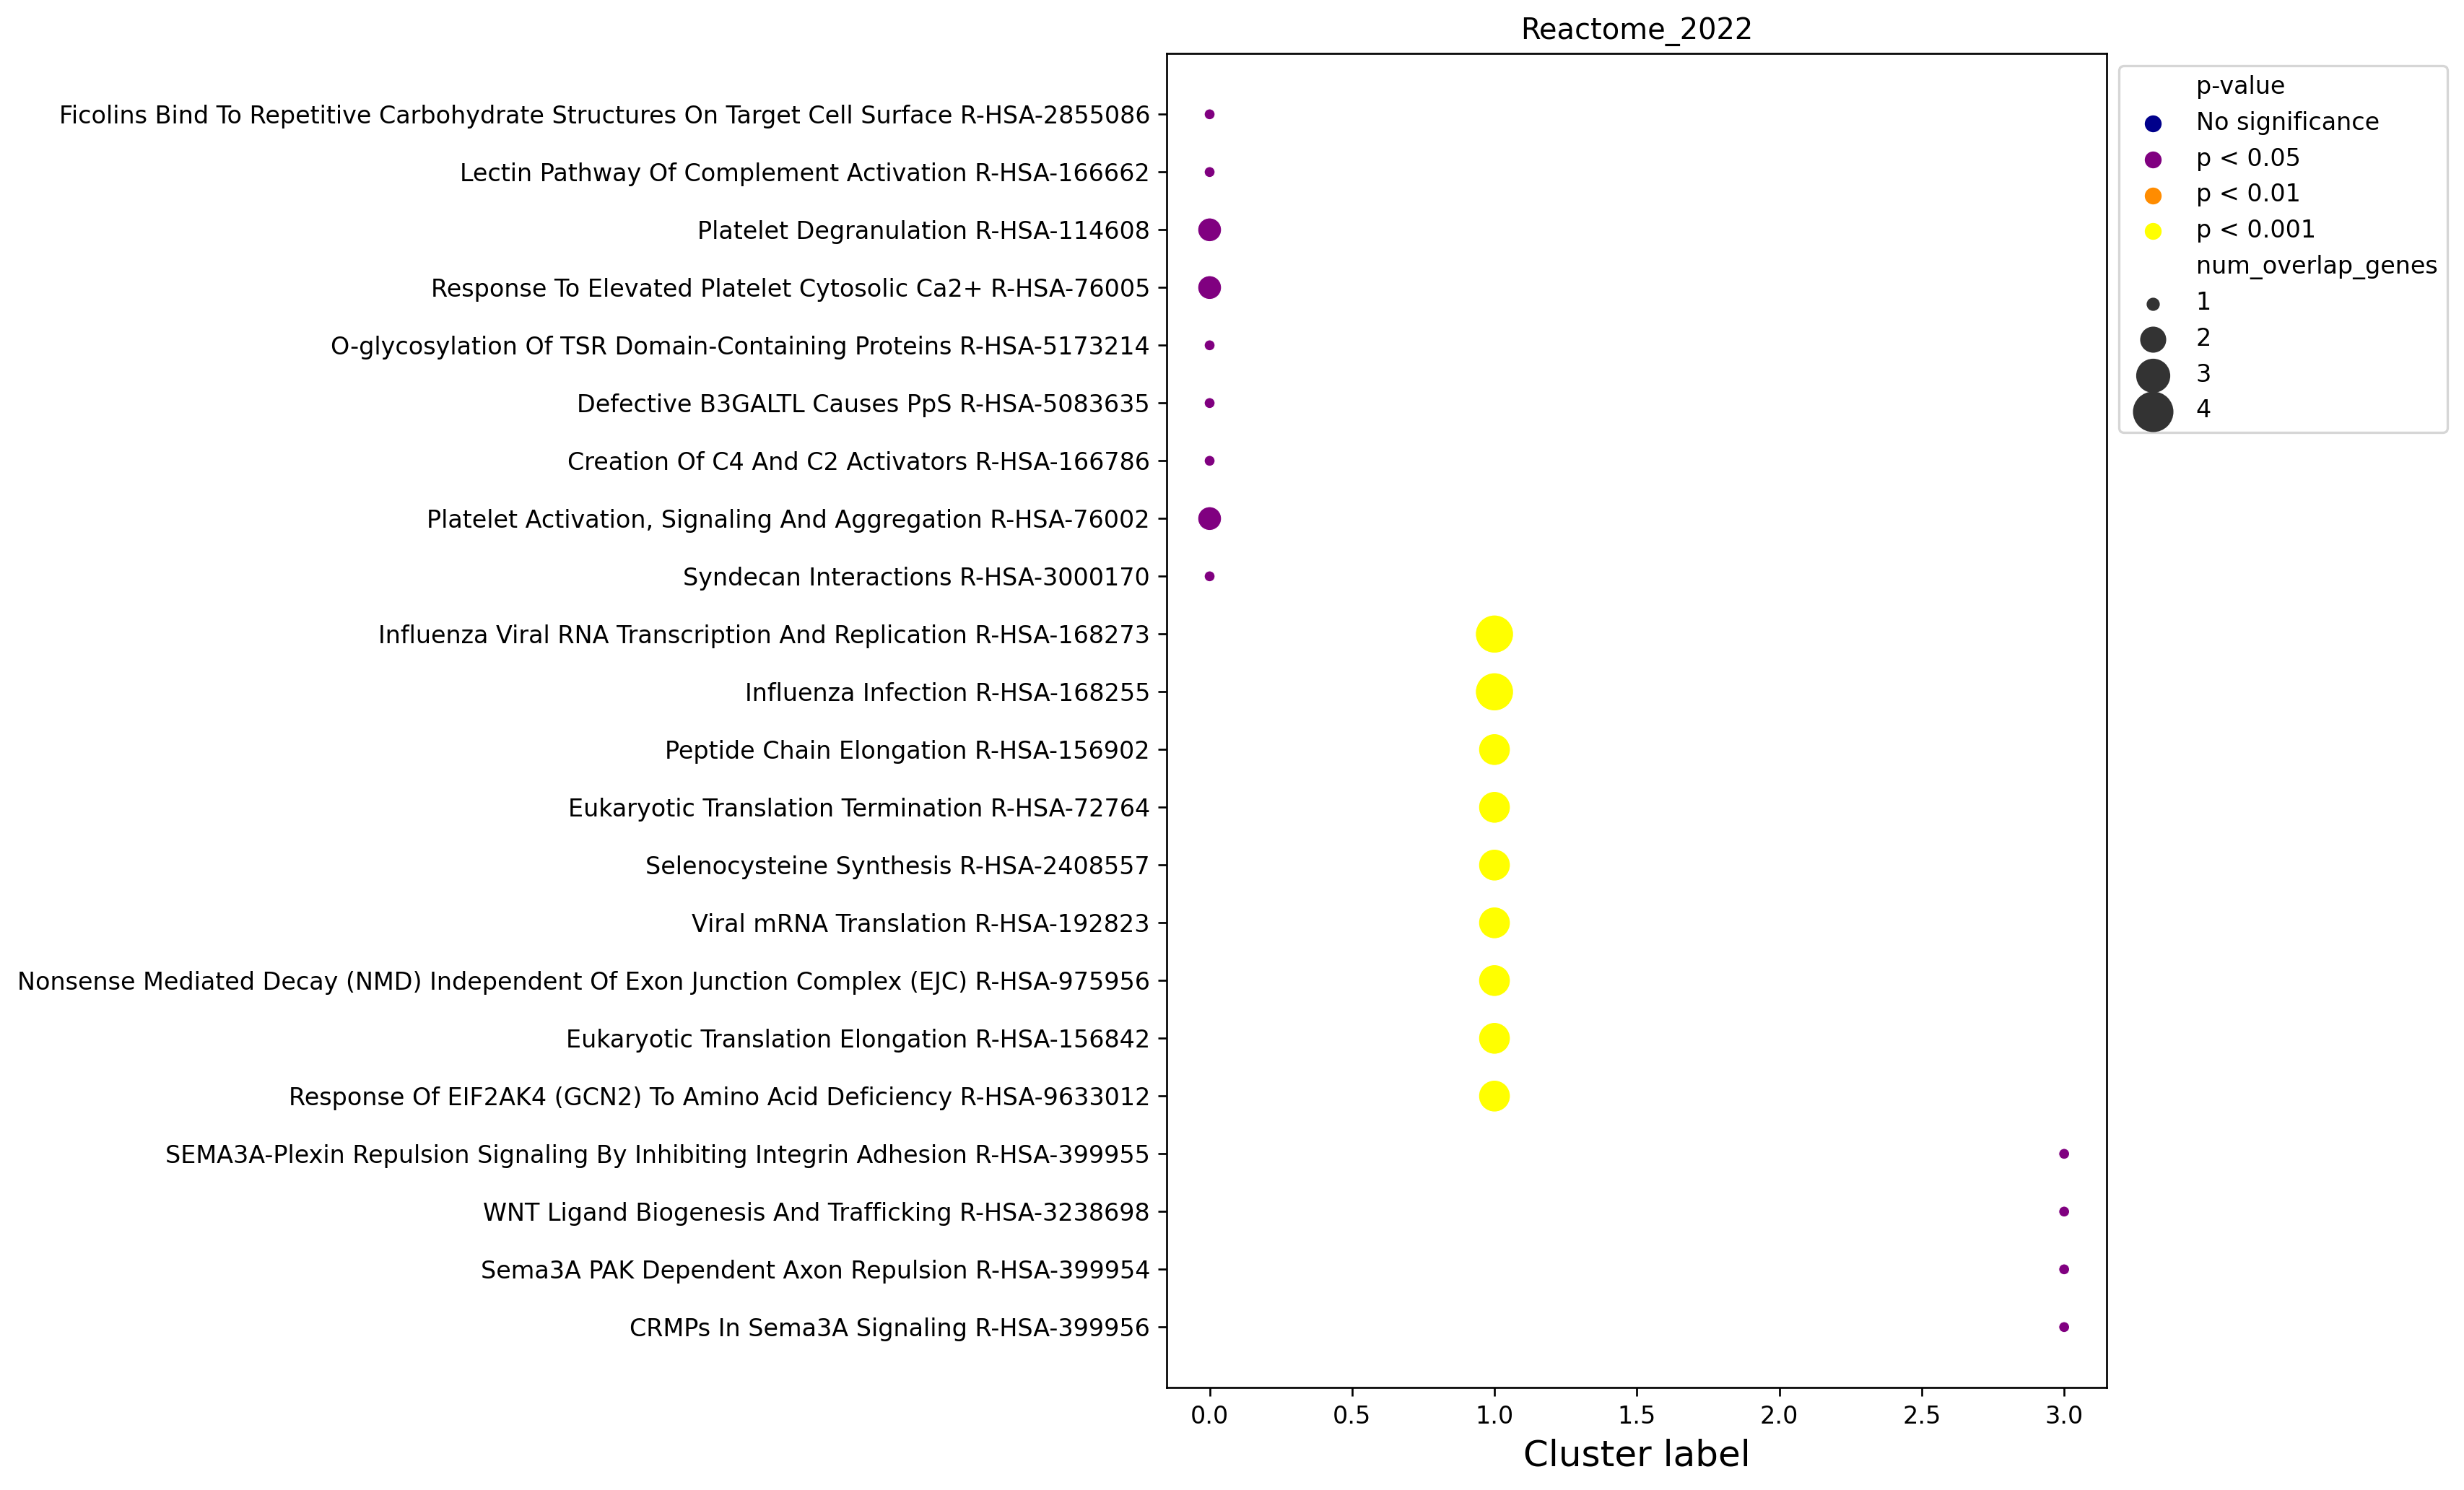

In [94]:
fig = plt.figure(figsize=(7, 10), dpi=120)

ax = sns.scatterplot(
    data=enrich_res_plot.reset_index(),
    x='cluster_label',
    y='Term',
    size='num_overlap_genes',
    sizes=(20, 250),
    hue='p-value',
    palette=color_discrete_map
)

ax.tick_params(labelsize=10)
ax.legend(fontsize=15)
ax.set_xlabel("Cluster label",fontsize=15)
ax.set_ylabel("", fontsize=10)
ax.grid(False)
ax.set_title(db_name)

sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

## KEGG_2021_Human

In [95]:
db_name = 'KEGG_2021_Human'
GeneCluster.enrich_geneclusters(gene_clust, db_name)

In [96]:
enrich_res = pd.concat([gc.enrichment_res[db_name] for gc in gene_clust])
enrich_res = enrich_res.set_index(['Term'])
enrich_res.head()

Rank     p-val     Z-score  \
Term                                                              
Proteoglycans in cancer                 1  0.003443   30.805797   
Staphylococcus aureus infection         2  0.005186  298.888889   
Malaria                                 3  0.007770  179.266667   
Complement and coagulation cascades     4  0.012922   99.518519   
Bladder cancer                          5  0.019329   63.916667   

                                     Combined score Overlapping genes  \
Term                                                                    
Proteoglycans in cancer                  174.715819     [ANK3, THBS1]   
Staphylococcus aureus infection         1572.687542           [MASP1]   
Malaria                                  870.774623           [THBS1]   
Complement and coagulation cascades      432.788621           [MASP1]   
Bladder cancer                           252.224158           [THBS1]   

                                     Adjusted P-value  Old p-value  \
Term                                                                 
Proteoglycans in cancer                      0.041442            0   
Staphylococcus aureus infection              0.041442            0   
Malaria                                      0.041442            0   
Complement and coagulation cascades          0.050016            0   
Bladder cancer                               0.050016            0   

                                     Old adjusted p-value  num_overlap_genes  \
Term                                                                           
Proteoglycans in cancer                                 0                  2   
Staphylococcus aureus infection                         0                  1   
Malaria                                                 0                  1   
Complement and coagulation cascades                     0                  1   
Bladder cancer                                          0                  1   

                                     neg_log10(p_adj)  cluster_label  
Term                                                                  
Proteoglycans in cancer                      1.382555              0  
Staphylococcus aureus infection              1.382555              0  
Malaria                                      1.382555              0  
Complement and coagulation cascades          1.300891              0  
Bladder cancer                               1.300891              0

In [97]:
terms = enrich_res[(enrich_res['Adjusted P-value'] < 0.05)].index.unique()
terms.size

7

In [98]:
from pandas.api.types import CategoricalDtype
enrich_res_plot = enrich_res.loc[terms].copy()
cat_type = CategoricalDtype(categories=['No significance', 'p < 0.05', 'p < 0.01', 'p < 0.001'], ordered=True)
enrich_res_plot['p-value'] = enrich_res_plot['Adjusted P-value'].apply(p_val_group).astype(cat_type)
enrich_results.append(enrich_res_plot)

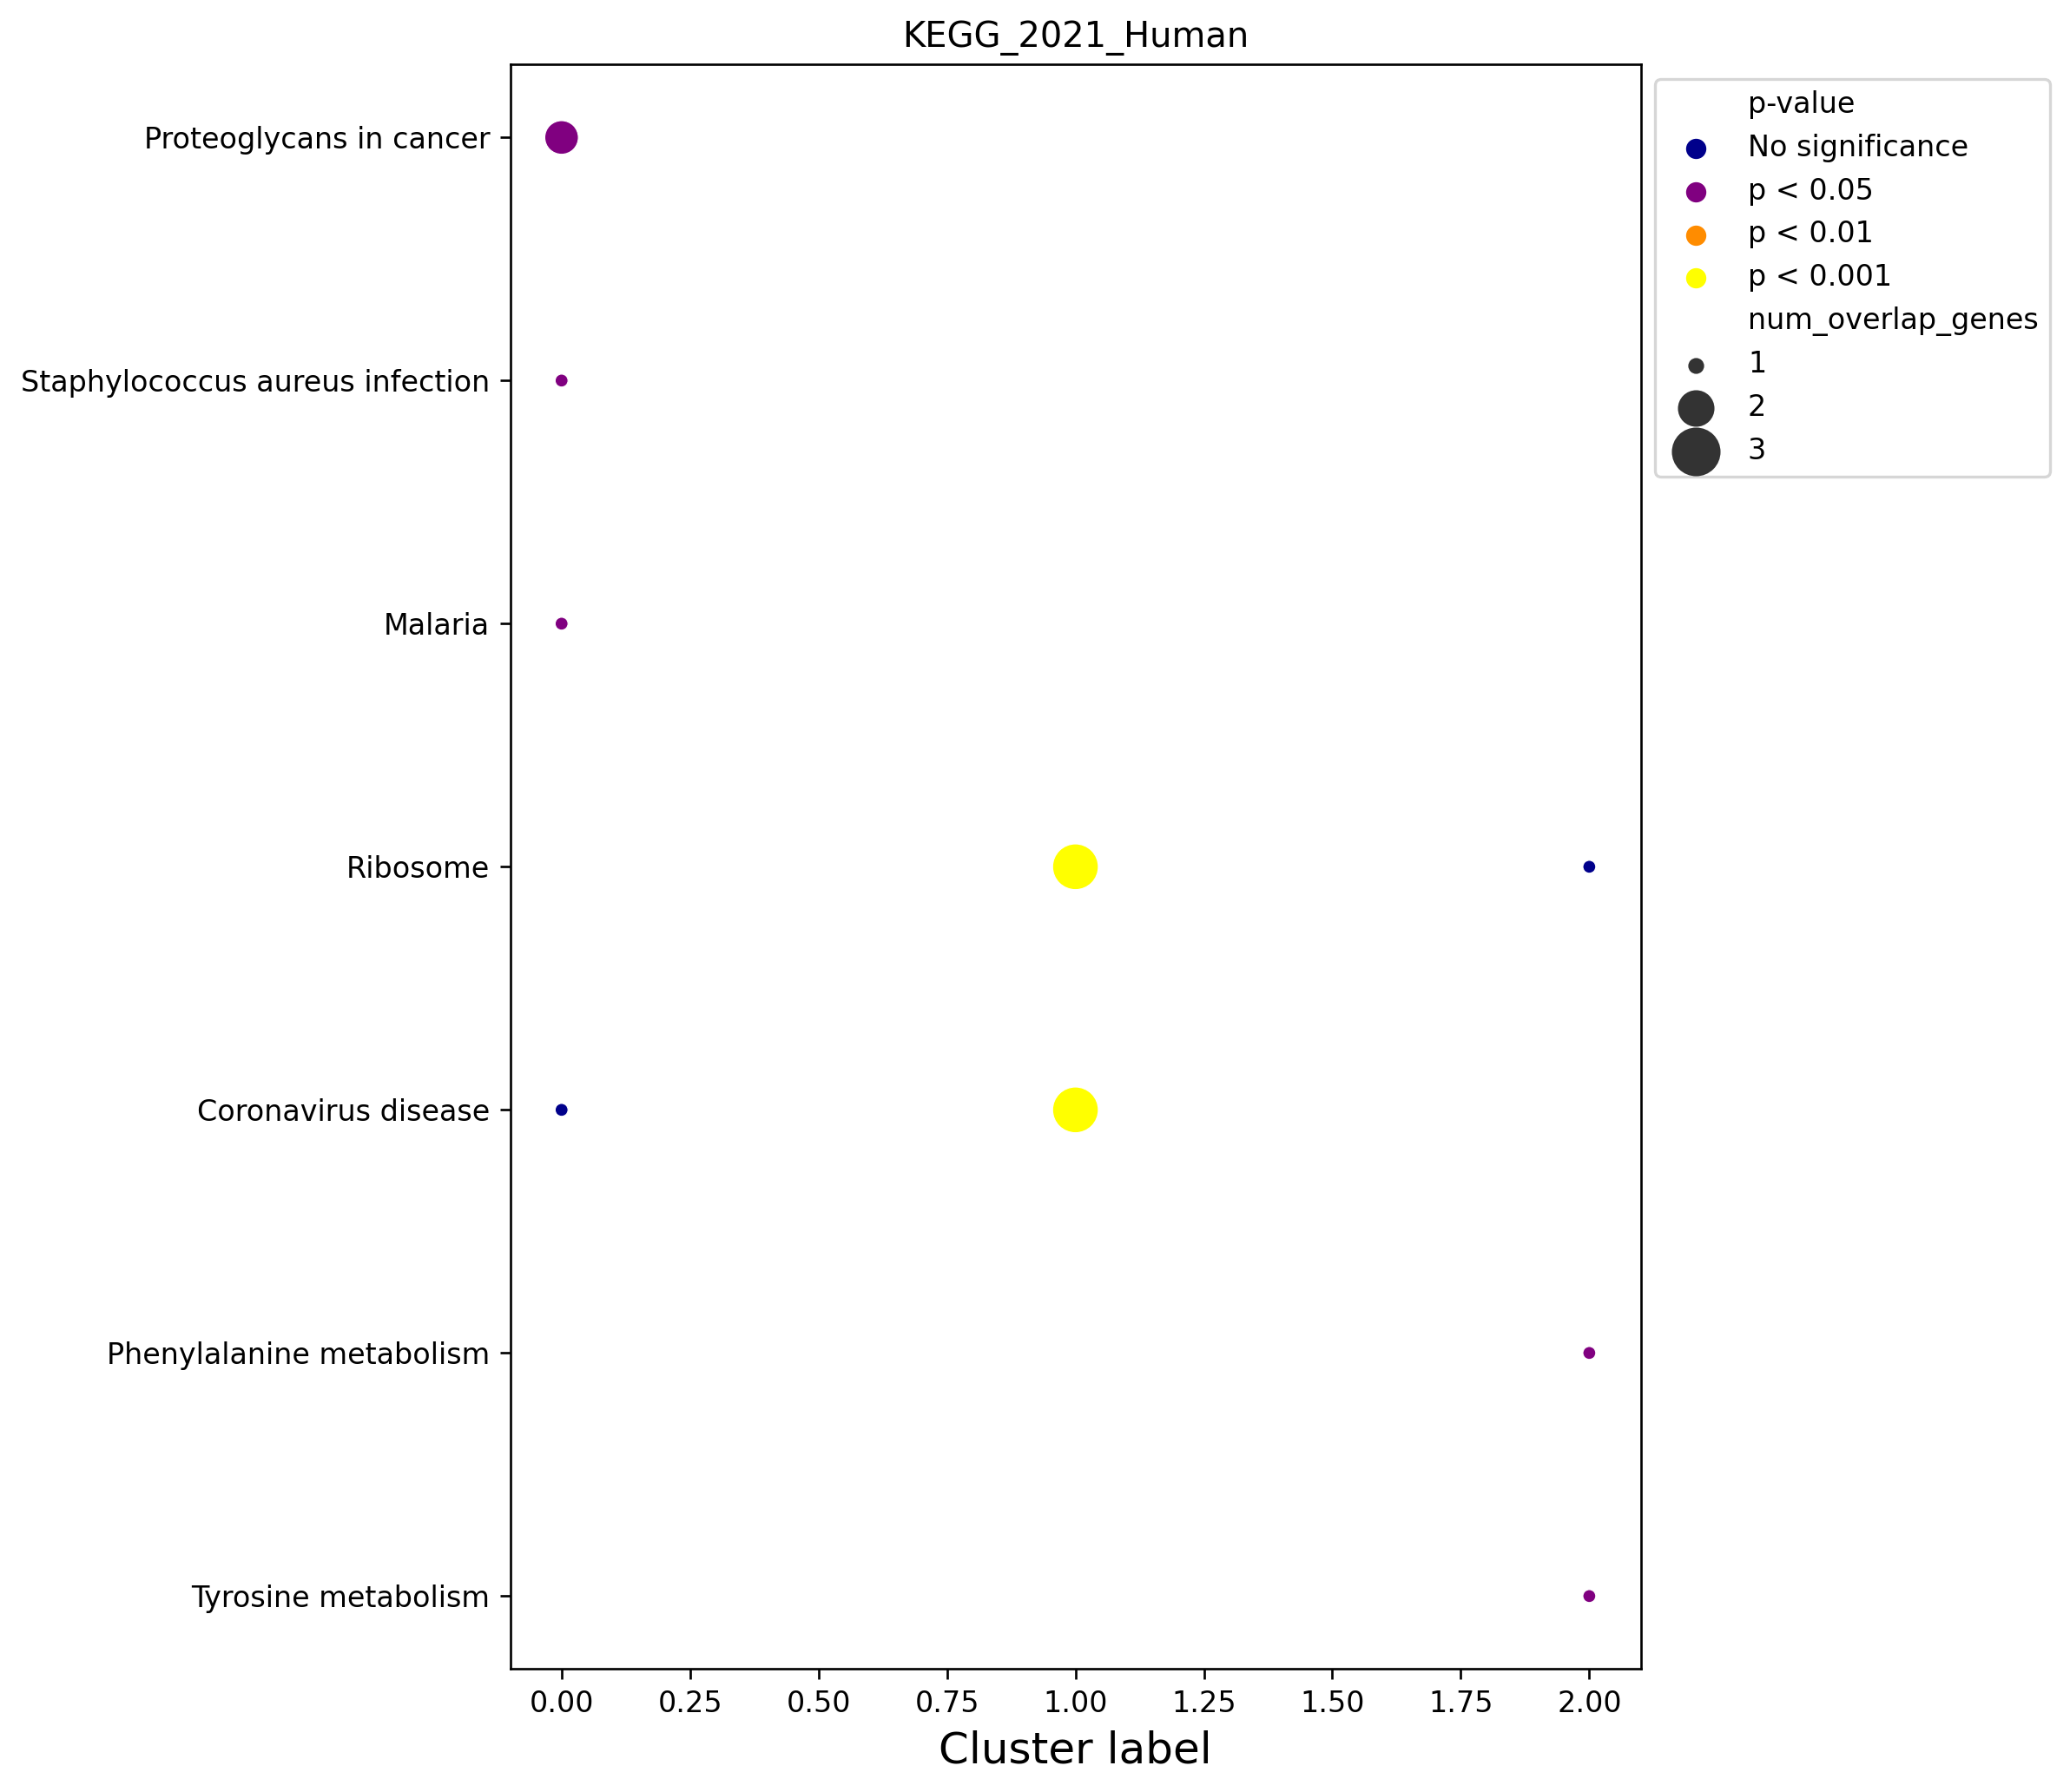

In [99]:
fig = plt.figure(figsize=(7, 10), dpi=120)

ax = sns.scatterplot(
    data=enrich_res_plot.reset_index(),
    x='cluster_label',
    y='Term',
    size='num_overlap_genes',
    sizes=(20, 250),
    hue='p-value',
    palette=color_discrete_map
)

ax.tick_params(labelsize=10)
ax.legend(fontsize=15)
ax.set_xlabel("Cluster label",fontsize=15)
ax.set_ylabel("", fontsize=10)
ax.grid(False)
ax.set_title(db_name)

sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))